
Copyright 2024 VistaMilk

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import balanced_accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
import lightgbm
import pickle
import logging
import coloredlogs
from sklearn.metrics import precision_recall_curve
import joblib
from tqdm.auto import tqdm
import json
from IPython.display import JSON
from IPython.display import display
from IPython.display import display_html
from itertools import chain,cycle
import matplotlib.dates as mdates

/home/phoxis/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Function definitions

The below functions will be used to compute several summaries for this notebook.

In [2]:
# Give one date or many dates, and the set of confusion matrix for the top n% prediction will be returned
# I average is confusion matrix is given
def daily_conf_mat (pred_info, dates, top_n = 1.0, var_summary = ["1_scc"]):
    pred_info["date"] = pd.to_datetime (pred_info["date"]);
    confmat_arr = {};
    attr_mat_arr = {};
    for this_var in var_summary:
        attr_mat_arr[this_var] = {};
        
    cm_idx = {}
    for this_date in dates:
        #print (this_date)
        today_df = pred_info[pred_info["date"] == this_date];
        if today_df.shape[0] == 0:
            #print ("No rows for date", this_date);
            continue;
        today_df = today_df.sort_values (by = "pred_prob", inplace = False, ascending = False);
        nrows = int (np.round (today_df.shape[0] * top_n));
        if nrows == 0:
            #print ("No rows for date after trunc", this_date);
            continue;
        today_df = today_df.iloc[range(nrows),:];
        confmat = pd.DataFrame (confusion_matrix (today_df[target_var], today_df["pred_thresh"], labels = [0, 1]));
        #print (confmat)
        confmat.index = ["True Healthy", "True Infected"];
        confmat.columns = ["Predicted Healthy", "Predicted Infected"];
        confmat_arr[str(this_date.date())] = confmat;
                
        cm_idx["tp"] = (today_df[target_var] == 1) & (today_df["pred_thresh"] == 1);
        cm_idx["tn"] = (today_df[target_var] == 1) & (today_df["pred_thresh"] == 0);
        cm_idx["fp"] = (today_df[target_var] == 0) & (today_df["pred_thresh"] == 1);
        cm_idx["fn"] = (today_df[target_var] == 0) & (today_df["pred_thresh"] == 0);
        
        
        for this_var in var_summary:
            attr_mat_arr[this_var][str(this_date.date())] = [None, None, None, None];
            attr_mat_arr[this_var][str(this_date.date())][0] = today_df.loc[cm_idx["tp"],this_var];
            attr_mat_arr[this_var][str(this_date.date())][1] = today_df.loc[cm_idx["tn"],this_var];
            attr_mat_arr[this_var][str(this_date.date())][2] = today_df.loc[cm_idx["fp"],this_var];
            attr_mat_arr[this_var][str(this_date.date())][3] = today_df.loc[cm_idx["fn"],this_var];
        
    return ({"cm": confmat_arr, "attdist": attr_mat_arr});

In [3]:

def early_detect_by_days_subclin (model_probs, output_var, use_tuned_threshold = True, top_n = 1.0):

  if use_tuned_threshold == True:
    model_probs["pred_infected"] = model_probs["pred_thresh"];
  else:
    model_probs["pred_infected"] = model_probs["pred_prob"] >= 0.5;

  if output_var == "early_detect_sub_clinical":
      time_count_var = "time_till_inf_sub_clin_0days";
  elif output_var == "early_detect_clinical":
      time_count_var = "time_till_inf_clin_0days";


  # Sort by probability
  #model_probs[time_count_var] = model_probs[time_count_var].fillna (0);
  model_probs = model_probs.sort_values (by = "pred_prob", inplace = False, ascending = False);
  nrows = int (np.round (model_probs.shape[0] * top_n));
  if nrows == 0:
     return None;

  # Select top_n percent rows based on the probability
  model_probs = model_probs.iloc[range(nrows),:];

  # Make sure that the `date' field is in datetime format
  model_probs["date"] = pd.to_datetime (model_probs["date"]);

  # Sort back the top_n percent rows in id, date order (original order)
  model_probs = model_probs.sort_values (by = ["id", "date"], inplace =  False, ascending = True);

  infection_before = False;

  cow_early_list = {};
  all_cows = pd.DataFrame (np.zeros ((7, 2)));
  all_cows.index = [1, 2, 3, 4, 5, 6, 7];
  all_cows.columns = [True, False];

  inf_template = pd.DataFrame (np.zeros ((7, 2)));
  inf_template.index = all_cows.index;
  inf_template.columns = [time_count_var, "pred_infected"];

  total_infections = 0;
  for key, row in tqdm (model_probs.groupby ("id")):
      #sick_rows = row[row[output_var]==1];
      sick_rows = row;
      if sick_rows.shape[0] == 0:
          continue;

      this_cow_all_inf = pd.DataFrame ();
      # Find a block of infection and then copy it over to the template
      inf_start = False;
      #print (key)
      last_date = sick_rows.iloc[0]["date"] - pd.to_timedelta(1);
      days_count_down = 0;
      for i in range (sick_rows.shape[0]):
          if inf_start == False and sick_rows.iloc[i][output_var] == True and 0 < sick_rows.iloc[i][time_count_var] <= 7: # WARNING: Now if the first record?
              inf_start = True;
              this_inf = inf_template.copy ();
              days_count_down = sick_rows.iloc[i][time_count_var];
              last_day_idx = i;
              inf_first_detect = False;
              total_infections += 1;
              #print ("Sick start", sick_rows.iloc[i]["date"]);

          if inf_start == True:

              #print (days_count_down)
              # If a milking was done in this day then we will "time_till_inf_sub_clin" value equal to our count down counter
              # So, make this row the one to propate to the next missing milking day
              if sick_rows.iloc[i][time_count_var] == days_count_down:
                  last_day_idx = i;

              inf_first_detect = inf_first_detect or bool (sick_rows.iloc[last_day_idx]["pred_infected"]);

              # Copy the infection prediction from the last milking day
              this_inf.loc[days_count_down,"pred_infected"] = inf_first_detect;
              this_inf.loc[days_count_down,time_count_var] = days_count_down;
              #print (days_count_down)
              days_count_down -= 1;

              # Reset infection
              if np.isnan (sick_rows.iloc[i][time_count_var]) or sick_rows.iloc[i][time_count_var] > days_count_down + 1 or (sick_rows.iloc[i]["date"] - last_date).days > 7 or i == sick_rows.shape[0] - 1:
                  #print ("Sick end", sick_rows.iloc[i]["date"]);
                  inf_start = False;
                  while days_count_down > 0:
                      this_inf.loc[days_count_down,"pred_infected"] = inf_first_detect;
                      this_inf.loc[days_count_down,time_count_var] = days_count_down;
                      days_count_down -= 1;

                  this_cow_all_inf = this_cow_all_inf.append (this_inf);
                  #print (this_cow_all_inf)
                  #print (this_inf);
                  #print ("\n\n\n\n")

          last_date = sick_rows.iloc[i]["date"];


      if this_cow_all_inf.shape[0] == 0:
          continue;
      #print (this_cow_all_inf);
      #print (this_inf)
      #sick_early = pd.Categorical (sick_rows[time_count_var].astype (int), categories = [1, 2, 3, 4, 5, 6, 7]);
      #sick_predict = pd.Categorical (sick_rows["pred_infected"], categories = [True, False]);
      sick_early = pd.Categorical (this_cow_all_inf[time_count_var].astype (int), categories = [1, 2, 3, 4, 5, 6, 7]);
      sick_predict = pd.Categorical (this_cow_all_inf["pred_infected"], categories = [True, False]);
      this_cow = pd.crosstab (sick_early, sick_predict, dropna = False);
      cow_early_list[key] = this_cow;
      #print (all_cows);
      #print (this_cow);
      all_cows += this_cow;
      #print (all_cows);
  #proportions = np.flip (np.array (all_cows.apply (lambda x: x / np.sum (all_cows.iloc[0,:]), axis = 1).iloc[1:8,0]));
  proportions = np.array (all_cows.apply (lambda x: x / np.sum (all_cows.iloc[0,:]), axis = 1).iloc[:,0]);

  return ({"all_cows": all_cows, "proportions": proportions, "per_cow": cow_early_list});

In [4]:

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
  

# Global config

In [5]:
plt.rcParams['figure.dpi'] = 300; # Large plots

In [6]:
ptype_str = {};

ptype_str["subclin"] = "Sub-Clinical";
ptype_str["clin"] = "Clinical";



# Load existing trained model and prepare test set predictions

The below code is to regenerate the result csv files and predicitions with the test set by loading the already trained models. The trained models are trained and saved using the above code.

In [7]:
# os.chdir ("/home/phoxis/Documents/works/vistamilk/Vistamilk%20DSS/vision_res/set4"); # Switch to the specific model instance
# os.chdir ("/home/phoxis/Documents/works/vistamilk/Vistamilk%20DSS/vision_res/clin"); # Switch to the specific model instance
# os.chdir ("/home/phoxis/Documents/works/vistamilk/Vistamilk%20DSS/vision_res/subclin_nomilkinfo"); # Switch to the specific model instance
# os.chdir ("/home/phoxis/Documents/works/vistamilk/Vistamilk%20DSS/vision_res/clinical_calibrate"); # Switch to the specific model instance
os.chdir ("/home/phoxis/Documents/works/vistamilk/Vistamilk%20DSS/vision_res/subclin_final_model"); # Switch to the specific model instance
# os.chdir ("/home/phoxis/Documents/works/vistamilk/Vistamilk%20DSS/vision_res/subclin_calibrate_temp"); # Switch to the specific model instance
# os.chdir ("/home/phoxis/Documents/works/vistamilk/Vistamilk%20DSS/vision_res/subclin_nounsure"); # Switch to the specific model instance
# os.chdir ("/home/phoxis/Documents/works/vistamilk/Vistamilk%20DSS/vision_res/subclin_final"); # Switch to the specific model instance
# os.chdir ("/home/phoxis/Documents/works/vistamilk/Vistamilk%20DSS/testing_new_1"); # Switch to the specific model instance

In [8]:
model_type = "subclin";

In [9]:
if model_type == "subclin":
    target_var = "early_detect_sub_clinical";
elif model_type == "clin":
    target_var = "early_detect_clinical";

## Data configuration

The config file used for training.
Note that, this should not be inspected while viewing the results. This is for debugging purpose to make sure the correct model was loaded.
+ if "train_test_merge" is false, then the data/testing is directly used for test and the training is partitioned using "train_valid_date_split"
+ if "test_data_path" is invalid or missing, then the "train_data_path" will be used only and the "train_test_date_split" and "train_valid_date_split" will be used to create the train, valid and test partition
+ if "train_test_merge" is true and "test_data_path" is valid, then the train and test sets will be merged and then the train, valiid and test splits will be done as above


In [10]:
with open ("model_train_cfg.json", "r") as fp:
    cfg = json.load (fp);

FileNotFoundError: [Errno 2] No such file or directory: 'model_train_cfg.json'

In [ ]:
print (json.dumps(cfg, indent = 2))

## Hyperparameters

The hyperparameters used to train this model


In [11]:
# NOTE: For all recording frequencies the hyperparameters are identical, so we just read and show the one related with 0 (or original) recording freqiency
with open (f"{model_type}_0_hyperparams.json", "r") as fp:
    hyperparams = json.load (fp);

In [12]:
print (json.dumps(hyperparams, indent = 2))

{
  "colsample_bytree": 0.5,
  "gamma": 1.2532246033623349,
  "learning_rate": 0.005,
  "max_depth": 6,
  "n_estimators": 1000,
  "subsample": 1.0,
  "tree_method": "hist",
  "use_label_encoder": false
}


# Model Analysis

This section computes and plots several metrics

In [13]:
tn, fp, fn, tp 

NameError: name 'tn' is not defined

In [14]:
cm1

NameError: name 'cm1' is not defined

In [15]:
# Read models and predicted csvs and generatet plots and report

auc_arr = {}
sens_arr = {}
spec_arr = {}
fpr_arr = {}
tpr_arr = {}
auc_arr[model_type] = {}
sens_arr[model_type] = {}
spec_arr[model_type] = {}
fpr_arr[model_type] = {}
tpr_arr[model_type] = {}


# The trained models have the below simulated frequencies
#days_list = ["0", "15", "25", "30", "45", "50", "60"];
#days_list_plot_text = ["7", "15", "25", "30", "45", "50", "60"];

# We are using the following to present, as 25, 35, 50 etc are too much details.
days_list = ["0", "15", "30", "45", "60"];
days_list_plot_text = ["7", "15", "30", "45", "60"];

cm_idx = {};

prop_df = pd.DataFrame ();
cms = {};
for ptype in [model_type]:
    cms[ptype] = {};
    for days in days_list:
        pred_info = pd.read_csv (f'{ptype}_{str (days)}_pred_info.csv');
        cm_idx[days] = {};
        cm1 = confusion_matrix(pred_info[target_var], pred_info["pred_thresh"])
        #print(ptype + " " + days + " Confusion Matrix : \n");


        total1 = sum(sum(cm1))
        
        sensitivity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        specificity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        
         
        cm1 = pd.DataFrame (cm1);
        cm1.index = ["True Healthy", "True Infected"];
        cm1.columns = ["Predicted Healthy", "Predicted Infected"];
        #print (cm1.to_latex ())
        cms[ptype][days] = cm1;
        
        fpr, tpr, thresholds = metrics.roc_curve (pred_info[target_var], pred_info["pred_prob"]);

        #Plotting AUC curve
        auc = metrics.auc (fpr, tpr);
        auc = np.round (auc, 4);
        auc_arr[ptype][days] = auc;
        sens_arr[ptype][days] = sensitivity;
        spec_arr[ptype][days] = specificity;
        fpr_arr[ptype][days] = fpr;
        tpr_arr[ptype][days] = tpr;
        
        
        
        proportions_file_path = f'{model_type}_seven_day_proportiton.csv' if days == "0" else f'{model_type}_seven_day_proportiton_{str (days)}.csv';
        this_prop = pd.read_csv (proportions_file_path, header = None);
        prop_df[days] = this_prop.loc[:,0];
        
        cm_idx[days]["tp"]  = (pred_info[target_var] == 1) & (pred_info["pred_thresh"] == 1);
        cm_idx[days]["tn"]  = (pred_info[target_var] == 1) & (pred_info["pred_thresh"] == 0);
        cm_idx[days]["fp"]  = (pred_info[target_var] == 0) & (pred_info["pred_thresh"] == 0);
        cm_idx[days]["fn"]  = (pred_info[target_var] == 0) & (pred_info["pred_thresh"] == 1);    
            

In [16]:
fpr_arr_a = fpr_arr;
tpr_arr_a = tpr_arr;
auc_arr_a = auc_arr;

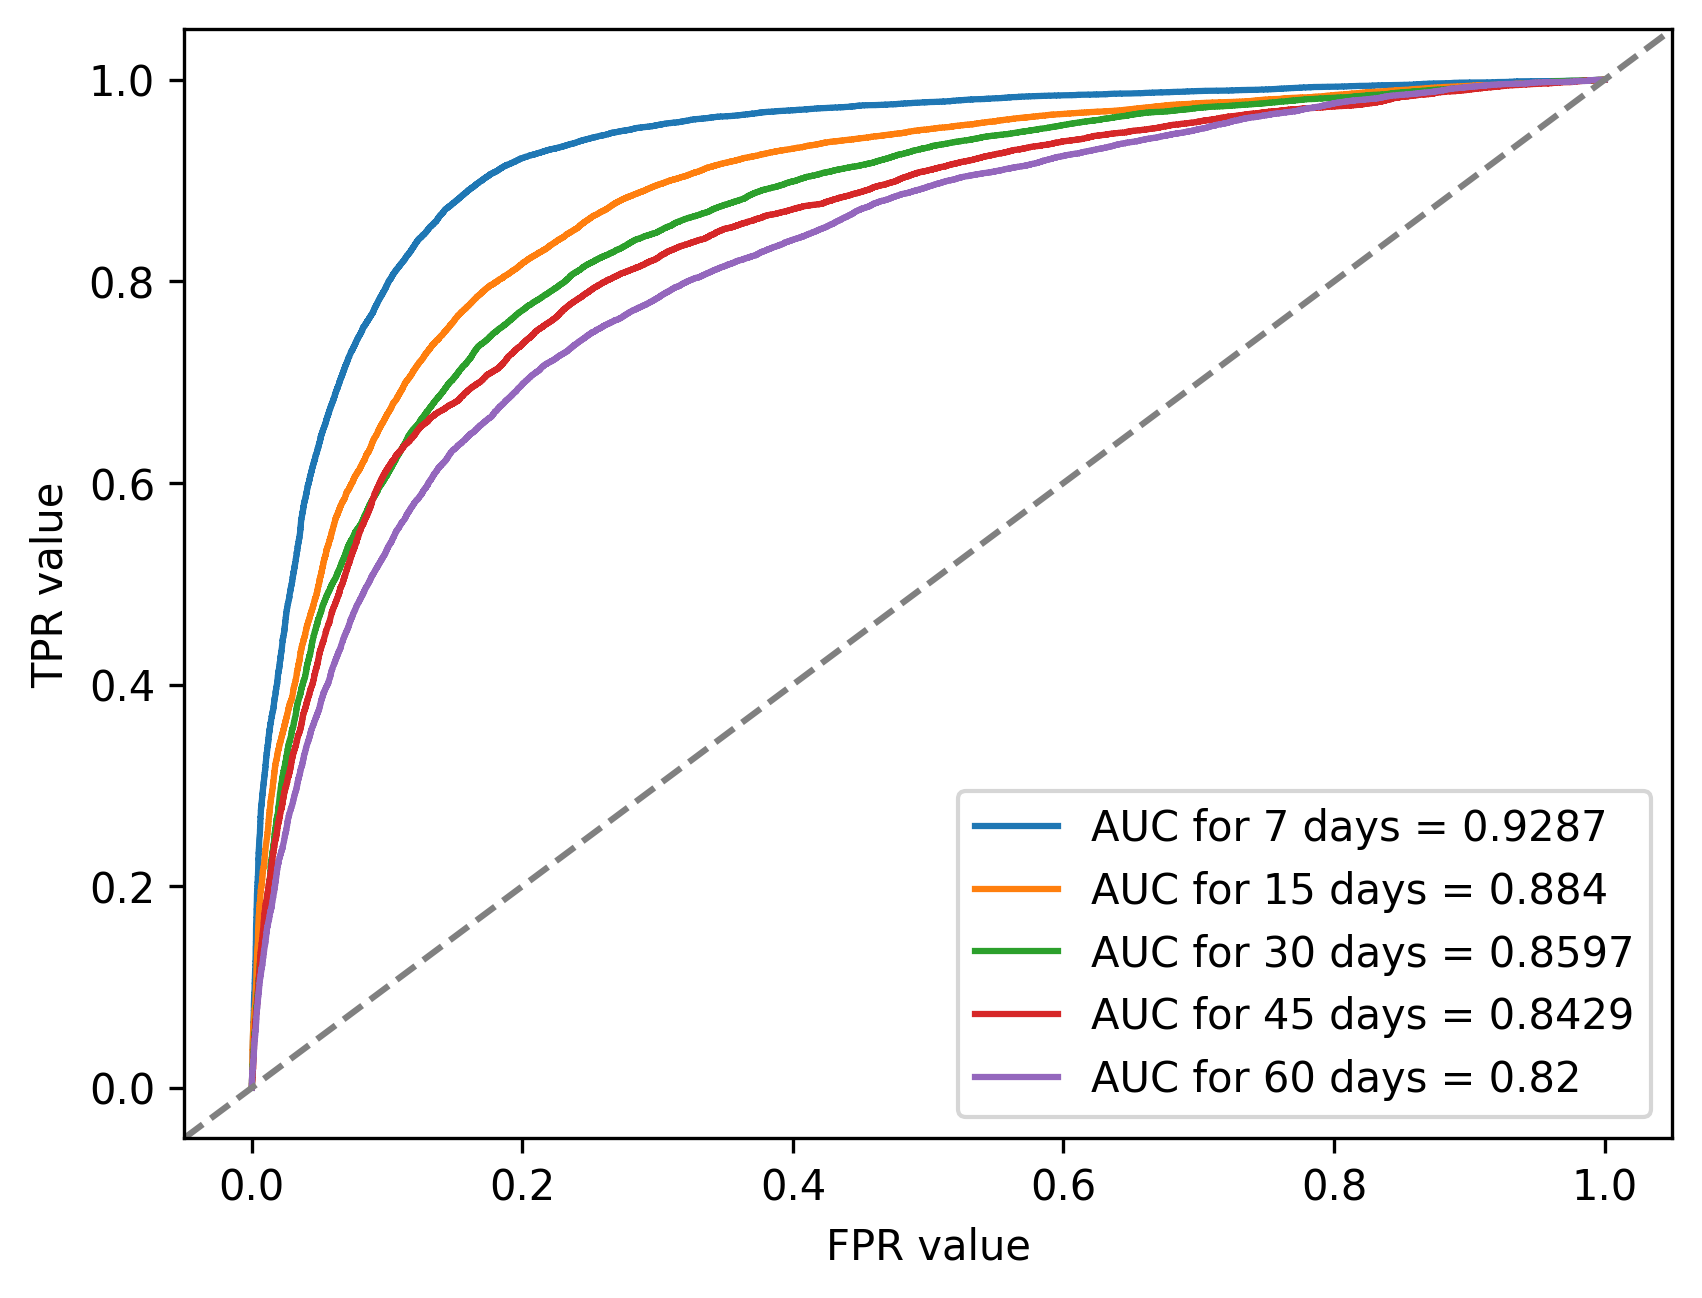

In [17]:
# TODO: ADD THE NOMILKINFO MODEL HERE
for ptype in [model_type]:
    for days in days_list:
        days_str = days if days != "0" else "7";
        plt.plot (fpr_arr[ptype][days], tpr_arr[ptype][days], label = 'AUC for ' + days_str + ' days = ' + str (auc_arr[ptype][days]));

# plt.plot (fpr_arr[ptype][days], tpr_arr[ptype][days], label = 'AUC for ' + "No Milking info = " + str (auc_arr[ptype]["15"]));


plt.legend(loc = 'lower right')
plt.xlabel('FPR value')
plt.ylabel('TPR value')
# plt.title('Test AUC for ' + ptype_str[ptype])
plt.axline((1, 1), slope = 1, color = "grey", ls = "--")
plt.show ();

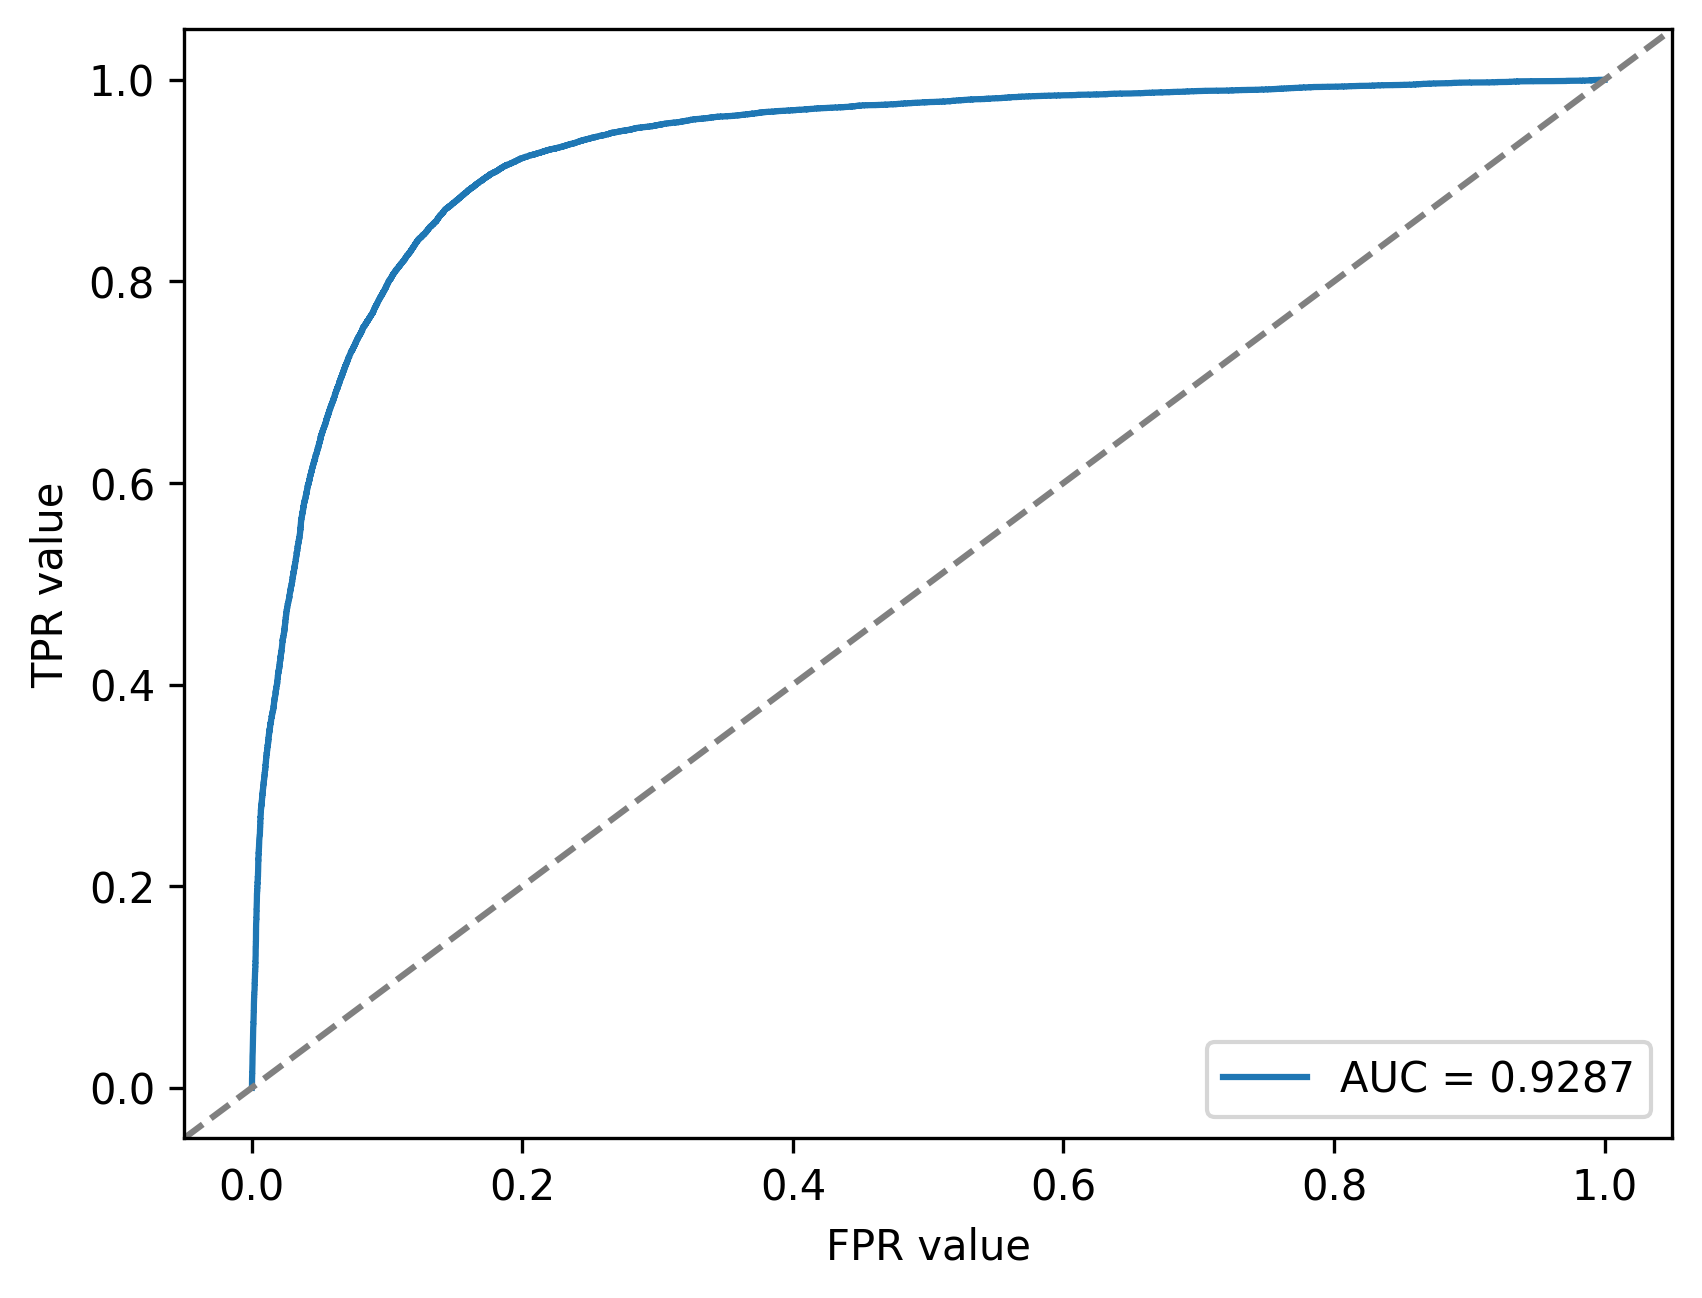

In [18]:
# TODO: ADD THE NOMILKINFO MODEL HERE
plt.plot (fpr_arr_a[ptype]["0"], tpr_arr_a[ptype]["0"], label = 'AUC = ' + str (auc_arr_a[ptype]["0"]))
# plt.plot (fpr_arr[ptype][days], tpr_arr[ptype][days], label = 'AUC for ' + "No Milking info = " + str (auc_arr[ptype]["15"]));

plt.legend (loc = 'lower right');
plt.xlabel('FPR value')
plt.ylabel('TPR value')
# plt.title('Test AUC for ' + ptype_str[ptype])
plt.axline((1, 1), slope = 1, color = "grey", ls = "--")

plt.show ();

In [19]:
sens_spec = pd.concat ([pd.DataFrame (sens_arr), pd.DataFrame (spec_arr), pd.DataFrame (auc_arr)], axis = 1);
sens_spec.columns = ["Sensitivity", "Specificity", "AUC"];
sens_spec.index = days_list_plot_text;
display (np.round (sens_spec, 4))
print (sens_spec.to_latex ())

Sensitivity  Specificity     AUC
7        0.6945       0.9564  0.9287
15       0.6760       0.9063  0.8840
30       0.6211       0.8911  0.8597
45       0.6339       0.8587  0.8429
60       0.6693       0.8043  0.8200

\begin{tabular}{lrrr}
\toprule
{} &  Sensitivity &  Specificity &     AUC \\
\midrule
7  &     0.694489 &     0.956412 &  0.9287 \\
15 &     0.675978 &     0.906276 &  0.8840 \\
30 &     0.621123 &     0.891130 &  0.8597 \\
45 &     0.633890 &     0.858664 &  0.8429 \\
60 &     0.669305 &     0.804254 &  0.8200 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_14683/4159563878.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print (sens_spec.to_latex ())


In [20]:
# days = 30;
# proportions_file_path = f'{model_type}_seven_day_proportiton.csv' if days == "0" else f'{model_type}_seven_day_proportiton_{str (days)}.csv';
# this_prop = pd.read_csv

# tmp = joblib.load (f"{model_type}_seven_day_cow_raw_{str (30)}.joblib");

+ Below is the proportion of correct classificaion.
+ Rows indicate the data recording frequency with 7 the original recording.
+ Columns indicate the days ahead the infection is predicted.

In [21]:
prop_per = np.round (prop_df * 100, 2)
prop_per = prop_per.transpose ();
# prop_per = prop_per[prop_per.columns[::-1]]
prop_per.columns = range (1, 8)
prop_per.index= days_list_plot_text;
#print (prop_per.to_latex ())
#display (prop_per)
print ("Proportion of correct classification")
pd.set_option ("precision", 2);
prop_per.style.background_gradient (cmap = "Blues", axis = None)


Proportion of correct classification


OptionError: 'Pattern matched multiple keys'

Below is the overall confusion matrices for each data recording frequencies

In [22]:
for ptype in [model_type]:
    for days in days_list:
        print (ptype + " " + days + " data recording Confusion Matrix : \n");
        display (cms[ptype][days])
        #cms[ptype][days].style.background_gradient (cmap = "Blues")
        print ("\n\n")

subclin 0 data recording Confusion Matrix : 



Predicted Healthy  Predicted Infected
True Healthy              134683               59248
True Infected               1744               38267




subclin 15 data recording Confusion Matrix : 



Predicted Healthy  Predicted Infected
True Healthy              131093               62838
True Infected               3750               36261




subclin 30 data recording Confusion Matrix : 



Predicted Healthy  Predicted Infected
True Healthy              120455               73476
True Infected               4356               35655




subclin 45 data recording Confusion Matrix : 



Predicted Healthy  Predicted Infected
True Healthy              122931               71000
True Infected               5655               34356




subclin 60 data recording Confusion Matrix : 



Predicted Healthy  Predicted Infected
True Healthy              129799               64132
True Infected               7832               32179

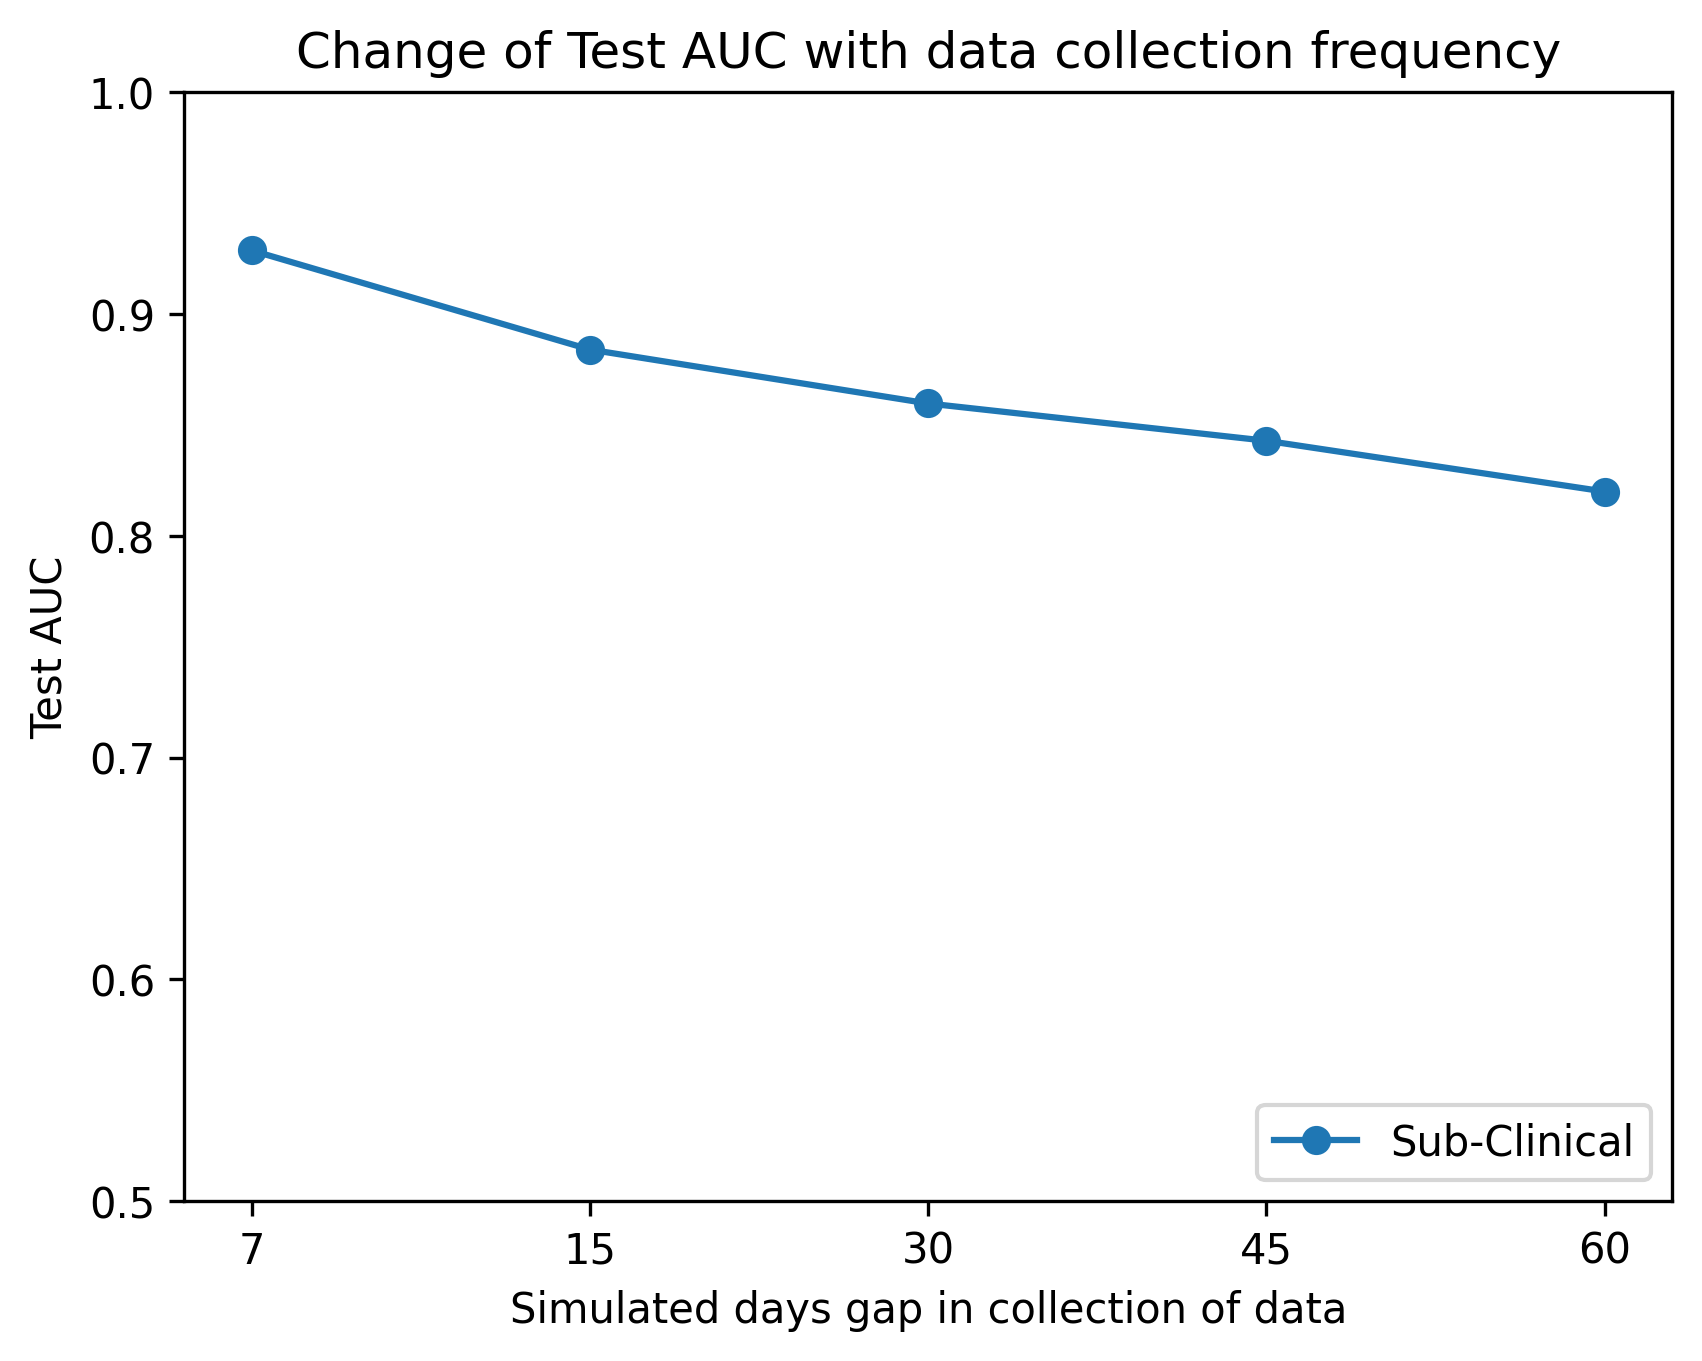

In [23]:

plt.plot (days_list_plot_text, auc_arr[model_type].values (), marker = "o", label = ptype_str[model_type]);
plt.xlabel ("Simulated days gap in collection of data");
plt.ylabel ("Test AUC");
plt.title ("Change of Test AUC with data collection frequency");
plt.legend (loc = "lower right");
plt.ylim ([0.5, 1.0]);
plt.show ();


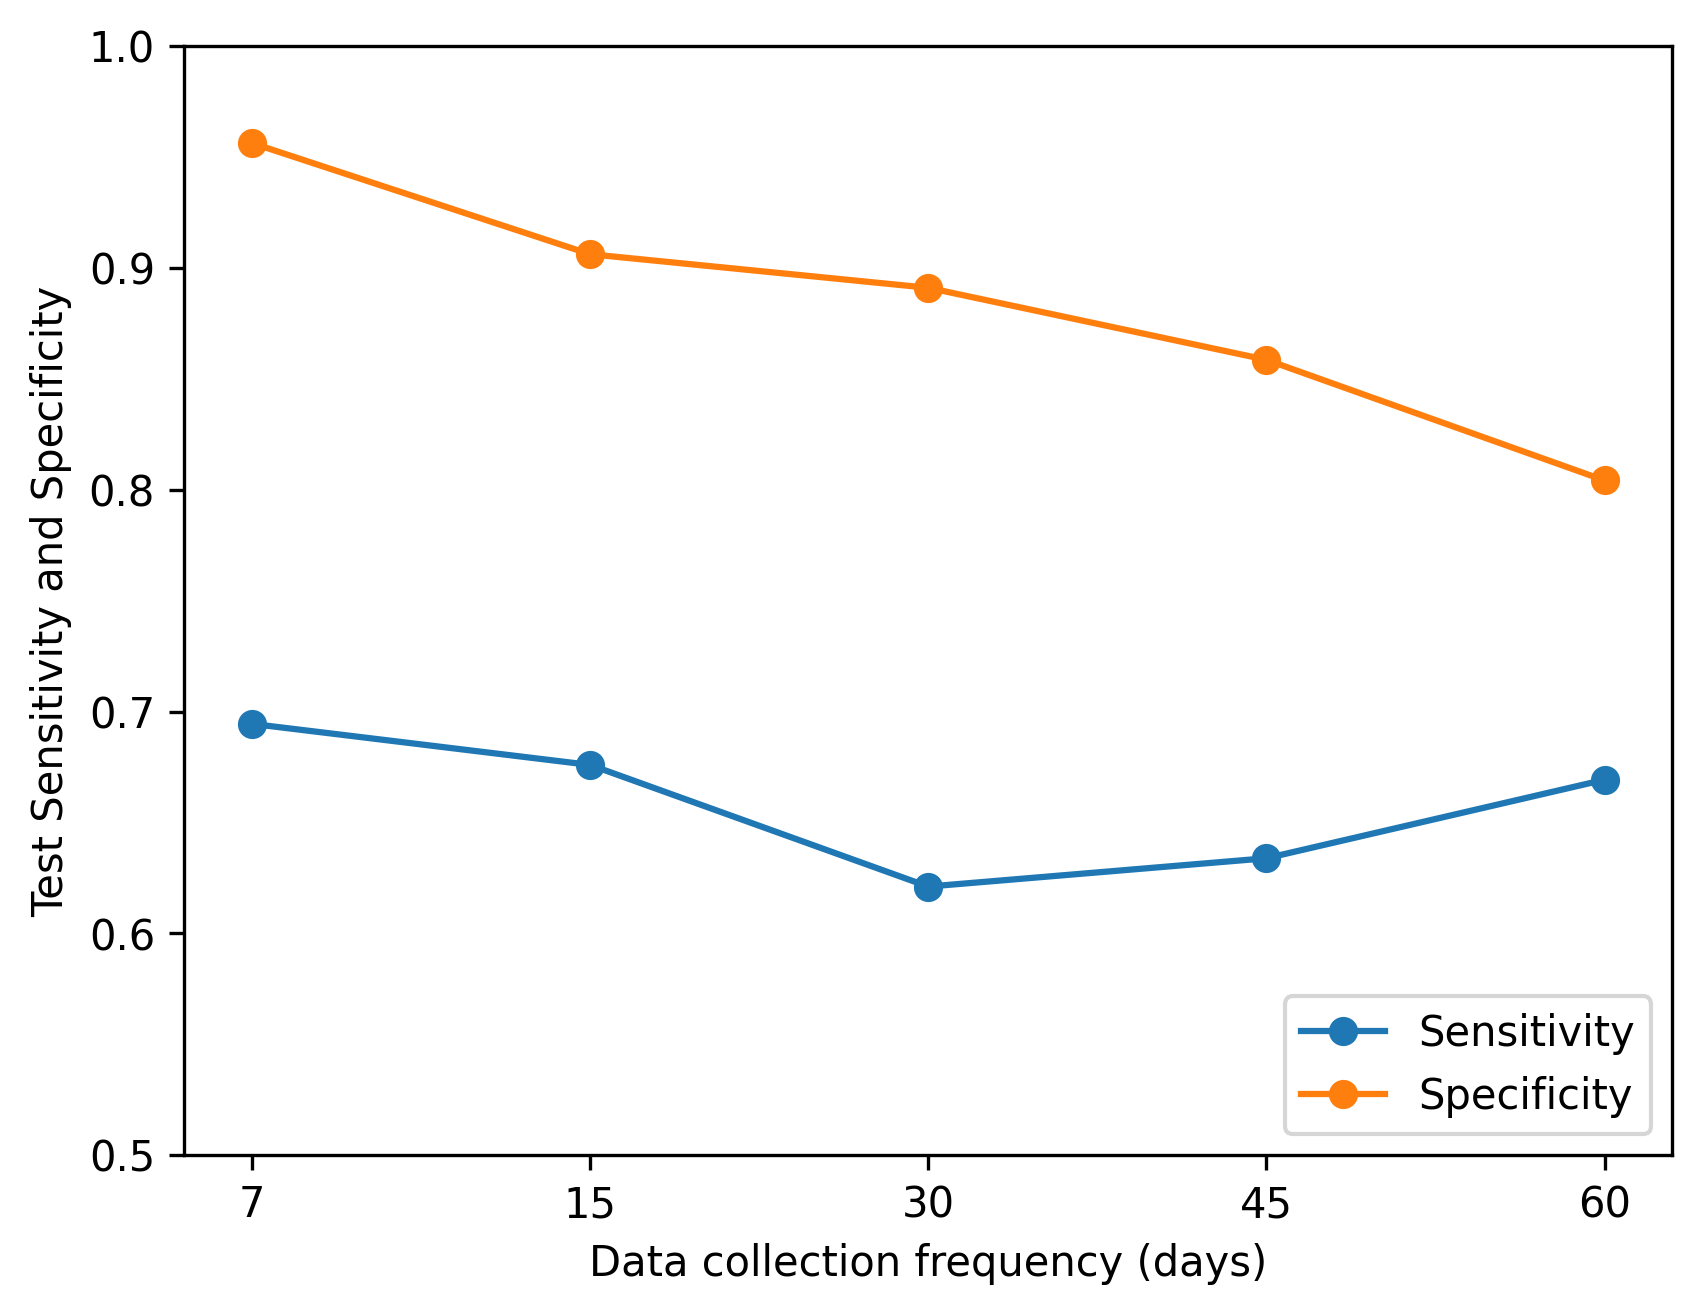

In [24]:

plt.plot (days_list_plot_text, sens_arr[model_type].values (), marker = "o", label = "Sensitivity");
plt.plot (days_list_plot_text, spec_arr[model_type].values (), marker = "o", label = "Specificity");
plt.xlabel ("Data collection frequency (days)");
plt.ylabel ("Test Sensitivity and Specificity");
# plt.title ("Change of Test Sensitivity and Specificity with data collection frequency");
plt.legend (loc = "lower right");
plt.ylim ([0.5, 1.0]);
plt.show ();


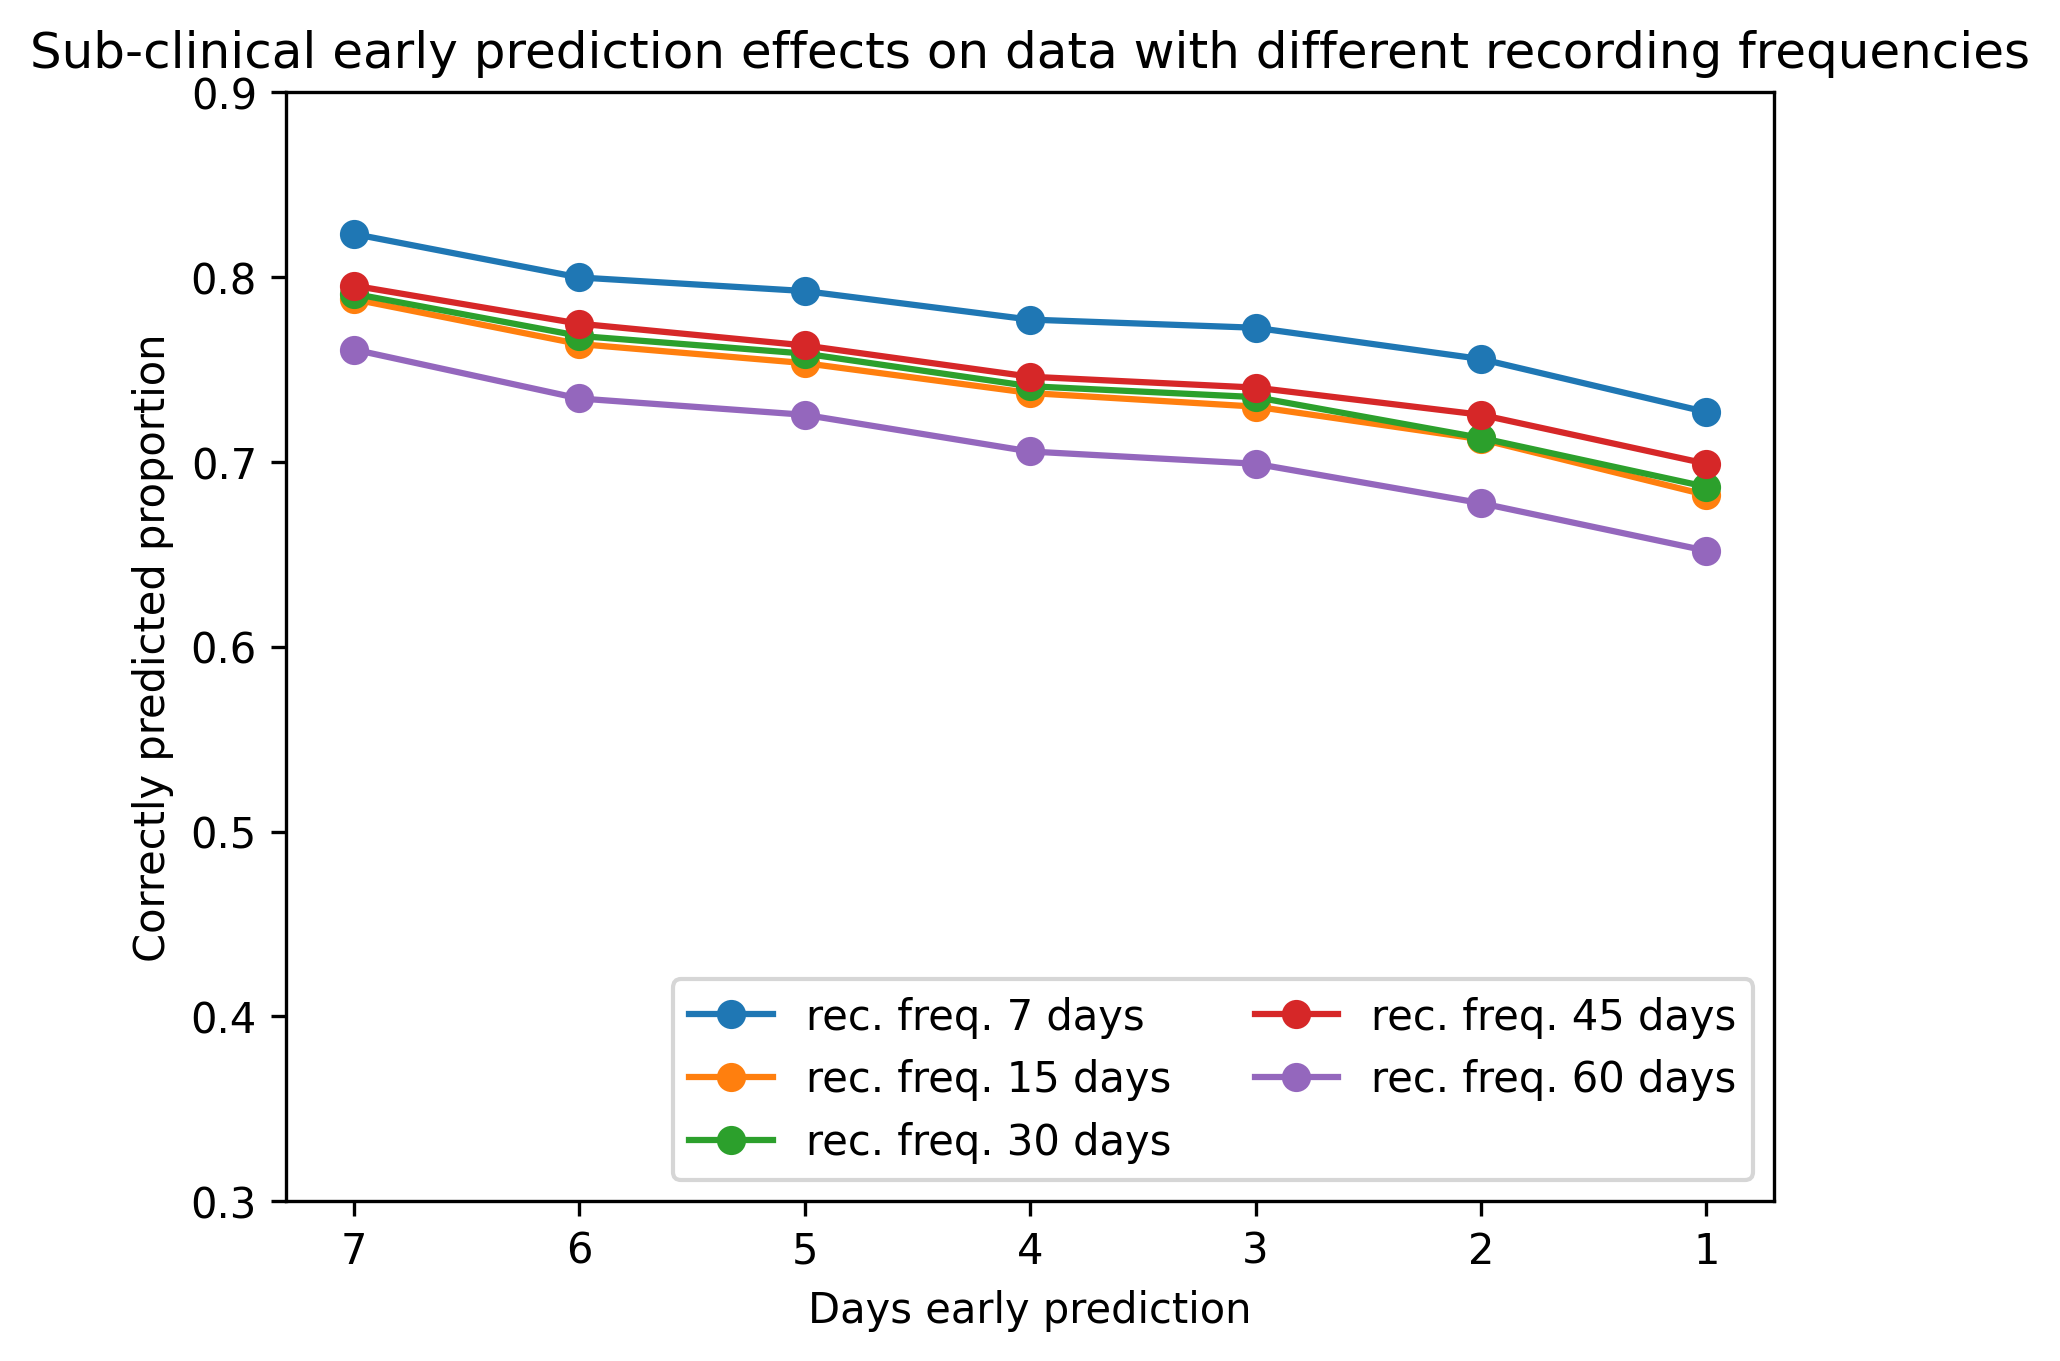

In [170]:

for days in days_list:
    days_str = days if days != "0" else "7";
    plt.plot (["7", "6", "5", "4", "3", "2", "1"], prop_df[days], marker = "o", label = "rec. freq. " + days_str + " days");
    
plt.xlabel ("Days early prediction");
plt.ylabel ("Correctly predicted proportion");
plt.title ("Sub-clinical early prediction effects on data with different recording frequencies");
plt.legend (loc = "lower right", ncol = 2);
plt.ylim ([0.3, 0.9]);
plt.show ();


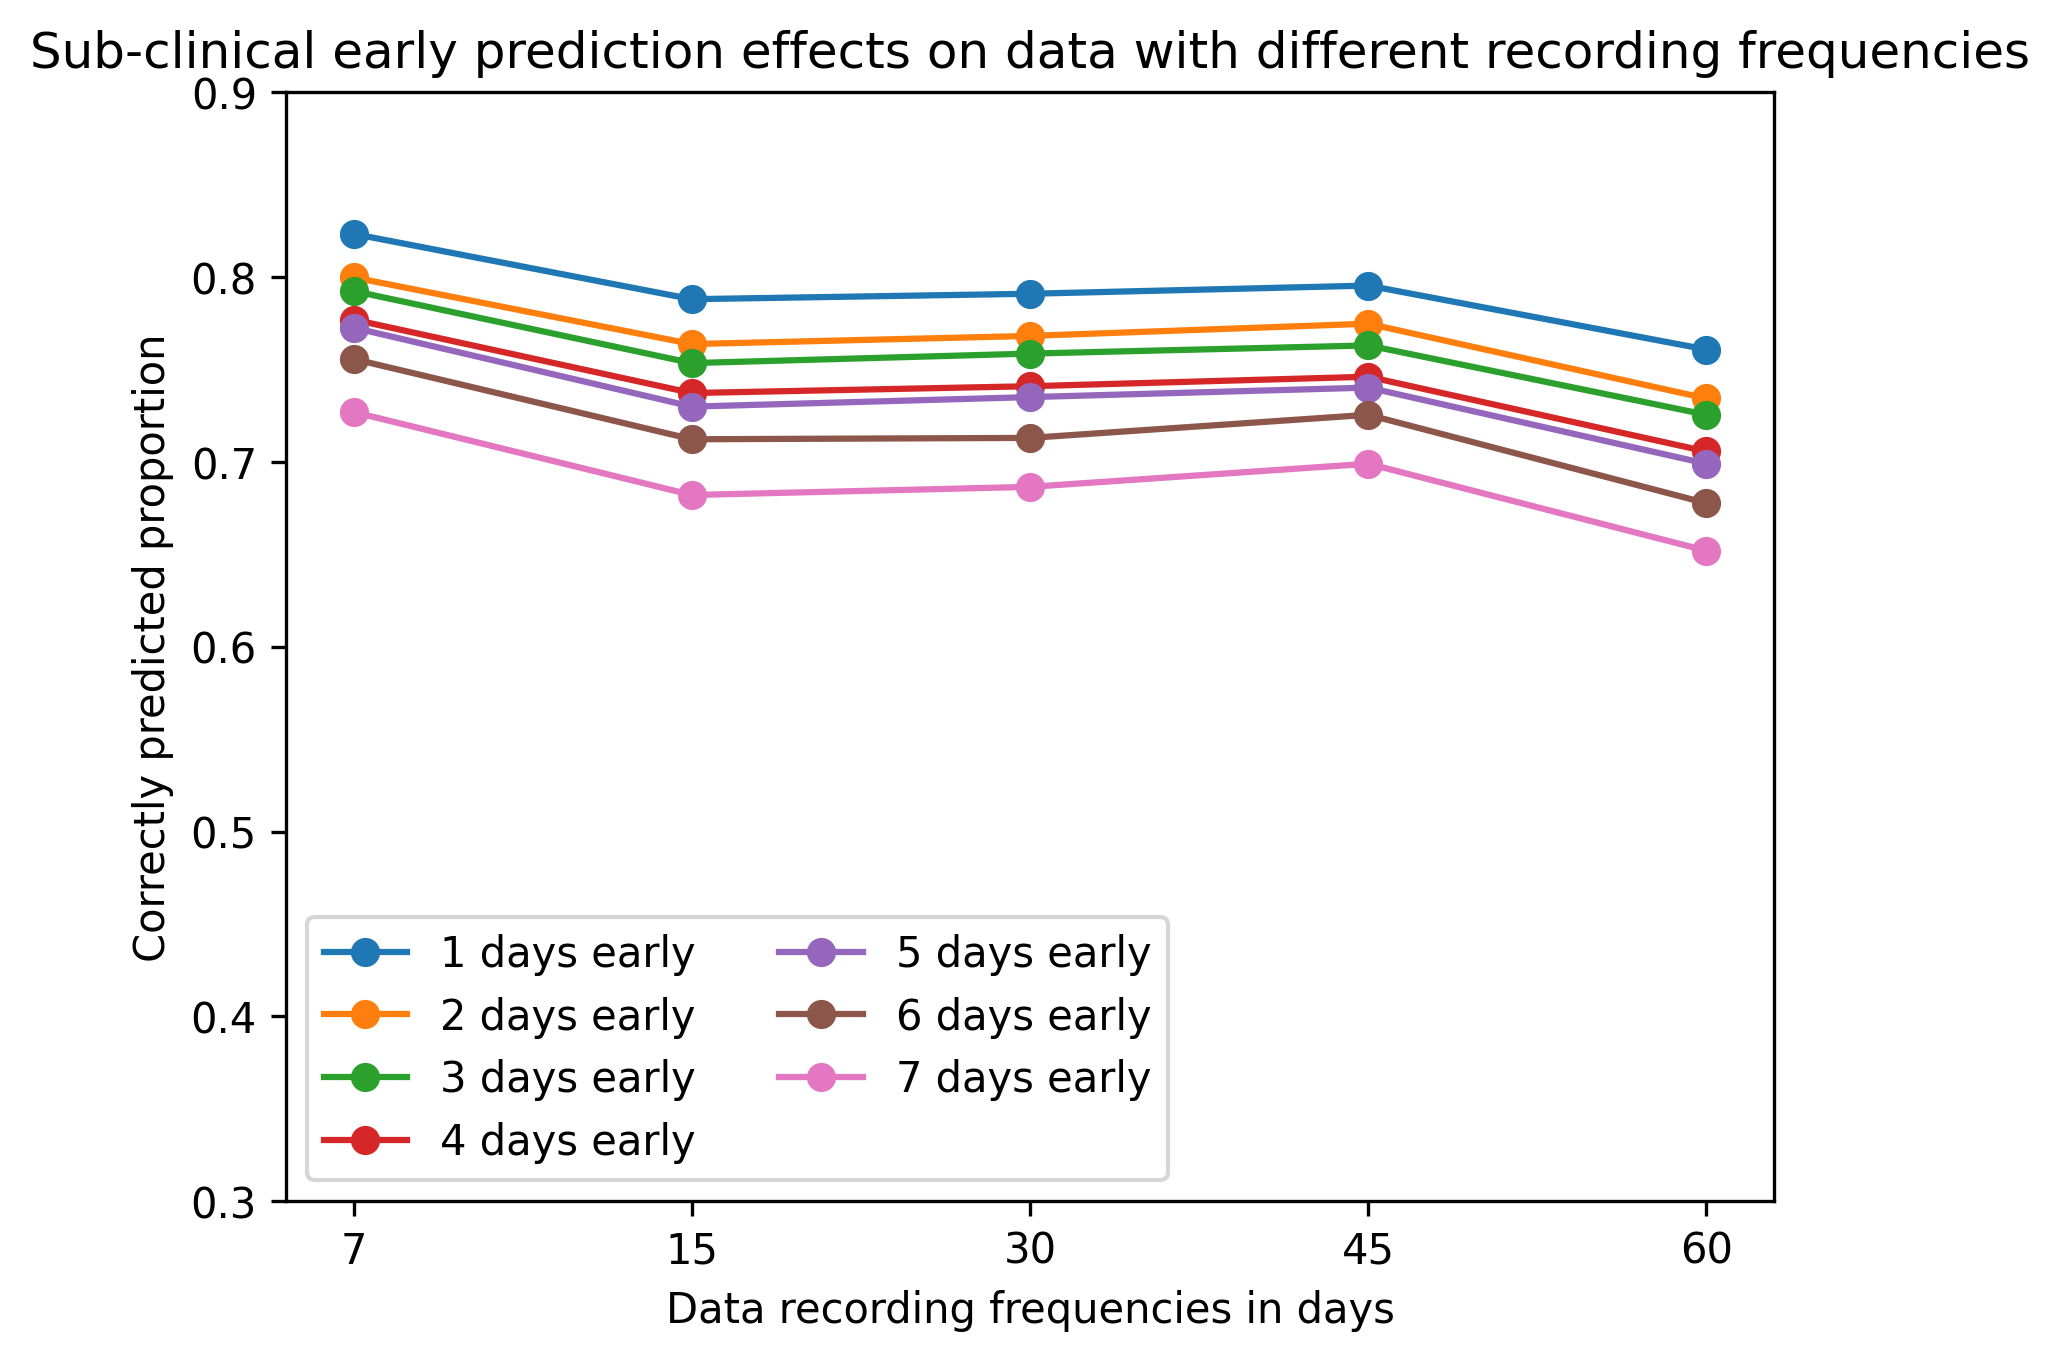

In [171]:

for i in range (7):
    days_str = str (i + 1);
    plt.plot (days_list_plot_text, prop_df.loc[i,], marker = "o", label = days_str + " days early");
    
plt.xlabel ("Data recording frequencies in days");
plt.ylabel ("Correctly predicted proportion");
plt.title ("Sub-clinical early prediction effects on data with different recording frequencies");
plt.legend (loc = "lower left", ncol = 2);
plt.ylim ([0.3, 0.9]);
plt.show ();



/home/phoxis/.local/lib/python3.8/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/home/phoxis/.local/lib/python3.8/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/home/phoxis/.local/lib/python3.8/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be remove

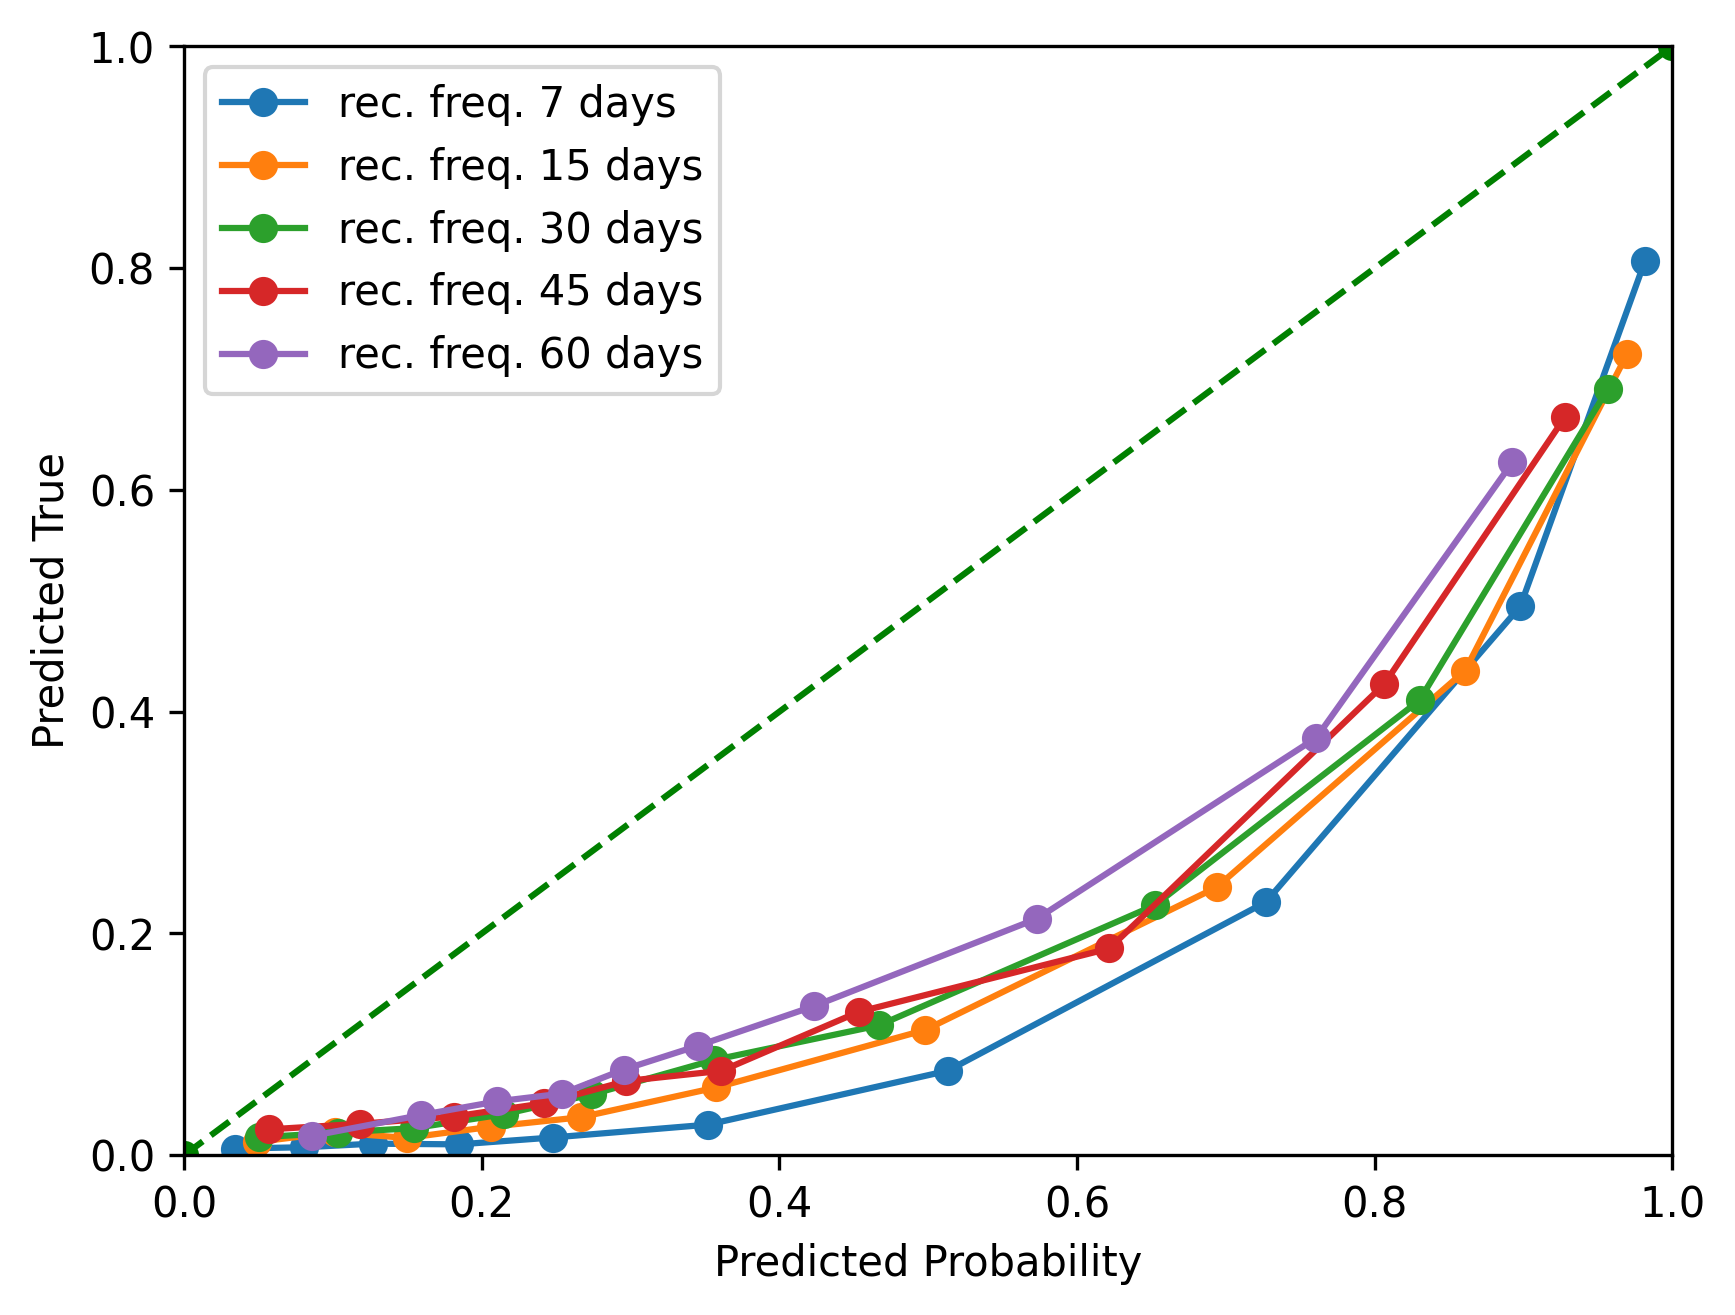

In [172]:

for days in days_list:
    days_str = days if days != "0" else "7";
    pred_info = pd.read_csv (f'{ptype}_{str (days)}_pred_info.csv');
    prob_true, prob_pred = calibration_curve (pred_info[target_var], pred_info["pred_prob"], n_bins = 10, strategy = "quantile", normalize = True);
    plt.plot (prob_pred, prob_true, marker = "o", label = "rec. freq. " + days_str + " days");
    
plt.plot ([0, 1], [0, 1], "go--");
plt.xlabel ("Predicted Probability");
plt.ylabel ("Predicted True");   
plt.xlim ([0.0, 1.0]);
plt.ylim ([0.0, 1.0]);
plt.legend (loc = "upper left");


In [26]:
trans = {};

trans["1_scc"] = "SCC";
trans["days_since_calving"] = "Days since calving";
trans["max_1_scc_last_30_days"] = "Max SCC in last 30 days";
trans["mean_1_scc_last_30_days"] = "Mean SCC in last 30 days";
trans["parity"] = "Parity";
trans["infections_per_parity_sub_clin"] = "Subclinical cases per parity";
trans["max_1_scc_last_15_days"] = "Max SCC in last 15 days";
trans["min_1_scc_last_30_days"] = "Min SCC in last 30 days";
trans["PTA_mean"] = "PTA";
trans["std_1_scc_last_30_days"] = "Standard deviation of SCC in last 30 days";
trans["med_1_scc_last_15_days"] = "Median SCC in last 15 days";
trans["min_1_scc_last_15_days"] = "Min SCC in last 15 days";
trans["med_1_scc_last_30_days"] = "Median SCC in last 30 days";
trans["infections_per_cow_sub_clin"] = "Subclinical cases per cow";
trans["delta_1_scc_last_15_days"] = "Delta of SCC in last 15 days";
trans["month_of_milking"] = "Month of milking";
trans["std_1_yield_last_30_days"] = "Standard deviation of AM yield in last 30 days";
trans["std_2_max_flow_last_30_days"] = "Standard deviation of PM maximum milk flow in last 30 days";
trans["mean_1_scc_last_15_days"] = "Mean SCC in last 15 days";
trans["delta_1_scc_last_30_days"] = "Delta of SCC in last 30 days";


Loading modelsubclin_0_days_model.joblib
[16:21:49] WARNING: ../src/learner.cc:1203: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[16:21:49] WARNING: ../src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[16:21:49] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorial

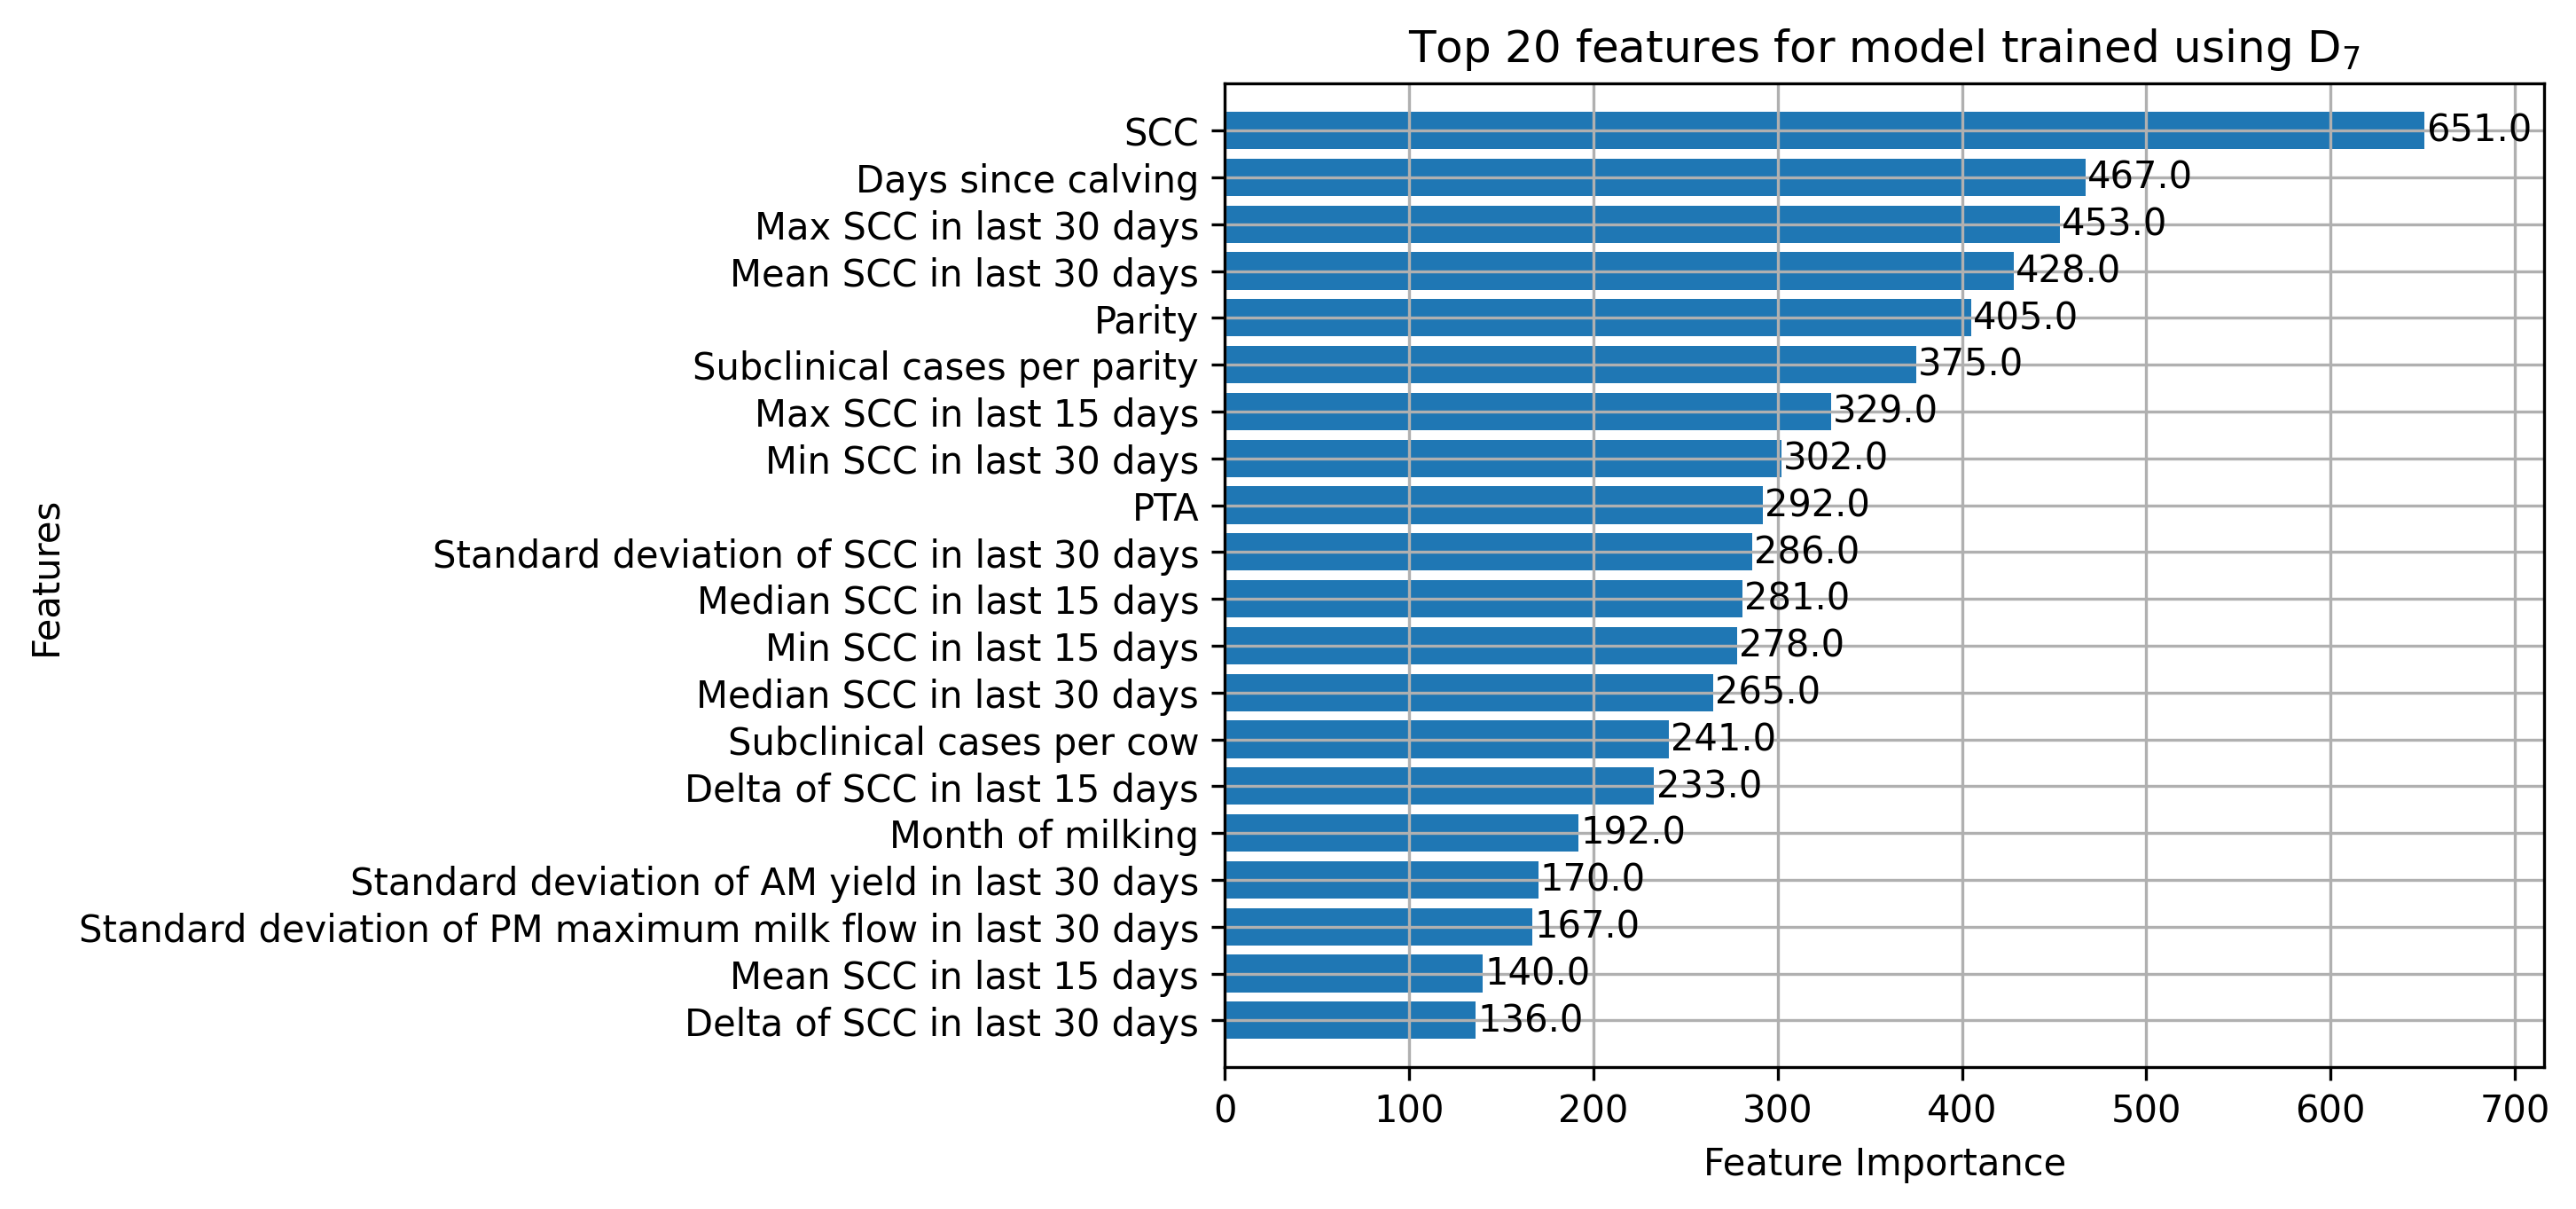

Loading modelsubclin_15_days_model.joblib
[16:21:50] WARNING: ../src/learner.cc:1203: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[16:21:50] WARNING: ../src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[16:21:50] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutoria

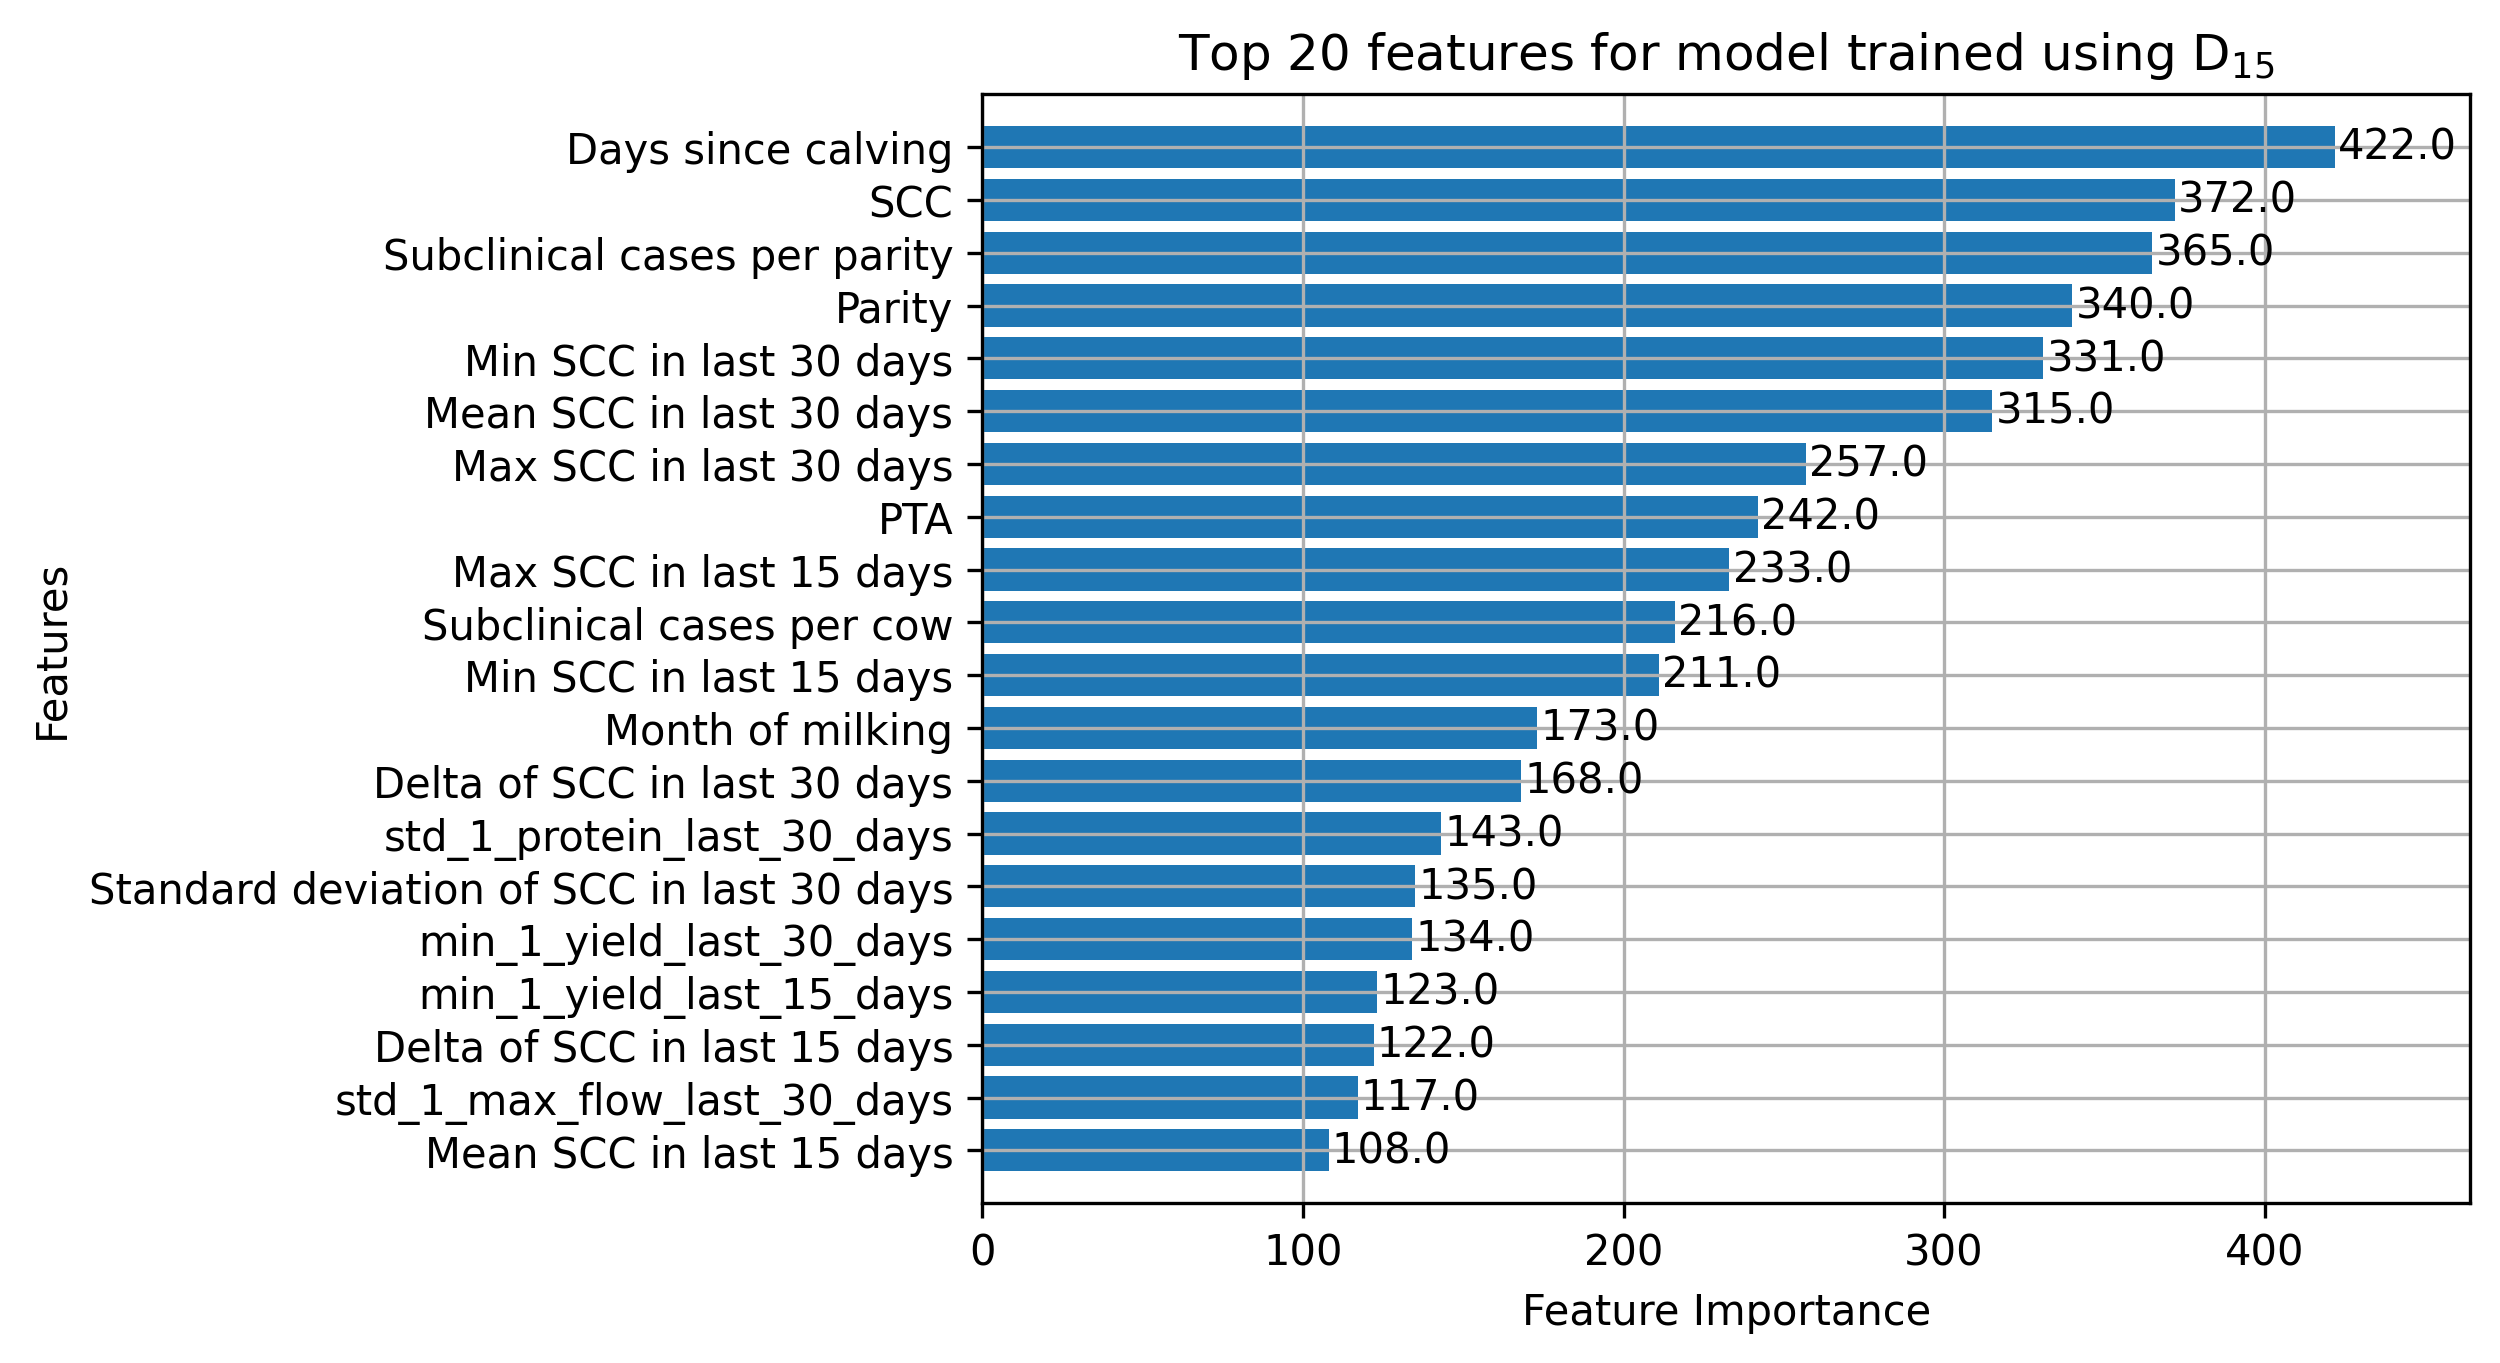

Loading modelsubclin_30_days_model.joblib
[16:21:50] WARNING: ../src/learner.cc:1203: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[16:21:50] WARNING: ../src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[16:21:50] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutoria

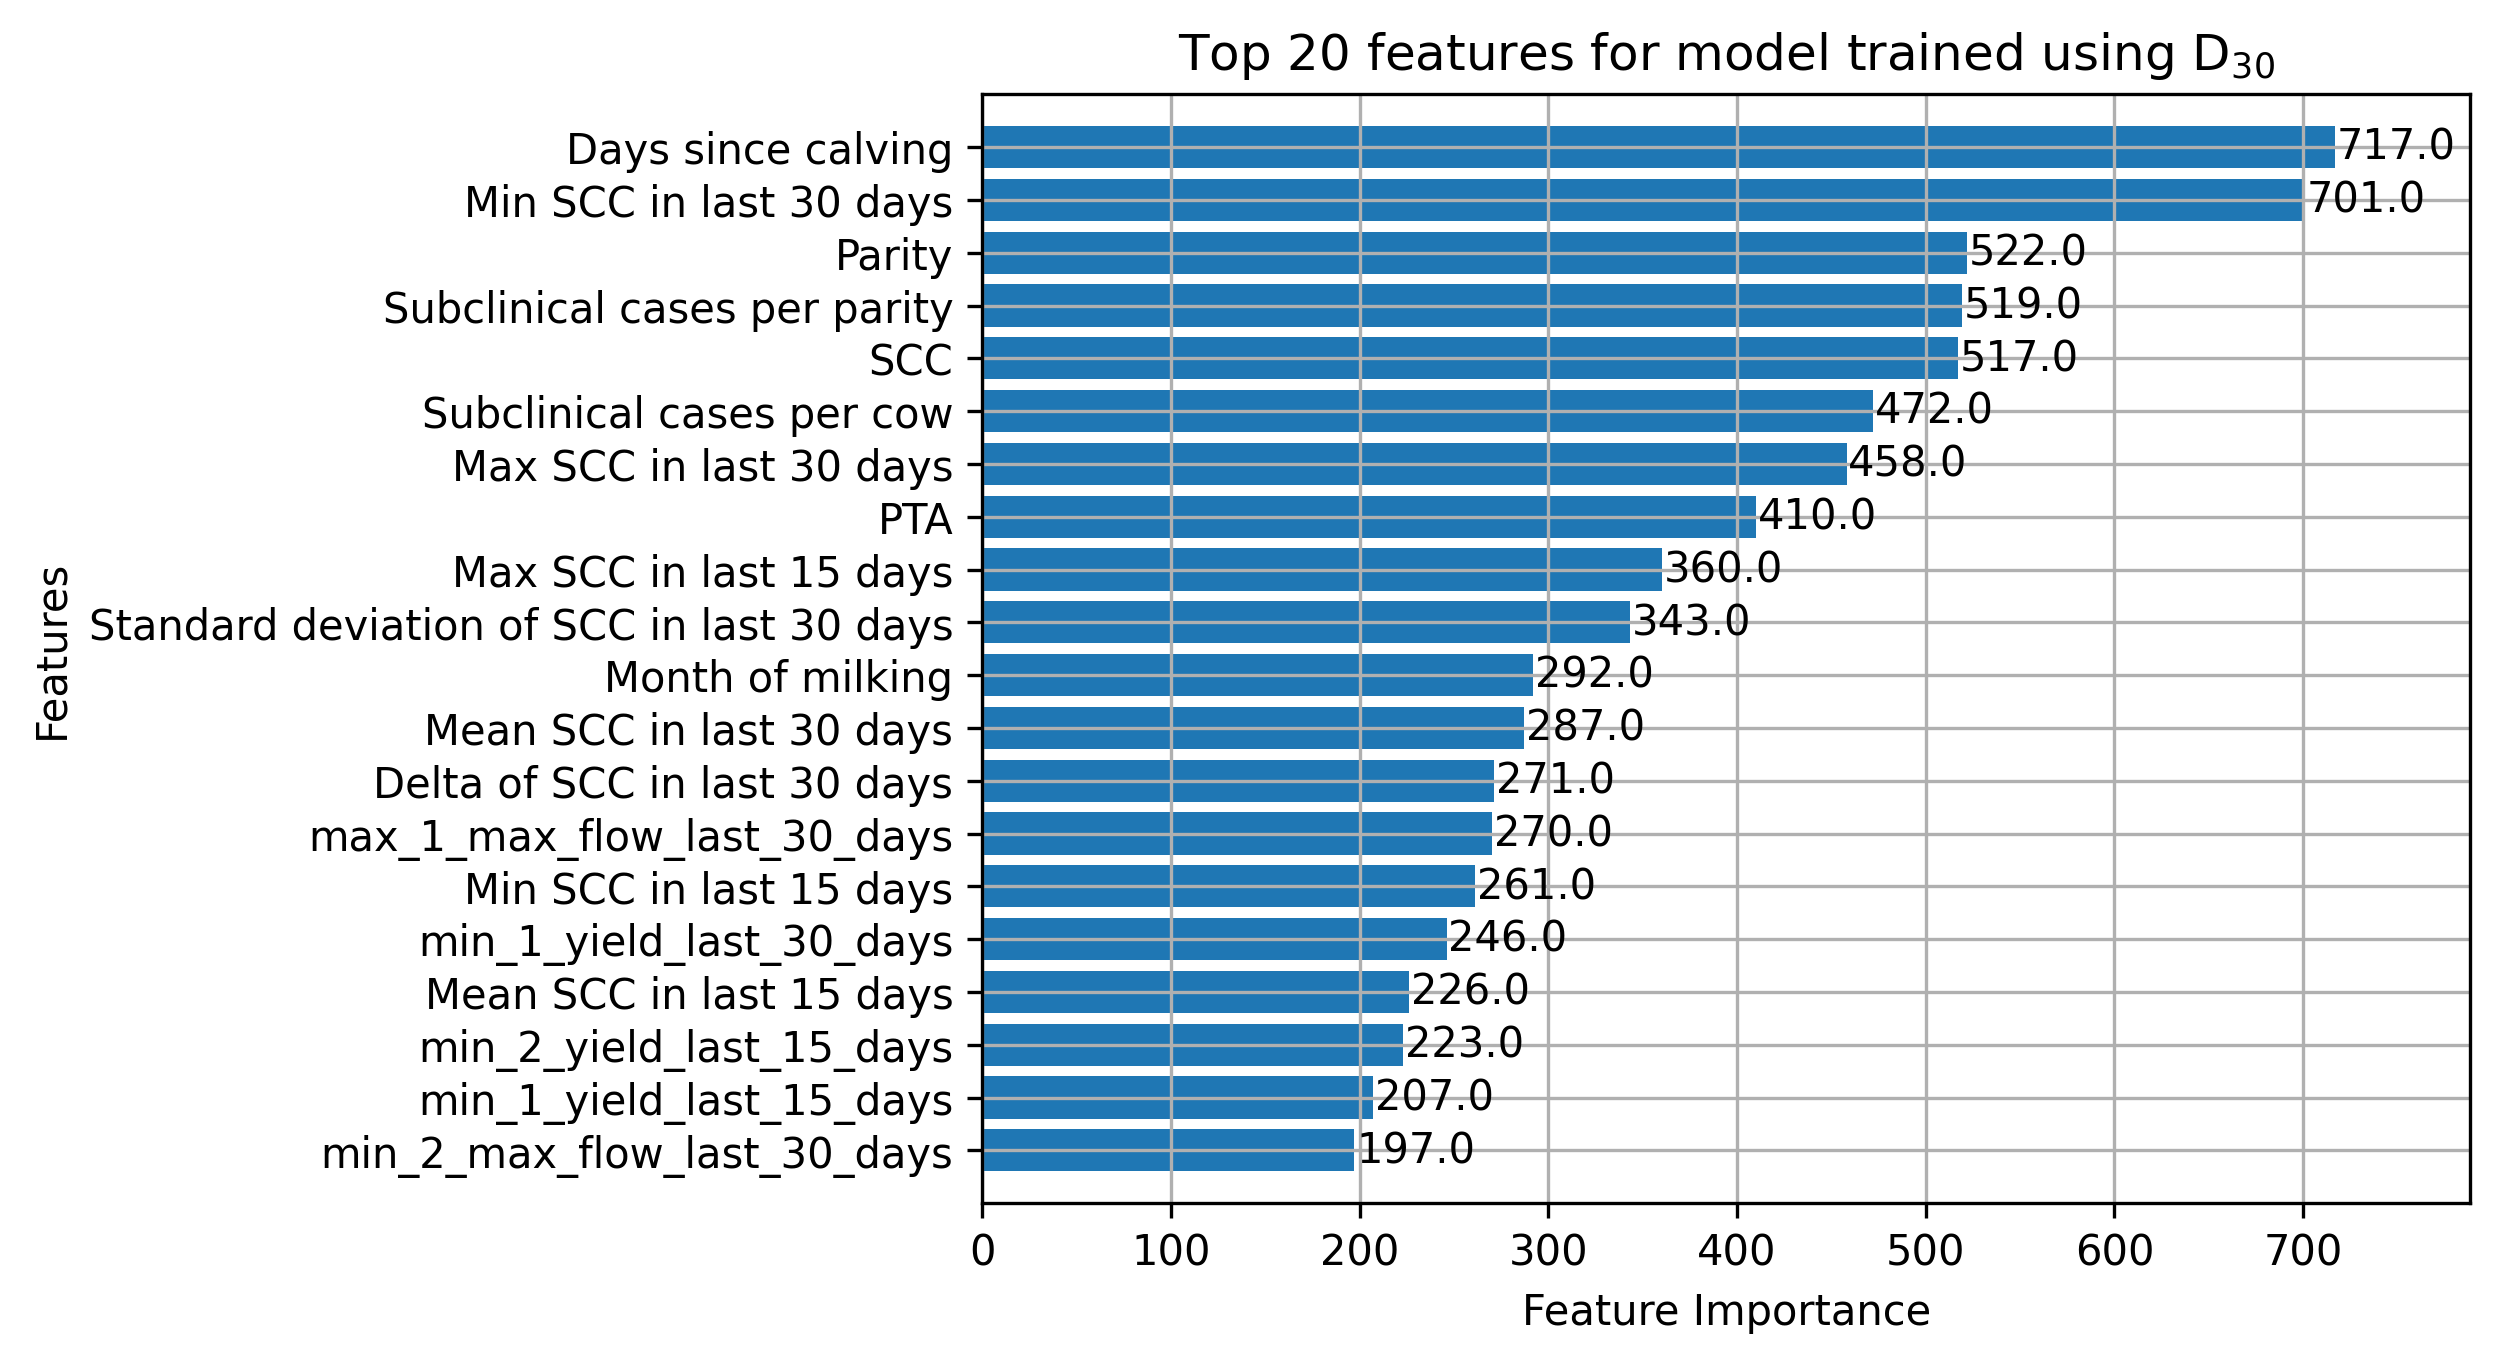

Loading modelsubclin_45_days_model.joblib
[16:21:51] WARNING: ../src/learner.cc:1203: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[16:21:51] WARNING: ../src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[16:21:51] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutoria

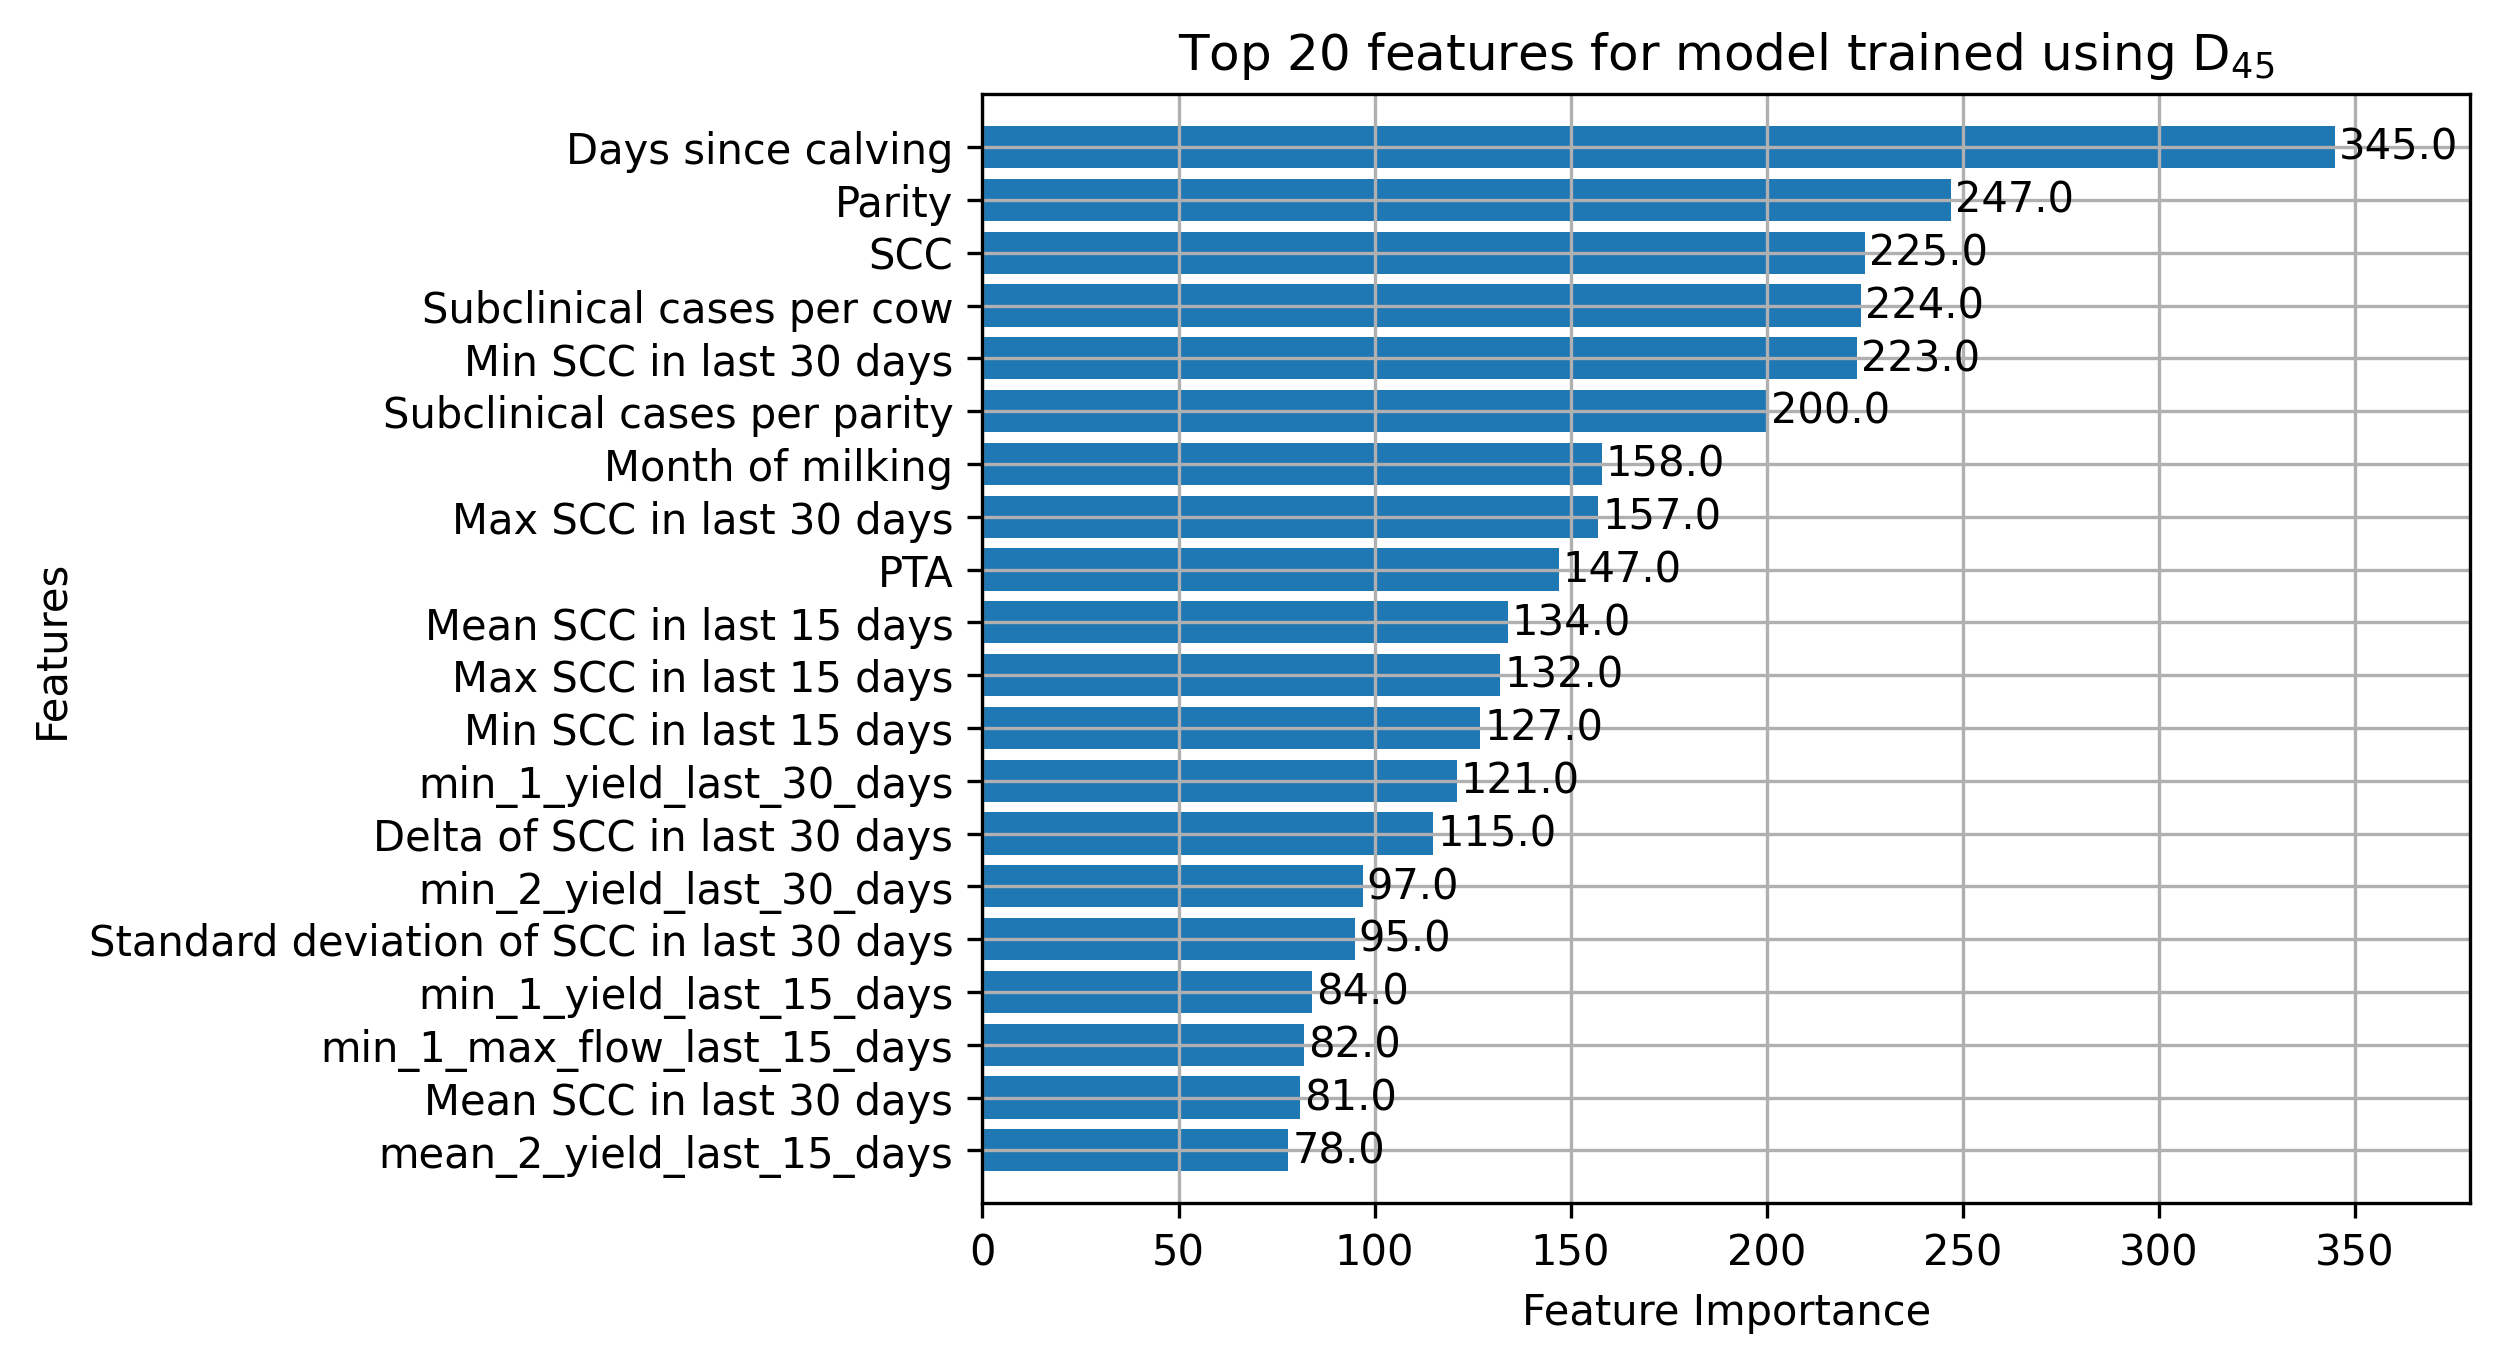

Loading modelsubclin_60_days_model.joblib
[16:21:51] WARNING: ../src/learner.cc:1203: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[16:21:51] WARNING: ../src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[16:21:51] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutoria

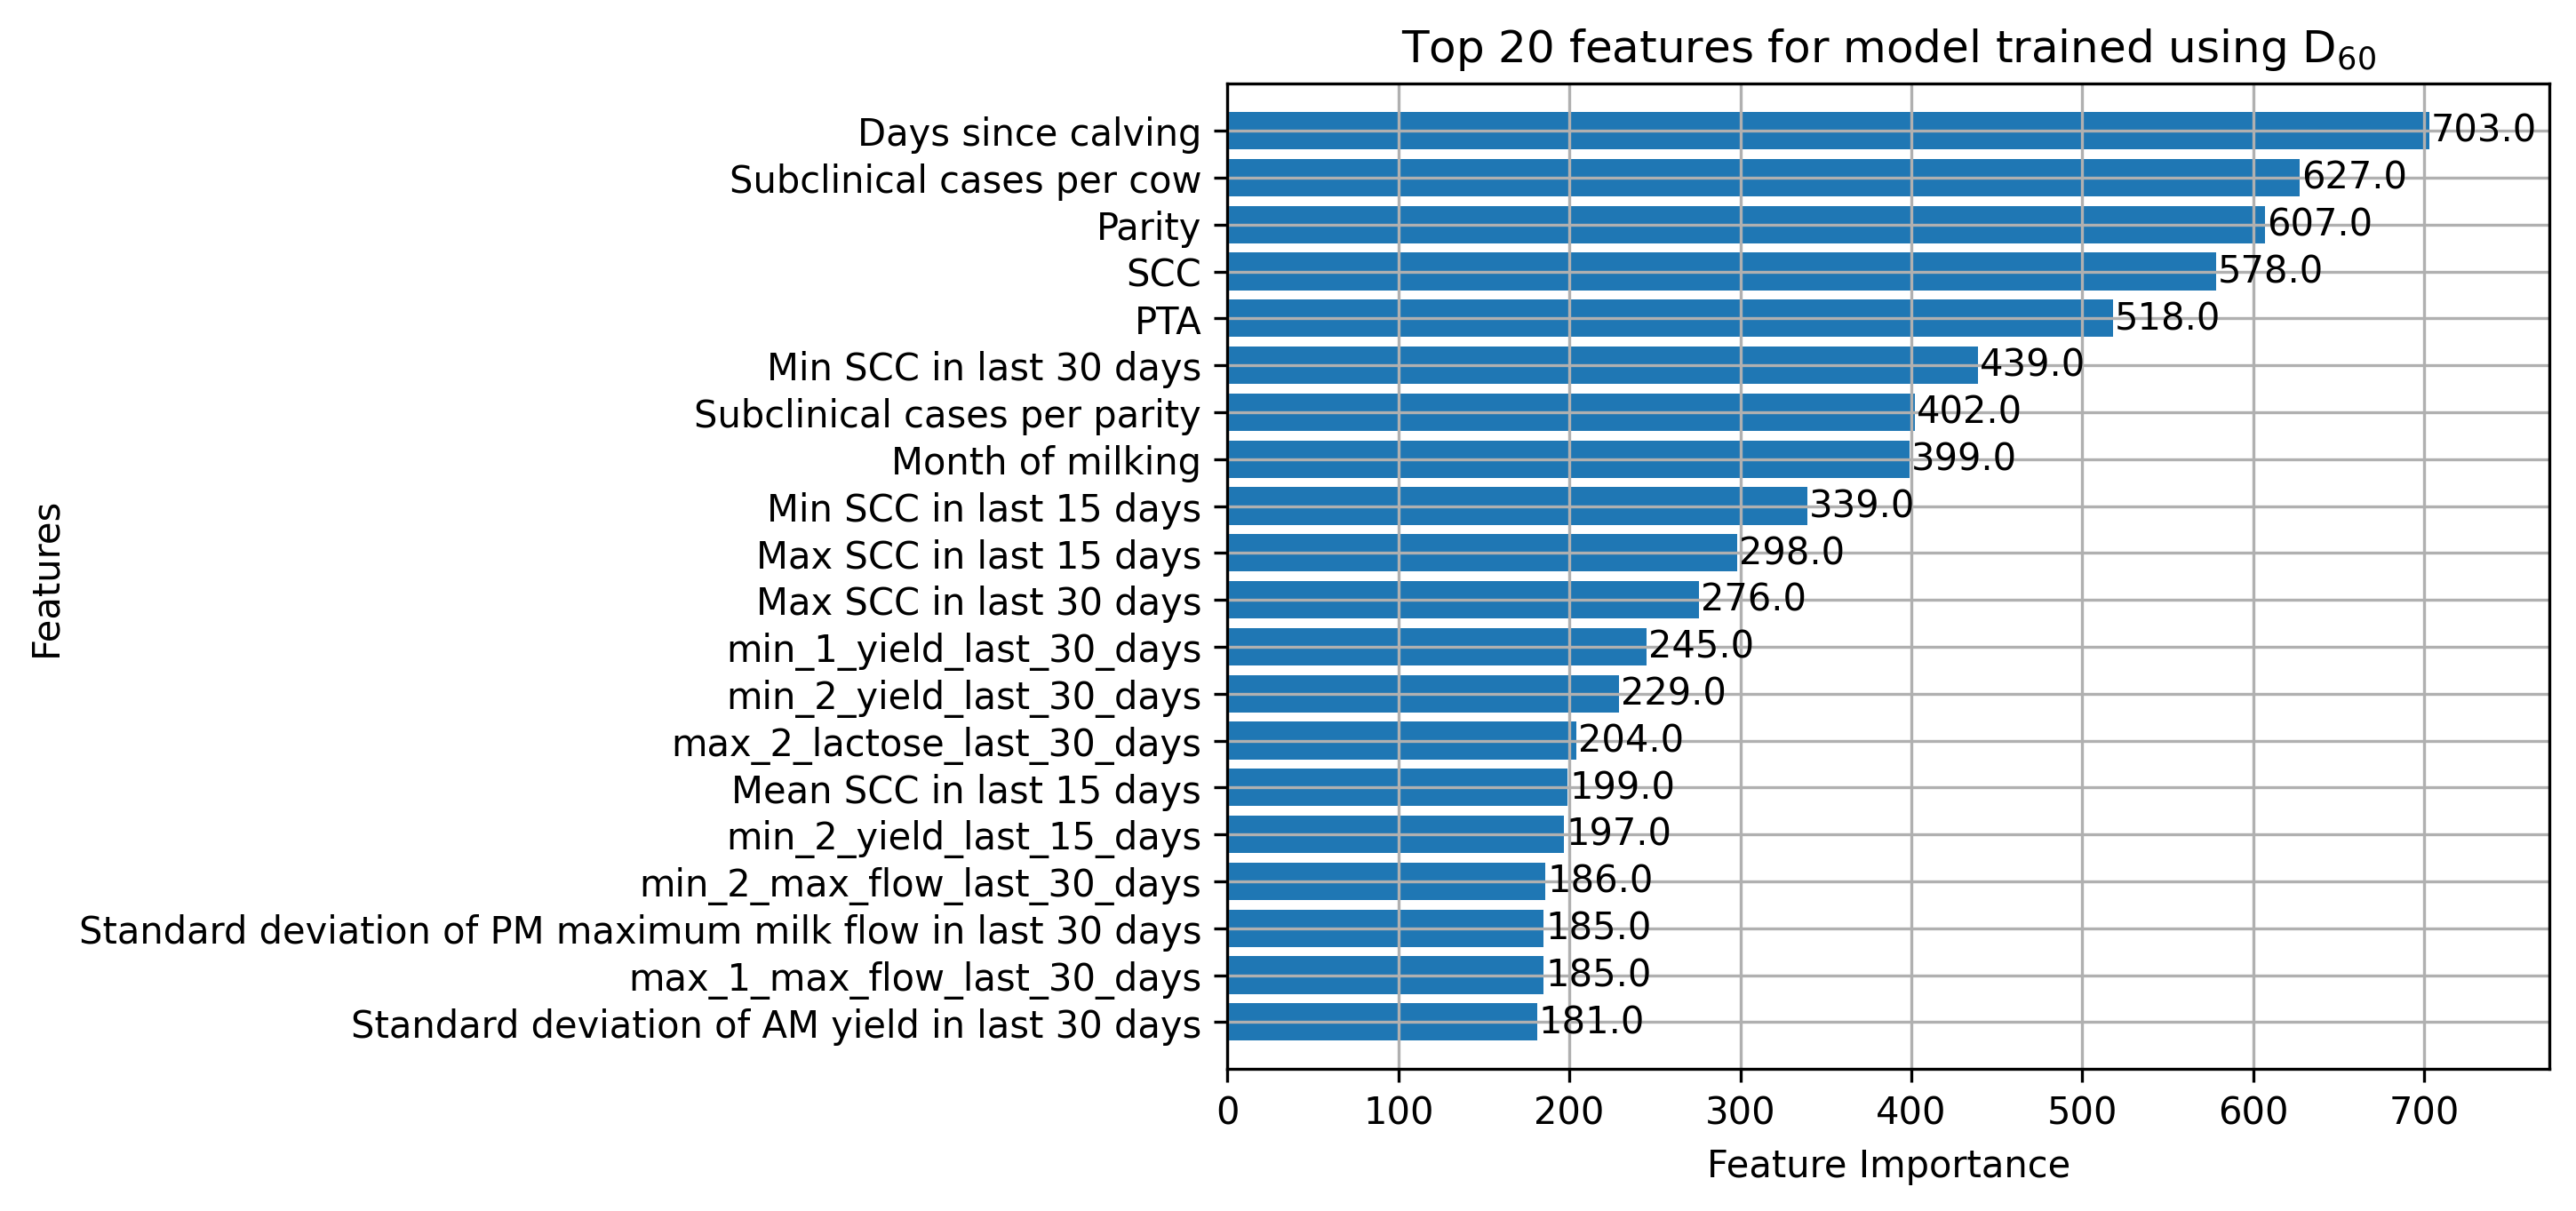

In [27]:
columns = []
for item in ['1_fat', '2_fat', '1_yield', '2_yield', '1_max_flow', 
          '2_max_flow', '1_protein', '2_protein', '1_urea', '2_urea', 
          '1_lactose', '2_lactose', '1_scc', '2_weight', '2_BCS']:
  columns.append(item)    
  for feature in ['max', 'min', 'std', 'skew', 'mean', 'med', 'delta']:
      for time in ['15', '30']:
              columns.append(feature + '_' + item + '_last_' + time + '_days')


for item in ['parity', 'days_since_calving', 'PTA_mean',
'infections_per_parity_sub_clin', 'infections_per_cow_sub_clin',
'days in milk', 'month_of_milking']:
  columns.append(item);

var_rank = pd.DataFrame (columns = columns)
varimp_hash = dict.fromkeys (columns);
for this_key in varimp_hash.keys ():
    varimp_hash[this_key] = [];
    
for ptype in [model_type]:
    for days in days_list:
        
        model_path = f'{ptype}_{days}_days_model.joblib'
        print ("Loading model" + model_path)
        model = joblib.load (model_path);
        days_str = days if days != "0" else "7";
        
        model_this = model.get_booster ();
        model_vars = model_this.feature_names.copy ();
        for i in range (len (model_vars)):
            if model_this.feature_names[i] in trans.keys (): 
                model_vars[i] = trans[model_this.feature_names[i]];
                
        model_this.feature_names = model_vars.copy ();

        xgb.plot_importance (model_this, max_num_features = 20, height = 0.8, importance_type = "weight")
        tmp_str = str (days_str);
        plt.title ('Top 20 features for model trained using ' + f"$\mathregular" + "{" + "D_{" + f"{tmp_str}" + "}}$");
        plt.xlabel ('Feature Importance')
        plt.show ()
        
        #varimp_scores = model.get_booster().get_fscore ();
        #sorted_vals = sorted(varimp_scores.items(), key=operator.itemgetter(1), reverse = True)
        #sorted_vals = sorted_vals[1:20]
        #for this_val in sorted_vals:
        #    varimp_hash[this_val[0]].append (varimp_scores[this_val[1]]);
        
        
        

# Daily averaged confusion matrix over months

Run this to see the daily averaged confusion matrix over each month of the test set. This means, for example, we generate daily confusion matrix for the month of March and then average the confusion matrices.

In [29]:
ptype = model_type; # Denotes sub-clinical
top_n = 0.1        # 1.0 is top 100 percent, to see top 10% confusion matrix, use 0.1
date_ranges = {"Jan": {"start": "2020-01-01", "end": "2020-01-31"},
               "Feb": {"start": "2020-02-01", "end": "2020-02-28"},
               "Mar": {"start": "2020-03-01", "end": "2020-03-31"},
               "Apr": {"start": "2020-04-01", "end": "2020-04-30"},
               "May": {"start": "2020-05-01", "end": "2020-05-31"},
               "Jun": {"start": "2020-06-01", "end": "2020-06-30"},
               "Jul": {"start": "2020-07-01", "end": "2020-07-31"},
               "Aug": {"start": "2020-08-01", "end": "2020-08-31"},
               "Sep": {"start": "2020-09-01", "end": "2020-09-30"},
               "Oct": {"start": "2020-10-01", "end": "2020-10-31"},
               "Nov": {"start": "2020-11-01", "end": "2020-11-30"},
               "Dec": {"start": "2020-12-01", "end": "2020-12-31"},
              }

In [30]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [31]:
def scc_offset (cow):
    for i in cow.index:
        this_future_date = cow.loc[i,"date"] + pd.DateOffset (days = +7);
        date_match = cow["date"] == this_future_date;
        this_scc = float ("nan");
        if np.sum (date_match) > 0:
            this_scc = cow[date_match]["1_scc"];
        cow.loc[i,"1_scc_future"] = float (this_scc);
    #     print (cow[["date", "1_scc", "1_scc_future"]])
    return cow;

In [32]:
# FIXME: Make this fast and process for each data recording freqiency
# Adds a column which is just a 7 day offset of 1_scc. This way we can easily plot the 1_scc distribution of the future
pred_info_all = {};
for days in days_list:
    print ("days = ", days);
    pred_info = pd.read_csv (f'{ptype}_{str (days)}_pred_info.csv');
#     pred_info["1_scc"] = df_test["1_scc"];
    pred_info.date = pd.to_datetime (pred_info.date);
    if "1_scc_future" in pred_info.columns:
        pred_info_all[days] = pred_info;
        print ("Not recomputing 1_scc_future columns");
        continue;
        
    pred_info["1_scc_future"] = None;
    # pred_info = pred_info.groupby ("id").progress_apply (scc_offset);
    pred_info = pred_info.groupby ("id").apply (scc_offset);
    pred_info.to_csv (f'{ptype}_{str (days)}_pred_info.csv');
    

days =  0
Not recomputing 1_scc_future columns
days =  15
Not recomputing 1_scc_future columns
days =  30
Not recomputing 1_scc_future columns
days =  45
Not recomputing 1_scc_future columns
days =  60
Not recomputing 1_scc_future columns


In [33]:
for days in days_list:
    pred_info_all[days] = pred_info_all[days][pred_info_all[days]["days_since_calving"]>10];

In [34]:
# Extract "days" recording freq. data corresponding "month" 's daily confusion matrix in "retval_list"
retval_list = {};
#df_test = pd.read_csv ("~/test.csv");

for days in days_list:
    retval = {};
#     pred_info = pd.read_csv (f'{ptype}_{str (days)}_pred_info.csv');
#     pred_info["1_scc"] = df_test["1_scc"];
    for month in date_ranges.keys ():
        retval[month] = daily_conf_mat (pred_info_all[str (days)], pd.date_range (start = date_ranges[month]["start"], end = date_ranges[month]["end"]), top_n, ["1_scc", "1_scc_future"]);

    retval_list[days] = retval;

/tmp/ipykernel_14683/3330250893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_info["date"] = pd.to_datetime (pred_info["date"]);
/tmp/ipykernel_14683/3330250893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_info["date"] = pd.to_datetime (pred_info["date"]);
/tmp/ipykernel_14683/3330250893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [35]:
# tmp = list (map (lambda x: x, retval_list["0"]["Aug"]["attdist"]["1_scc"].values ()))
# print (len (tmp[0]))
# tp_all = pd.concat (list (map (lambda x: x[0], tmp)))
# tp_all
#retval_list["0"]["Aug"]["attdist"]["1_scc"]["2020-08-01"]
# pred_info.head ()

In [36]:
# Use "retval_list" to compute daily average over the month and save in "retval_list_summary".
# "retval_list_summary[days][month]" is the data with "days" recording frequency's daily averaged confusion matrix over the month "month".

retval_list_summary = {};
retval_var_summary = {}
for days in days_list:
    retval_list_summary[days] = {};
    retval_var_summary[days] = {};
    for month in date_ranges.keys ():
        this_month_confusion_matrix = sum (retval_list[days][month]["cm"].values ());
        this_month_entries          = len (retval_list[days][month]["cm"].keys ());
        retval_list_summary[days][month] = this_month_confusion_matrix / this_month_entries;
        retval_list_summary[days][month].name = month
        
        retval_var_summary[days][month] = {}
        for this_var in ["1_scc", "1_scc_future"]:
            retval_var_summary[days][month][this_var] = {}
            var_vals = list (map (lambda x: x, retval_list[days][month]["attdist"][this_var].values ()));
            retval_var_summary[days][month][this_var]["tp"] = pd.concat (list (map (lambda x: x[0], var_vals)))
            retval_var_summary[days][month][this_var]["tn"] = pd.concat (list (map (lambda x: x[1], var_vals)));
            retval_var_summary[days][month][this_var]["fp"] = pd.concat (list (map (lambda x: x[2], var_vals)));
            retval_var_summary[days][month][this_var]["fn"] = pd.concat (list (map (lambda x: x[3], var_vals)));
        
#         retval_list[days][month]
        
        
#display (retval_list_summary["0"]["Aug"])

In [37]:
# retval_var_summary["0"]["Aug"]["1_scc"]["tn"]
# tmp = list (retval_list[days][month]["attdist"][this_var].values ())
# tmp[0]

In [38]:
daily_pred_top_n = pd.DataFrame ();
this_df_true_healthy = pd.DataFrame ();
this_df_true_infected = pd.DataFrame ();
this_df_tpfp = {};
for days in days_list:
    this_df_top_n = pd.DataFrame ();
    for month in date_ranges.keys ():
        this_df_top_n = pd.concat ([this_df_top_n, retval_list_summary[days][month].iloc[:,1]], axis = 1, sort = False);
        #print (retval_list_summary[days][month].iloc[:,1])
        
    this_df_top_n = this_df_top_n.transpose ();
    this_df_top_n.index = date_ranges.keys ();
    this_df_tpfp[days] = this_df_top_n;

    this_df_true_healthy = pd.concat ([this_df_true_healthy, this_df_top_n.iloc[:,0]], axis = 1, sort = False);
    this_df_true_infected = pd.concat ([this_df_true_infected, this_df_top_n.iloc[:,1]], axis = 1, sort = False);

this_df_true_healthy.columns = days_list_plot_text;
this_df_true_infected.columns = days_list_plot_text;

Text(0, 0.5, 'Average Count of top 10.0% Pred')

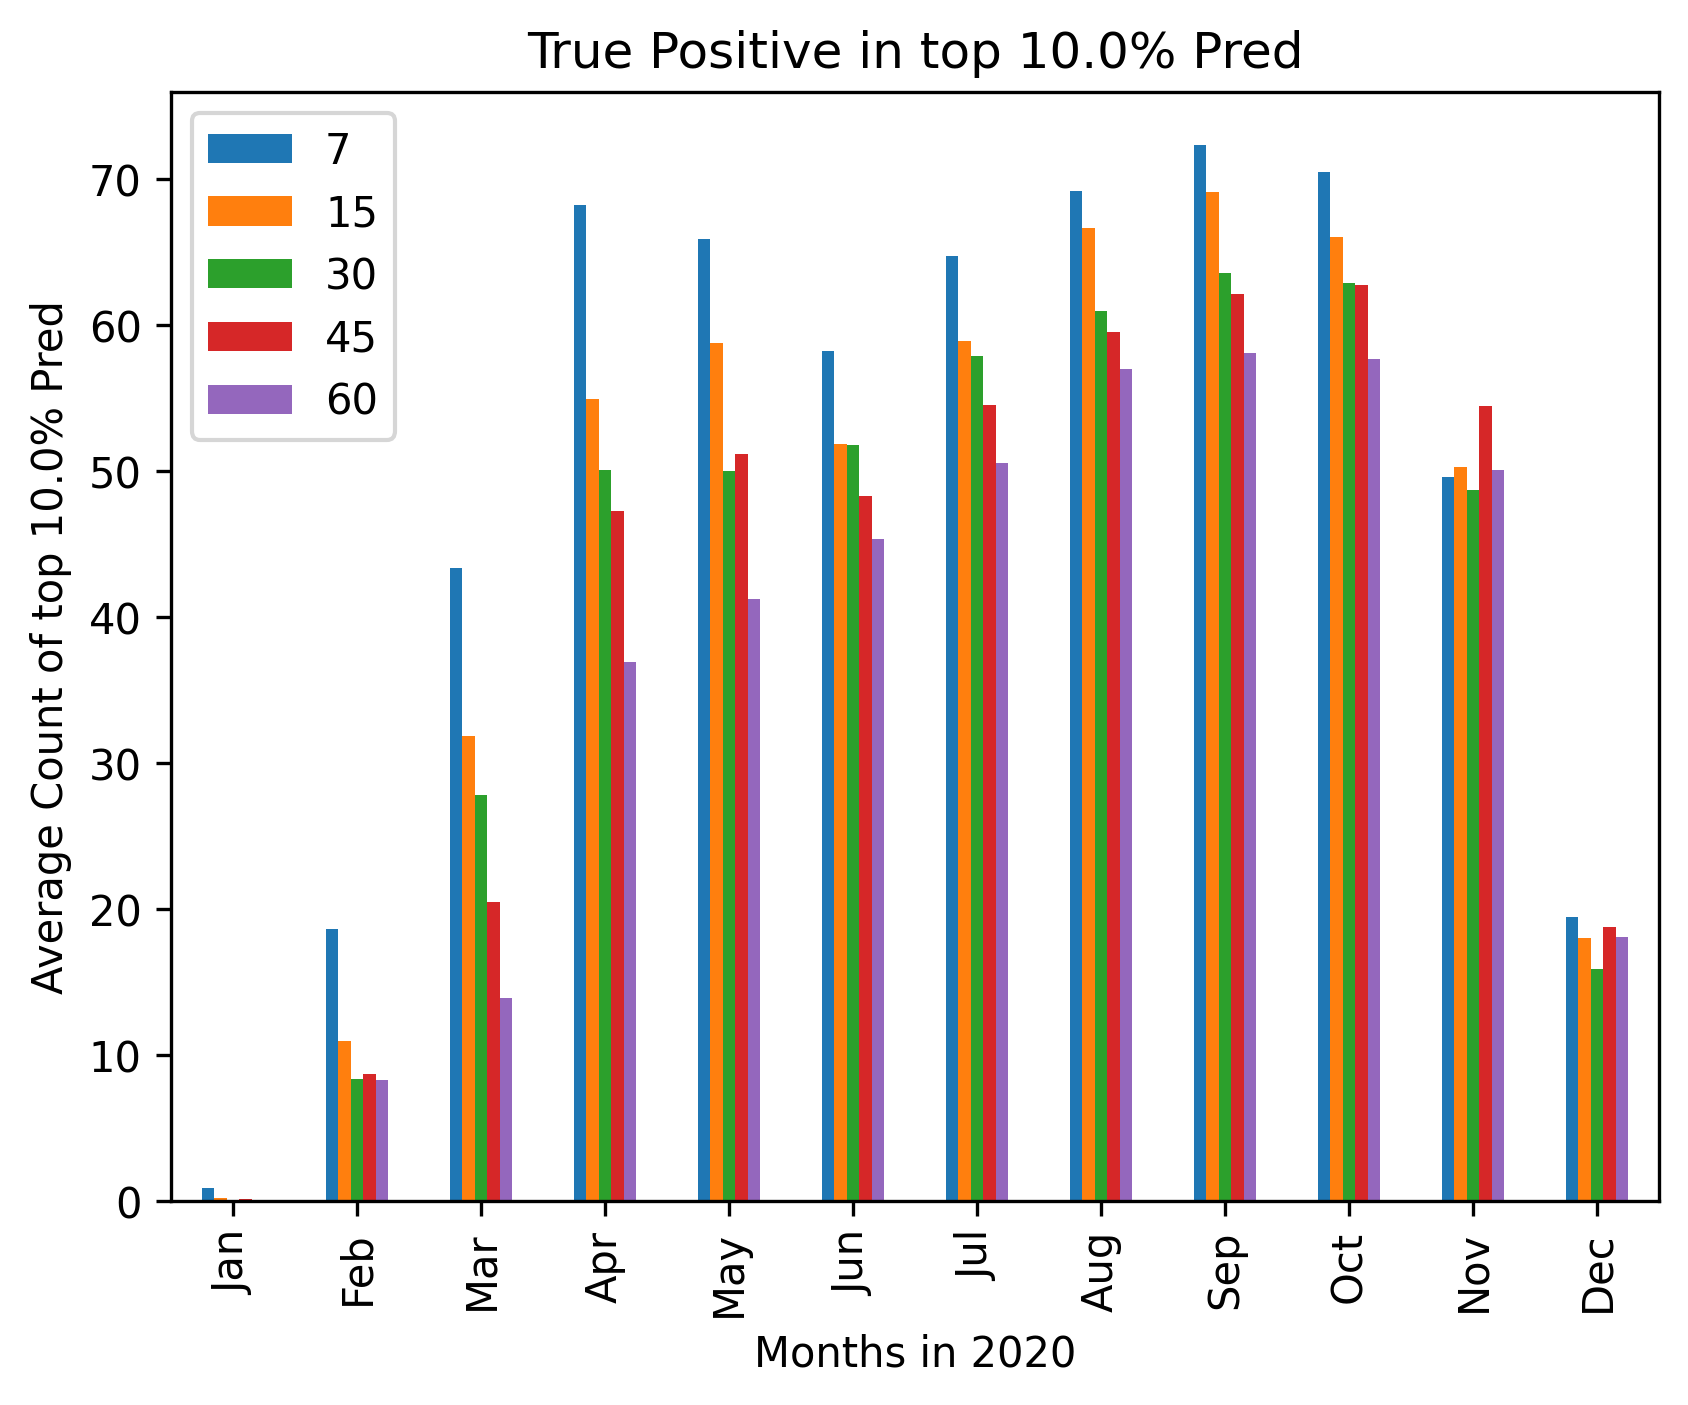

In [39]:
this_df_true_infected.plot (kind = "bar");
plt.title (f"True Positive in top {top_n * 100}% Pred")
plt.xlabel ("Months in 2020")
plt.ylabel (f"Average Count of top {top_n * 100}% Pred")

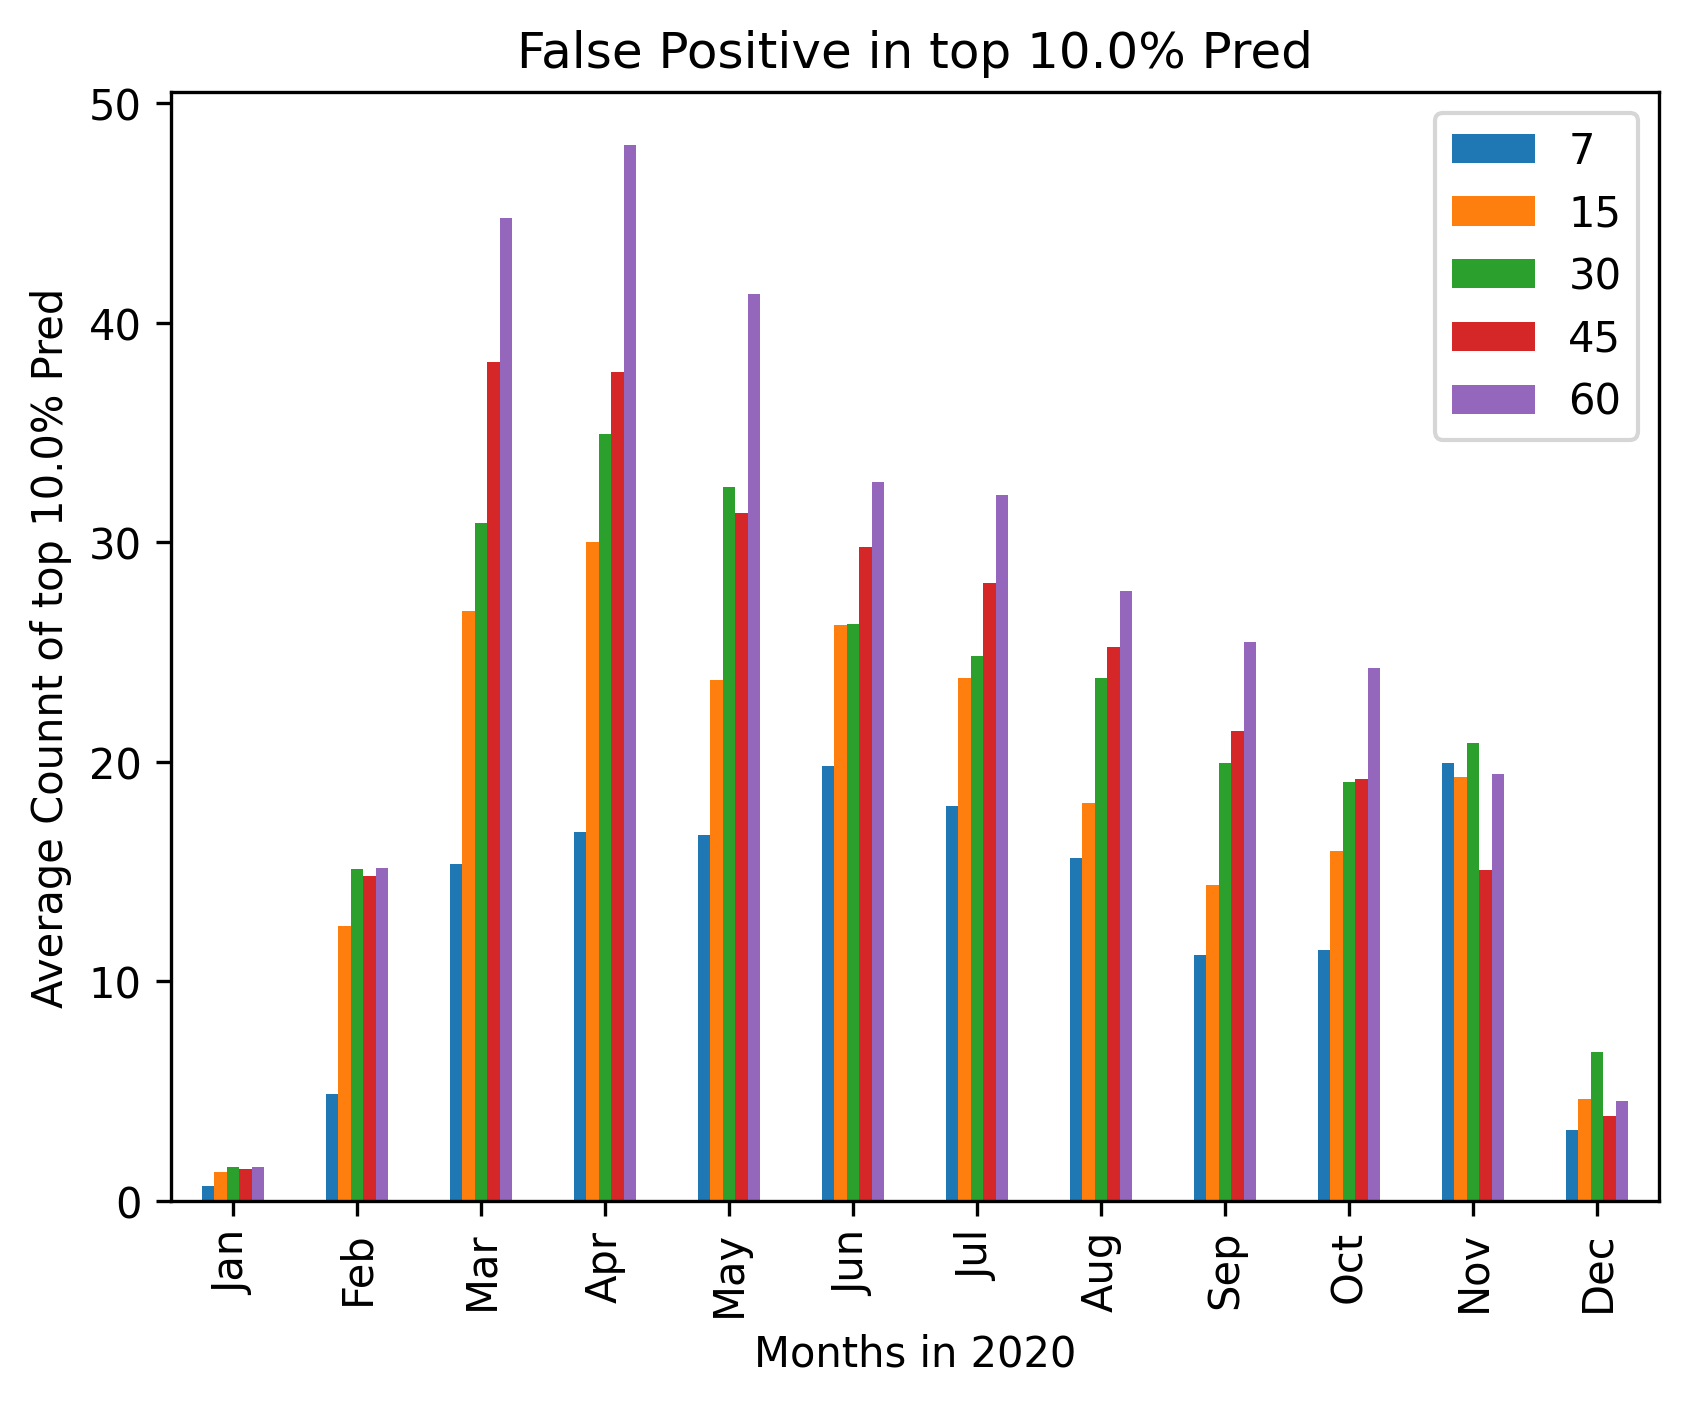

In [40]:
this_df_true_healthy.plot (kind = "bar");
plt.title (f"False Positive in top {top_n * 100}% Pred")
plt.xlabel ("Months in 2020");
plt.ylabel (f"Average Counnt of top {top_n * 100}% Pred");

3.5.1


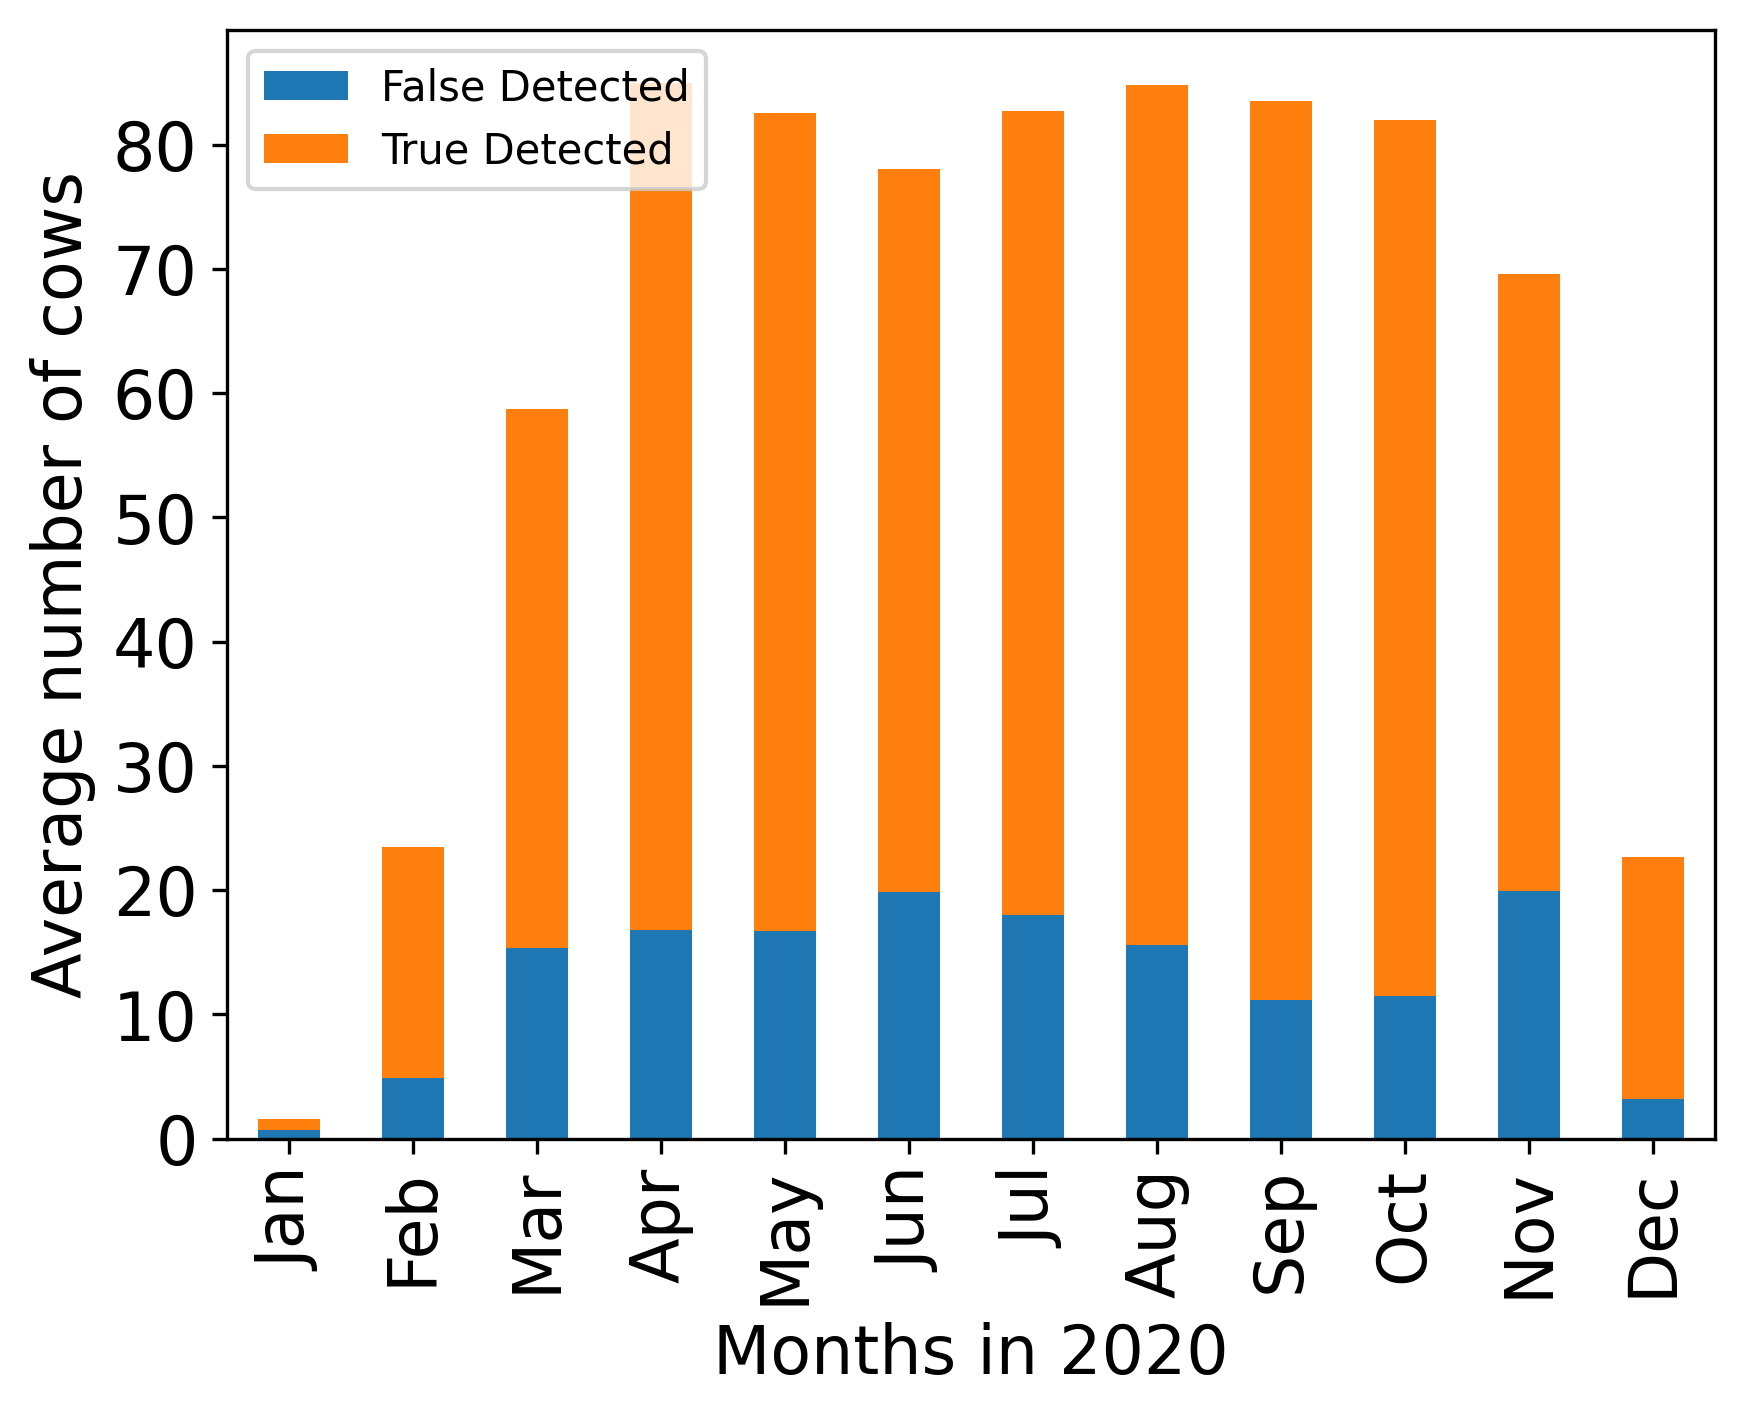

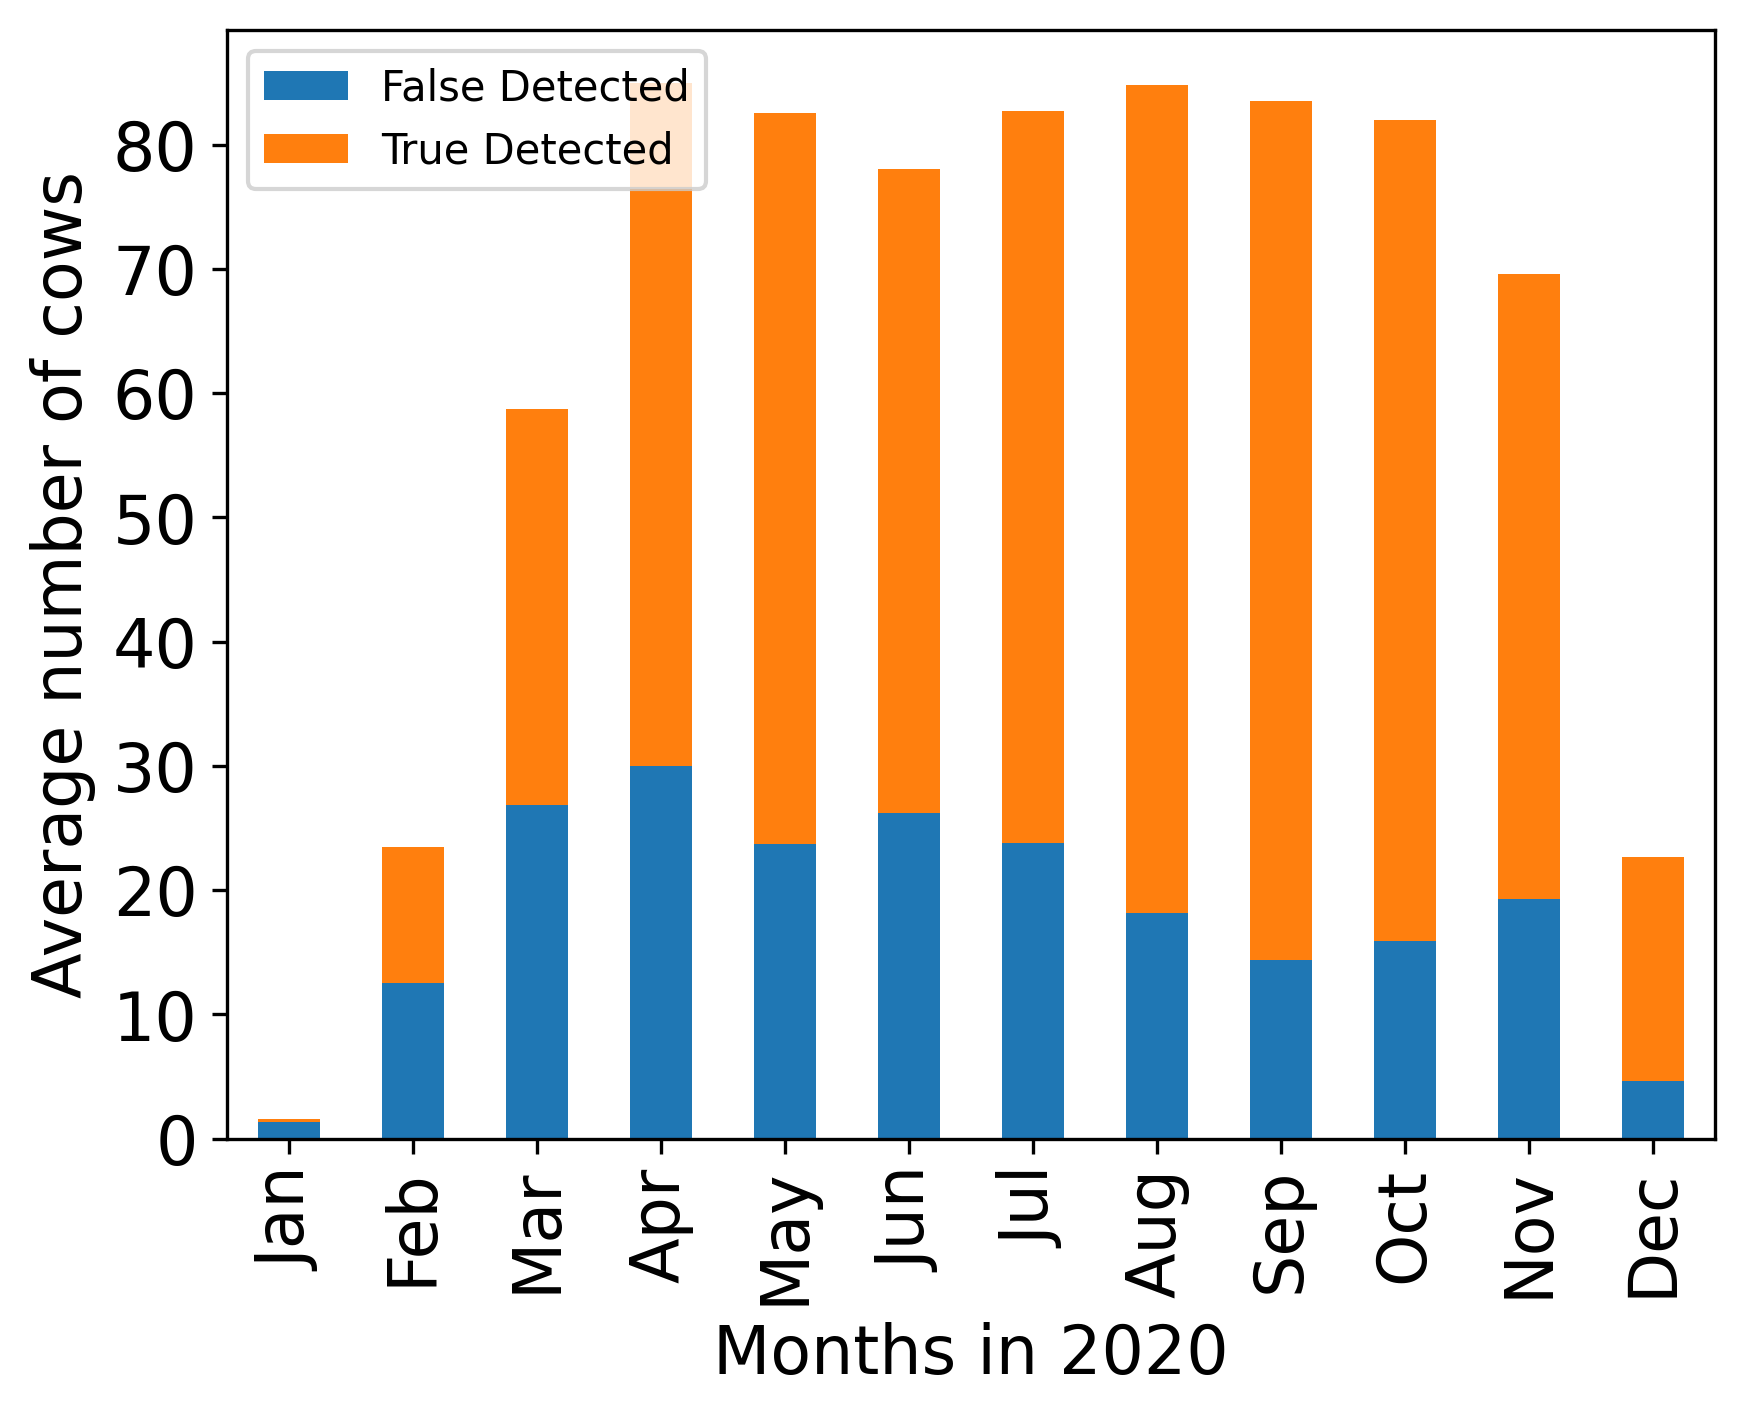

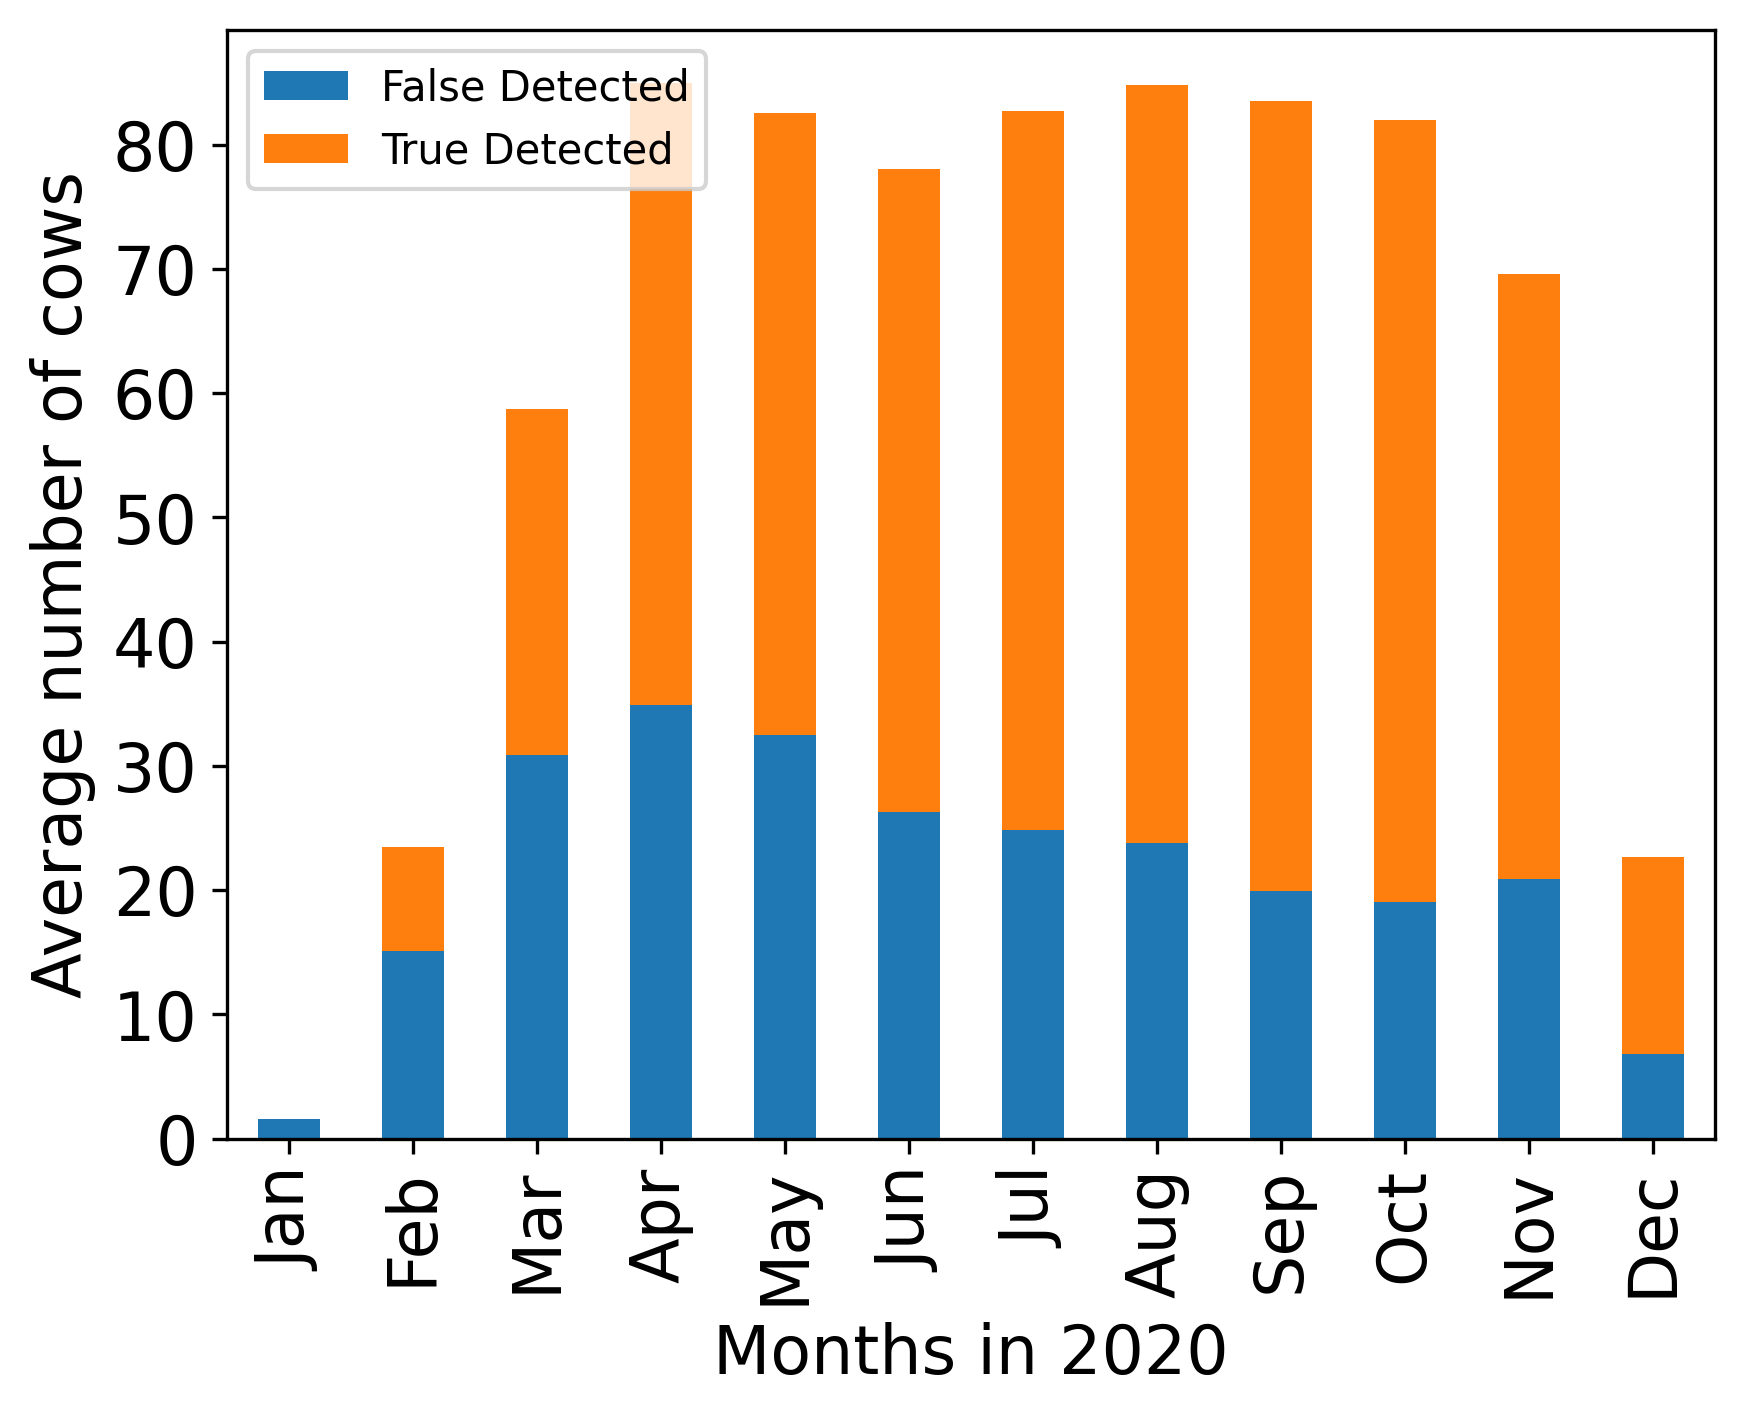

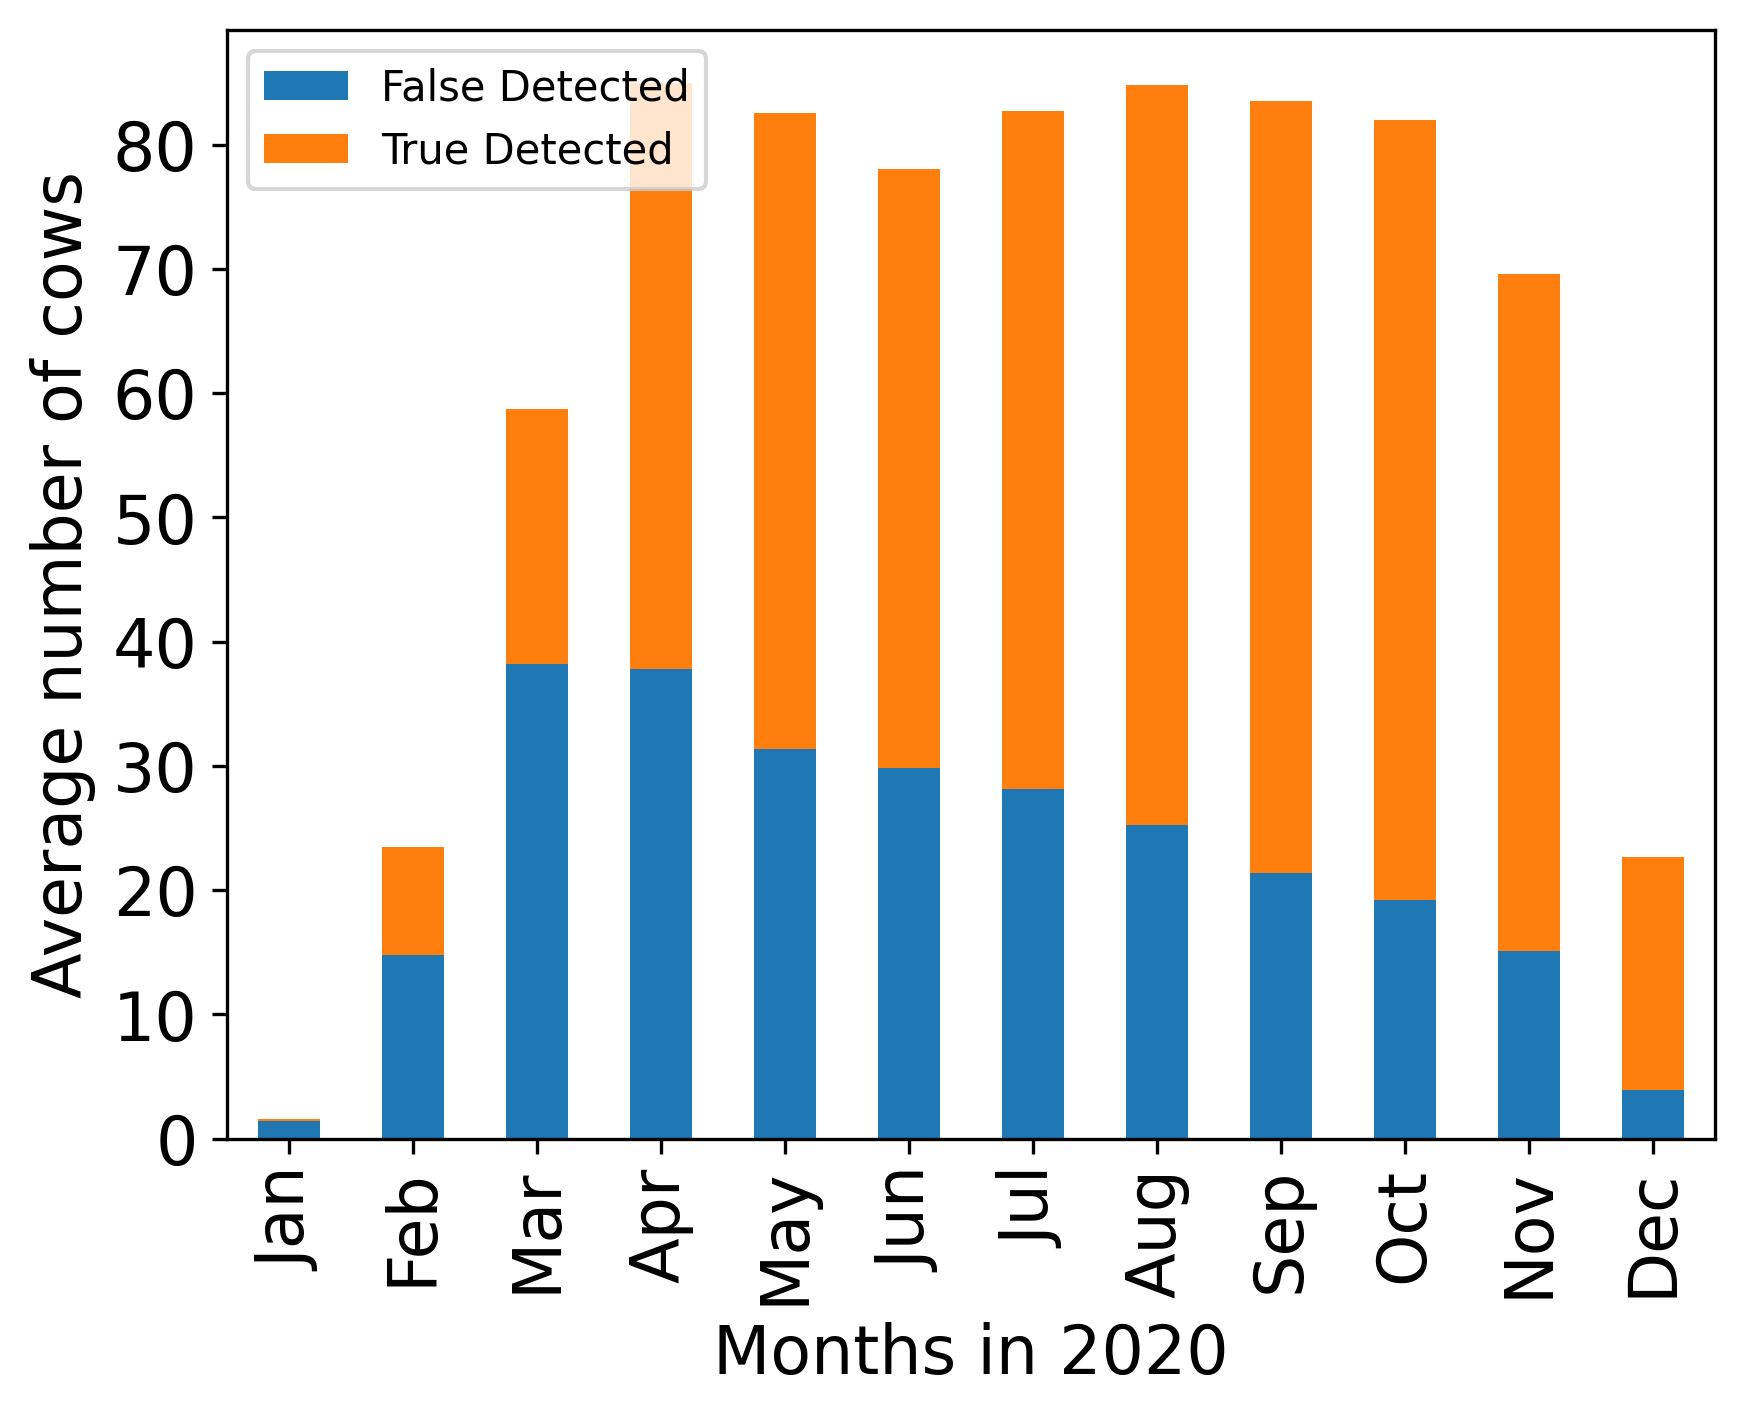

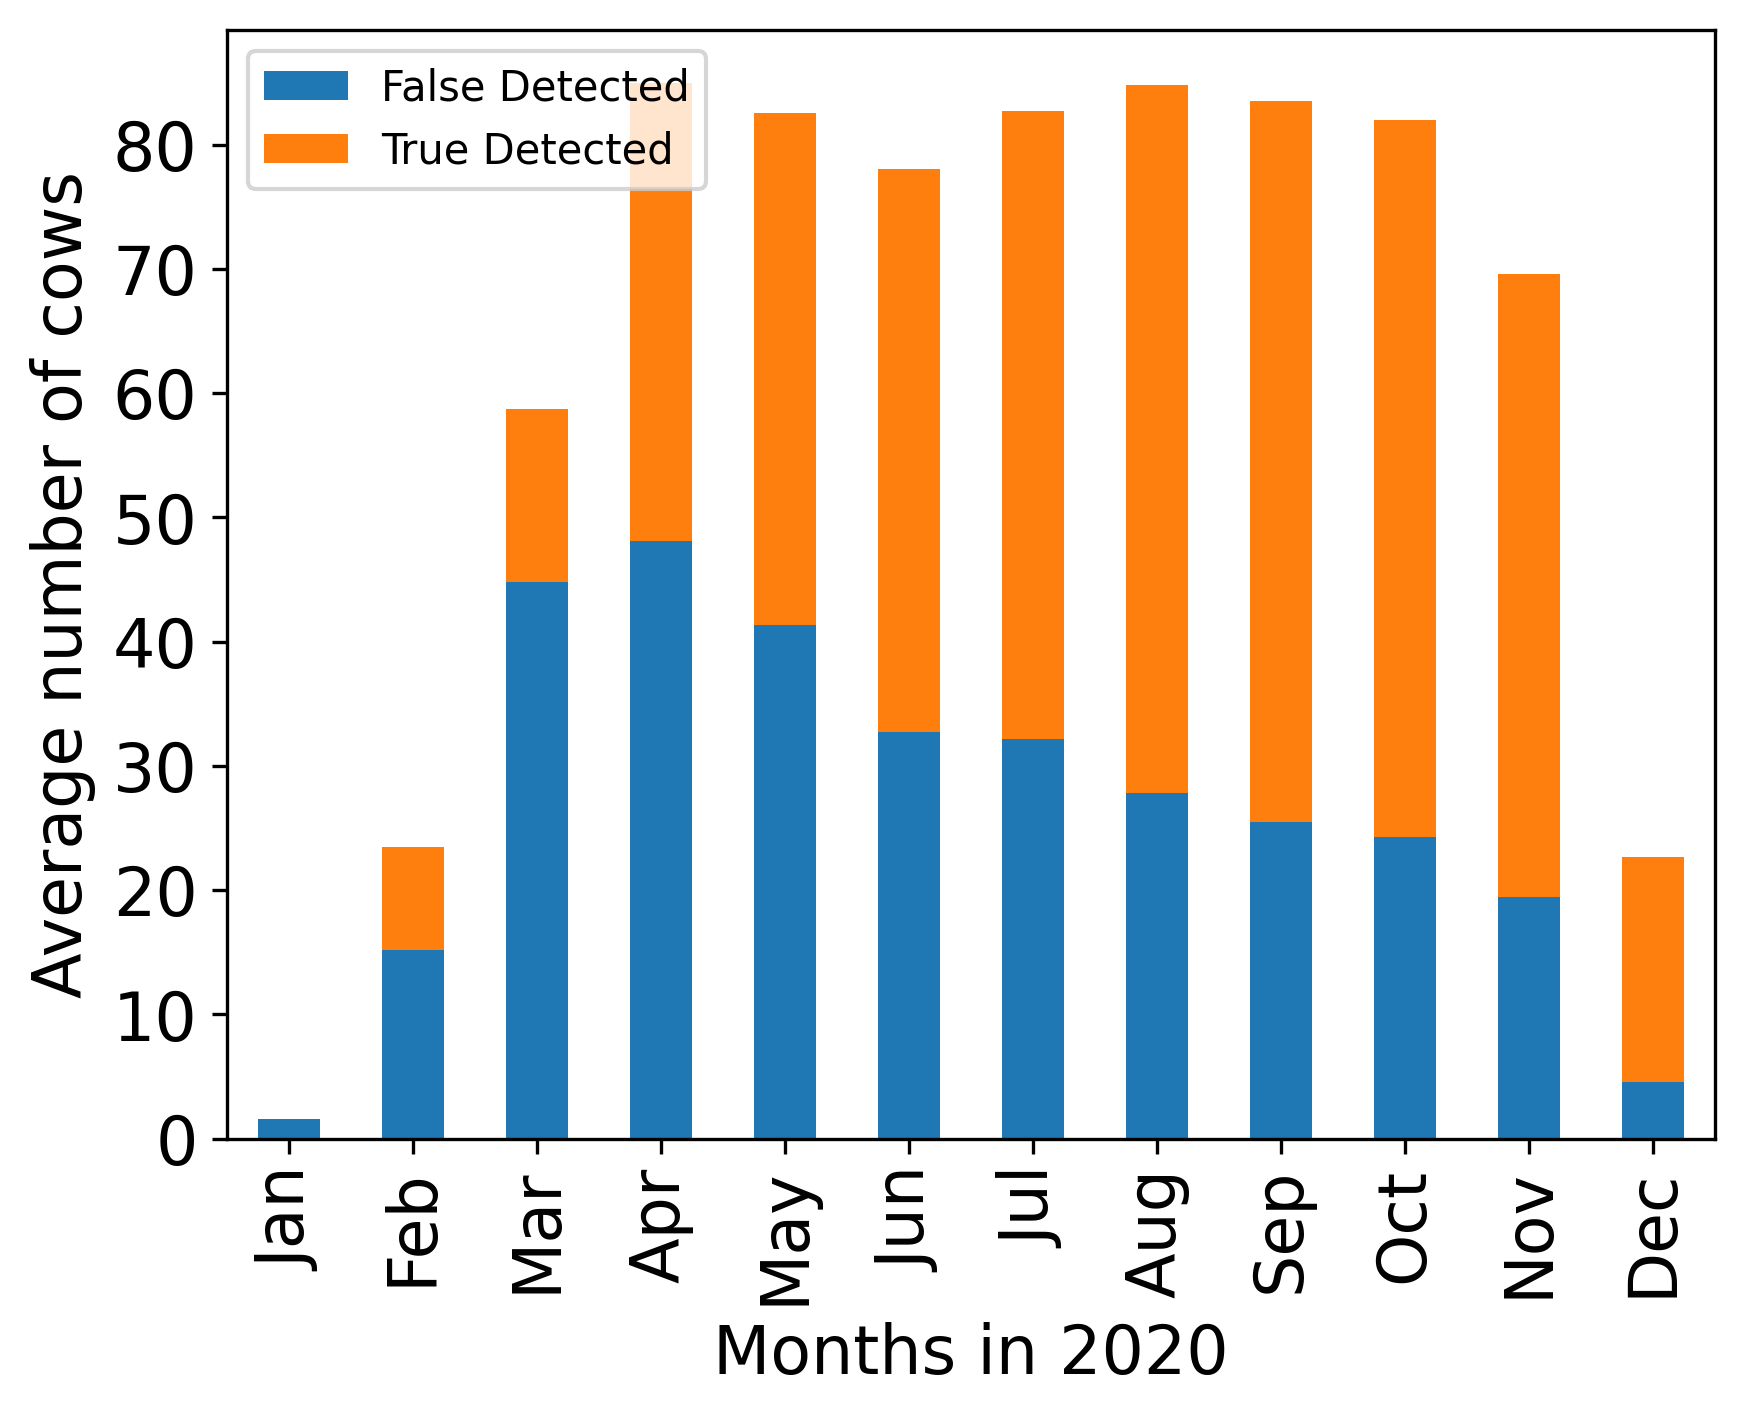

In [47]:
import matplotlib
print(matplotlib. __version__)
for didx in range (len (days_list)):
    ax = this_df_tpfp[days_list[didx]].plot (kind = "bar", stacked=True);
    tmp_str = str (days_list_plot_text[didx]);
    #plt.title ("Average top 10% predictions for " + f"$\mathregular" + "{" + "D_{" + f"{tmp_str}" + "}}$");
    plt.xlabel ("Months in 2020", fontsize = 16);
    plt.ylabel (f"Average number of cows", fontsize = 16);
    ax.legend (["False Detected", "True Detected"]);
    plt.xticks (fontsize = 16);
    plt.yticks (fontsize = 16)
    # dump the table for data recording freq. 7
    # remove 50 days, 25 days.

In [48]:
#list (map (sum, retval))
print ("Year: 2020, daily confusion matrix for the Top ", top_n * 100, "% predictions");
days = "60"; # The recording frequency
this_set = [];
this_set_label = [];
i = 1;
for this_month in retval.keys ():
    #print ("Average per day confusion matrix for the month: ", this_month);
    this_month_confusion_matrix = retval_list_summary[days][this_month];
    #this_month_entries = len (retval_list_summary["0"][this_month].keys ());
    daily_avg = retval_list_summary[days][this_month];
    daily_avg.columns.name = f"Top {np.round (top_n * 100, 2)}%";
    this_set_label.append (this_month)
    this_set.append (daily_avg.round (2));
    if i % 4 == 0:
        display_side_by_side (*this_set, titles = this_set_label);
        this_set = [];
        this_set_label = [];
    i = i + 1;

Year: 2020, daily confusion matrix for the Top  10.0 % predictions


Jan 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 1.56 
 
 
 True Infected 
 0.0 
 0.00 
 
 
 Feb 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 15.18 
 
 
 True Infected 
 0.0 
 8.32 
 
 
 Mar 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 44.77 
 
 
 True Infected 
 0.0 
 13.94 
 
 
 Apr 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 48.1 
 
 
 True Infected 
 0.0 
 36.9

May 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 41.32 
 
 
 True Infected 
 0.0 
 41.23 
 
 
 Jun 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 32.73 
 
 
 True Infected 
 0.0 
 45.33 
 
 
 Jul 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 32.16 
 
 
 True Infected 
 0.0 
 50.55 
 
 
 Aug 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 27.81 
 
 
 True Infected 
 0.0 
 56.97

Sep 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 25.47 
 
 
 True Infected 
 0.0 
 58.07 
 
 
 Oct 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 24.26 
 
 
 True Infected 
 0.0 
 57.71 
 
 
 Nov 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 19.47 
 
 
 True Infected 
 0.0 
 50.10 
 
 
 Dec 
 
 
 Top 10.0% 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 4.56 
 
 
 True Infected 
 0.0 
 18.11

In [49]:
print (retval_list_summary["0"]["Aug"].to_latex ())

\begin{tabular}{lrr}
\toprule
{} &  Predicted Healthy &  Predicted Infected \\
\midrule
True Healthy  &                0.0 &           15.612903 \\
True Infected &                0.0 &           69.161290 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_14683/2461785419.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print (retval_list_summary["0"]["Aug"].to_latex ())


Print all confusion matrix for all the data (top 100%).

In [50]:
retval_list_all = {};
for days in days_list:
    retval = {};
#     pred_info = pd.read_csv (f'{ptype}_{str (days)}_pred_info.csv'); # FIXME: Patch old version saved data on not storing input vars
    pred_info = pred_info_all[str (days)];
    for month in date_ranges.keys ():
        retval[month] = daily_conf_mat (pred_info, pd.date_range (start = date_ranges[month]["start"], end = date_ranges[month]["end"]), top_n = 1.0, var_summary = ["1_scc", "1_scc_future"]);
    retval_list_all[days] = retval;

In [51]:
#list (map (sum, retval))
print ("Year: 2020, daily confusion matrix for ALL the predictions");
for this_month in retval.keys ():
    print ("Average per day confusion matrix for the month: ", this_month);
    display (retval_list_summary["0"][this_month].round (2))

Year: 2020, daily confusion matrix for ALL the predictions
Average per day confusion matrix for the month:  Jan


Predicted Healthy  Predicted Infected
True Healthy                 0.0                0.67
True Infected                0.0                0.89

Average per day confusion matrix for the month:  Feb


Predicted Healthy  Predicted Infected
True Healthy                 0.0                4.86
True Infected                0.0               18.64

Average per day confusion matrix for the month:  Mar


Predicted Healthy  Predicted Infected
True Healthy                 0.0               15.35
True Infected                0.0               43.35

Average per day confusion matrix for the month:  Apr


Predicted Healthy  Predicted Infected
True Healthy                 0.0                16.8
True Infected                0.0                68.2

Average per day confusion matrix for the month:  May


Predicted Healthy  Predicted Infected
True Healthy                 0.0               16.68
True Infected                0.0               65.87

Average per day confusion matrix for the month:  Jun


Predicted Healthy  Predicted Infected
True Healthy                 0.0               19.83
True Infected                0.0               58.23

Average per day confusion matrix for the month:  Jul


Predicted Healthy  Predicted Infected
True Healthy                 0.0               18.00
True Infected                0.0               64.71

Average per day confusion matrix for the month:  Aug


Predicted Healthy  Predicted Infected
True Healthy                 0.0               15.61
True Infected                0.0               69.16

Average per day confusion matrix for the month:  Sep


Predicted Healthy  Predicted Infected
True Healthy                 0.0               11.20
True Infected                0.0               72.33

Average per day confusion matrix for the month:  Oct


Predicted Healthy  Predicted Infected
True Healthy                 0.0               11.45
True Infected                0.0               70.52

Average per day confusion matrix for the month:  Nov


Predicted Healthy  Predicted Infected
True Healthy                 0.0               19.97
True Infected                0.0               49.60

Average per day confusion matrix for the month:  Dec


Predicted Healthy  Predicted Infected
True Healthy                 0.0                3.22
True Infected                0.0               19.44

# Cow seven days lookahead

Load the top 100 percent from the already predicted files from the saved directory

Then also compute the top_n percent predictions

In [52]:
rescount_days_top_n = {};
rescount_days_all = {};
for didx in range (len (days_list)):
    this_day = int (days_list[didx]);
    
    pred_info = pred_info_all[str (this_day)];
    rescount_days_top_n[this_day] = early_detect_by_days_subclin (pred_info_all[days_list[didx]], target_var, top_n = top_n);
    
    overall_cows_file_path = f"./{model_type}_seven_day_cow_raw.joblib" if this_day == 0 else f"./{model_type}_seven_day_cow_raw_{str (this_day)}.joblib";
    rescount_days_all[this_day] = joblib.load (overall_cows_file_path);
    

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
rescount_days_top_n[0]["all_cows"]

### Top n percent lookahead plots

In [53]:
for didx in range (len (days_list)):
    this_day = int (days_list[didx]);
    ax = rescount_days_top_n[this_day]["all_cows"].iloc[0:8,[1,0]].plot (kind = "bar", stacked=True); # first row skipped because of days are 0, and the [1,0] is to make the default colour scheme line up. Make colour legends manual later.
    plt.title (f"Data Recording freq. {days_list_plot_text[didx]}");
    plt.xlabel ("Days predicted ahead");
    plt.ylabel (f"Average Nos. of top {top_n * 100}% Pred");
    ax.bar_label(ax.containers[1]);
    ax.bar_label(ax.containers[0]);
    ax.legend (["False Infected", "True Infected"]);
    plt.ylim ([0, 450])

KeyError: 0

### Top 100 percent lookahead plots

In [54]:
for didx in range (len (days_list)):
    this_day = int (days_list[didx]);    
    ax = rescount_days_all[this_day]["all_cows"].iloc[0:8,[1,0]].plot (kind = "bar", stacked=True); # first row skipped because of days are 0, and the [1,0] is to make the default colour scheme line up. Make colour legends manual later.
    plt.title (f"Data Recording freq. {days_list_plot_text[didx]}");
    plt.xlabel ("Days predicted ahead");
    plt.ylabel (f"Average Nos. of top {1.0 * 100}% Pred");
    ax.bar_label(ax.containers[1]);
    ax.bar_label(ax.containers[0]);
    ax.legend (["False Infected", "True Infected"]);
    plt.ylim ([0, 1700])
    

KeyError: 0

In [55]:
# retval_var_summary[days][month][this_var]
retval_list_summary["0"]["Aug"]

Predicted Healthy  Predicted Infected
True Healthy                 0.0           15.612903
True Infected                0.0           69.161290

In [56]:
pred_info["1_scc"].max ()

20566.0

In [ ]:
days = "0";
this_month = "Aug";
this_var = "1_scc";
density = True;


def plot_pred_dist (retval_var_summary, days, this_month, this_var, density = True, bins = 10):
    
    fn = np.round (retval_list_summary[days][this_month].iloc[0,0], 2);
    fp = np.round (retval_list_summary[days][this_month].iloc[0,1], 2);
    tn = np.round (retval_list_summary[days][this_month].iloc[1,0], 2);
    tp = np.round (retval_list_summary[days][this_month].iloc[1,1], 2);
    fig, axs = plt.subplots(1, 2)

    max_x = max (list (map (lambda x: max (x) if len (x) > 0 else 0, retval_var_summary[days][this_month][this_var].values ())));
#     range_x = (0, max_x);
    range_x = (0, 1000);
    
#     x, y, _ = axs[0,0].hist (retval_var_summary[days][this_month][this_var]["fn"], bins = bins, range = range_x, density = density);
# #     x, y, _ = axs[0,0].hist (retval_var_summary[days][this_month]["1_scc_future"]["fn"], bins = bins, range = range_x, density = density);
#     axs[0,0].set_title (f"False Negative {fn}");


    x, y, _ = axs[0].hist (retval_var_summary[days][this_month][this_var]["fp"], bins = bins, range = range_x, density = density);
#     x, y, _ = axs[0,1].hist (retval_var_summary[days][this_month]["1_scc_future"]["fp"], bins = bins, range = range_x, density = density);
    axs[0].set_title (f"False Positive {fp}");


#     x, y, _ = axs[1,0].hist (retval_var_summary[days][this_month][this_var]["tn"], bins = bins, range = range_x, density = density);
# #     x, y, _ = axs[1,0].hist (retval_var_summary[days][this_month]["1_scc_future"]["tn"], bins = bins, range = range_x, density = density);
#     axs[1,0].set_title (f"True Negative {tn}");


    x, y, _ = axs[1].hist (retval_var_summary[days][this_month][this_var]["tp"], bins = bins, range = range_x, density = density);
#     x, y, _ = axs[1,1].hist (retval_var_summary[days][this_month]["1_scc_future"]["tp"], bins = bins, range = range_x, density = density);
    axs[1].set_title (f"True Positive {tp}");

    fig.suptitle (f"Month {this_month}, Distribution of {this_var}")
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"


In [ ]:
# pred_info_bak = pred_info.copy ();
# df_test = pd.read_csv ("~/test.csv");
# pred_info["unsure_sub_clin"] = df_test["unsure_sub_clin"];
# pred_info = pred_info[pred_info["unsure_sub_clin"]==0];
retval_var_summary["0"]["Jan"]["1_scc"]["tp"].shape[0]
retval_list_summary["0"]["Jan"]

In [ ]:
for this_month in date_ranges.keys ():
    plot_pred_dist (retval_var_summary, "0", this_month, "1_scc", True, 15)

In [49]:
# pd.set_option ("display.max_rows", None);
# pred_info["1_scc_future"] = pred_info.groupby(['id'])["1_scc_future"].apply(lambda x: x.fillna(method = 'ffill'))
# np.sum (retval_var_summary["0"]["Aug"]["1_scc_future"]["tp"] == 0)
# display (pred_info[["id", "date", "1_scc", "1_scc_future", "early_detect_sub_clinical"]].head (1000))

In [50]:
tmp = pred_info[pred_info["date"].dt.month == 8]
display  (tmp[tmp["time_till_inf_sub_clin_0days"]>0])

Unnamed: 0       date               id  sub_clin  clin  \
406            406 2020-08-01  372226553560433         0     0   
407            407 2020-08-02  372226553560433         0     0   
408            408 2020-08-03  372226553560433         0     0   
409            409 2020-08-04  372226553560433         0     0   
410            410 2020-08-05  372226553560433         0     0   
...            ...        ...              ...       ...   ...   
231347      231347 2020-08-12   IE371176482360         0     0   
231348      231348 2020-08-13   IE371176482360         0     0   
231349      231349 2020-08-14   IE371176482360         0     0   
231350      231350 2020-08-15   IE371176482360         0     0   
231351      231351 2020-08-16   IE371176482360         0     0   

        days_since_calving  time_till_inf_sub_clin  time_till_inf_clin  \
406                    170                    38.0                 0.0   
407                    171                    37.0                 0.0   
408                    172                    36.0                 0.0   
409                    173                    35.0                 0.0   
410                    174                    34.0                 0.0   
...                    ...                     ...                 ...   
231347                 187                     5.0                 0.0   
231348                 188                     4.0                 0.0   
231349                 189                     3.0                 0.0   
231350                 190                     2.0                 0.0   
231351                 191                     1.0                 0.0   

        parity  PTA_mean  ...  2_weight  2_BCS  time_till_inf_sub_clin_0days  \
406          1      0.00  ...     465.0    3.0                          38.0   
407          1      0.00  ...     465.0    3.0                          37.0   
408          1      0.00  ...     465.0    3.0                          36.0   
409          1      0.00  ...     465.0    3.0                          35.0   
410          1      0.00  ...     465.0    3.0                          34.0   
...        ...       ...  ...       ...    ...                           ...   
231347       4      0.35  ...     646.0    3.0                           5.0   
231348       4      0.35  ...     646.0    3.0                           4.0   
231349       4      0.35  ...     646.0    3.0                           3.0   
231350       4      0.35  ...     646.0    3.0                           2.0   
231351       4      0.35  ...     646.0    3.0                           1.0   

        1_scc_0days  sub_clin_0days  early_detect_sub_clinical  pred_prob  \
406           135.0               0                          0       0.77   
407           135.0               0                          0       0.76   
408           135.0               0                          0       0.76   
409           135.0               0                          0       0.76   
410            66.0               0                          0       0.72   
...             ...             ...                        ...        ...   
231347         38.0               0                          1       0.34   
231348         38.0               0                          1       0.33   
231349         38.0               0                          1       0.33   
231350         38.0               0                          1       0.33   
231351         38.0               0                          1       0.33   

        pred_thresh  1_scc_future  pred_infected  
406            True          66.0           True  
407            True          66.0           True  
408            True          66.0           True  
409            True          73.0           True  
410            True          73.0           True  
...             ...           ...            ...  
231347        False         289.0          False  
231348        False         289.

## Days in milk based binning of confusion matrix

In [51]:
# Make confusion matrix per range of an attribute.
# For examaple, here we can make confusion matrices for each range of 30 days of "days_since_calving". For each period of 30 days of "days_since_calving" we get a confusion matrix
# If "this_month" is None, that means do it on the full dataset
def conf_mat_per_range (pred_info, target_var = "early_detect_sub_clinical", top_n = 1.0, this_month = None, attr_split = "days_since_calving", bins = None):
    pred_info["date"] = pd.to_datetime (pred_info["date"]);
    month_mapper = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}
    
    if this_month in month_mapper.keys ():
        tdf = pred_info[pred_info["date"].dt.month == month_mapper[this_month]];
    else:
        tdf = pred_info;
    
    tdf = tdf.sort_values (by = "pred_prob", inplace = False, ascending = False);
    nrows = int (np.round (tdf.shape[0] * top_n));
    print (nrows)
    if nrows == 0:
        print (f"No rows in top {top_n * 100}%");
        return None;
    
    tdf = tdf.iloc[range(nrows),:];
    
    # putting offset 
    # tdf[attr_split] = tdf[attr_split] - ((month_mapper[this_month] - 1) * 30);
        
    ind = np.digitize (tdf[attr_split], bins);
    
    confmat_group = {};
    for key, this_grp in tdf.groupby (ind):
      confmat = pd.DataFrame (confusion_matrix (this_grp[target_var], this_grp["pred_thresh"], labels = [0, 1]));
      confmat_group[key] = confmat;
        
    return confmat_group;

    

In [52]:
pd.set_option('display.max_rows', None)
tmp = pred_info[pred_info[target_var]==1];
# tmp[["date", "1_scc", "sub_clin", target_var, "pred_thresh"]].head (1000)

In [53]:
days = "0";
# Set "top_n" above, or override here
pred_info = pred_info_all[days]
bins = np.arange (np.min (pred_info["days_since_calving"]), np.max (pred_info["days_since_calving"]), 30);
binned_confmat = {}
for this_month in date_ranges.keys ():
    pred_info = pred_info[pred_info["days_since_calving"]>10];
    this_month_cm = conf_mat_per_range (pred_info, target_var = target_var, top_n = top_n, this_month = this_month, attr_split = "days_since_calving", bins = bins);
    binned_confmat[this_month] = this_month_cm;

28
707
1818
2548
2556
2342
2562
2631
2506
2540
2090
414


In [54]:
# Only recording the true positives and false positives now
plotdf_tp = pd.DataFrame (np.zeros ( (len (bins), len (date_ranges.keys ())) ));
plotdf_tp.index = list (range (len (bins)));
plotdf_tp.columns = date_ranges.keys ();

plotdf_fp = plotdf_tp.copy ();

for this_month in date_ranges.keys ():
    tmcf = binned_confmat[this_month];
    days_in_month = pd.Period (date_ranges[this_month]["start"]).days_in_month;


    for bin_idx in tmcf.keys ():
        this_bin_info = (tmcf[bin_idx]);# / days_in_month); # Dividing the number of days in this month to get the average daily prediction over the month
        plotdf_fp.loc[bin_idx-1,this_month] = this_bin_info.iloc[0,1];
        plotdf_tp.loc[bin_idx-1,this_month] = this_bin_info.iloc[1,1];


plotdf_tp.drop (plotdf_tp.index[-1], inplace = True);
plotdf_fp.drop (plotdf_fp.index[-1], inplace = True);


In [55]:
rowstr = [];
for i in range (len (bins)-1):
    this_str = str (bins[i]) + " to " + str (bins[i+1]) + " days in milk";
    rowstr.append (this_str);

plotdf_tp.index = rowstr;
plotdf_fp.index = rowstr;

In [56]:
pd.set_option ("precision", 2);

In [57]:
print ("True positive counts for average daily prediction for a month (columns), divided into \"days in milk\" 30 day intervals (columns)")
print ("For example")
display (plotdf_tp.style.background_gradient (cmap = "Blues", axis = None));


True positive counts for average daily prediction for a month (columns), divided into "days in milk" 30 day intervals (columns)
For example


In [58]:
display (plotdf_fp.style.background_gradient (cmap = "Blues", axis = None));

In [59]:
pd.reset_option ("precision");

#### Instead of per month breakdown, below is the overall breakdown of the predicitons

In [60]:
pred_info = pred_info_all["0"];
bins = np.arange (np.min (pred_info["days_since_calving"]), np.max (pred_info["days_since_calving"]), 30);
rowstr = [];
for i in range (len (bins)-1):
    this_str = str (bins[i]) + " to " + str (bins[i+1]) + " days in milk";
    rowstr.append (this_str);
    
overall_cm = conf_mat_per_range (pred_info, target_var = target_var, top_n = 0.1, this_month = "Aug", attr_split = "days_since_calving", bins = bins);


2631


In [61]:
cm_list = [];
label_list = [];
allkeys = list (overall_cm.keys ());
rowstr.append (str (" >= " + str (bins[-1]) + " days in milk"));
for bin_idx in allkeys:
    overall_cm[bin_idx].columns = ["Predicted Healthy", "Predicted Infected"];
    overall_cm[bin_idx].index = ["True Healthy", "True Infected"];
    cm_list.append (overall_cm[bin_idx]/31);
    label_list.append (rowstr[bin_idx-1]);
    if bin_idx % 5 == 0:
        display_side_by_side (*cm_list, titles = label_list);
        cm_list = [];
        label_list = [];
        
# zero = overall_cm[allkeys[0]].copy ();
# zero.iloc[0,1] = 0;
# zero.iloc[1,1] = 0;
# cm_list.append (zero);
# label_list.append (rowstr[bin_idx]);

# cm_list.append (zero);
# label_list.append (rowstr[bin_idx+1]);

display_side_by_side (*cm_list, titles = label_list);

101 to 131 days in milk 
 
 
 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 0.322581 
 
 
 True Infected 
 0.0 
 1.419355 
 
 
 131 to 161 days in milk 
 
 
 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 2.451613 
 
 
 True Infected 
 0.0 
 11.677419

161 to 191 days in milk 
 
 
 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 6.516129 
 
 
 True Infected 
 0.0 
 30.000000 
 
 
 191 to 221 days in milk 
 
 
 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 6.258065 
 
 
 True Infected 
 0.0 
 24.774194 
 
 
 221 to 251 days in milk 
 
 
 
 Predicted Healthy 
 Predicted Infected 
 
 
 
 
 True Healthy 
 0.0 
 0.225806 
 
 
 True Infected 
 0.0 
 1.225806

In [62]:
zero.iloc[0,1]

NameError: name 'zero' is not defined

## Cow ranking change each day

In [58]:
# Find daywise cow rank data, then group by cow and see the rank change
# So list the top ten percent, and check how many new cows enter the top chart.

In [59]:
pred_info = pred_info_all["0"];
pred_info["daily_rank"] = pred_info.groupby ("date")["pred_prob"].rank("dense", ascending = False);
#only_infected = pred_info[pred_info[target_var]==1];
only_infected = pred_info; #pred_info[pred_info["pred_thresh"]==1];
i = 0;

# print (pred_info[pred_info.date=="2020-01-18"][["id","date", "pred_prob", "daily_rank"]])

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
tot = [];
day_id_lists = [];
for _, this_grp in only_infected.groupby ("date"):
#     print (this_grp["daily_rank"].std ());
#     print (this_grp[["id", "date", "pred_prob", "pred_thresh", "daily_rank"]].sort_values ("date"));
#     ax.plot (this_grp["date"], this_grp["daily_rank"]);
#     print (this_grp.sort_values (by = "daily_rank", ascending = True))
#     days_gap = this_grp["date"].diff ().apply (lambda x: x.days);
#     consicutive = this_grp[days_gap <= 2];
#     print (consicutive["daily_rank"].std ());
# #     print (days_gap)
    tmp = this_grp.sort_values (by = "daily_rank", ascending = True);
    n = int (np.round (tmp.shape[0] * 0.1));
    if n == 0:
        n = tmp.shape[0];
    tot.append (n)
#     n = 10;
    day_id_lists.append (set (tmp[0:n].id.unique ()));
    i += 1;
#     if i == 100:
#         break;
        
# fig.autofmt_xdate()

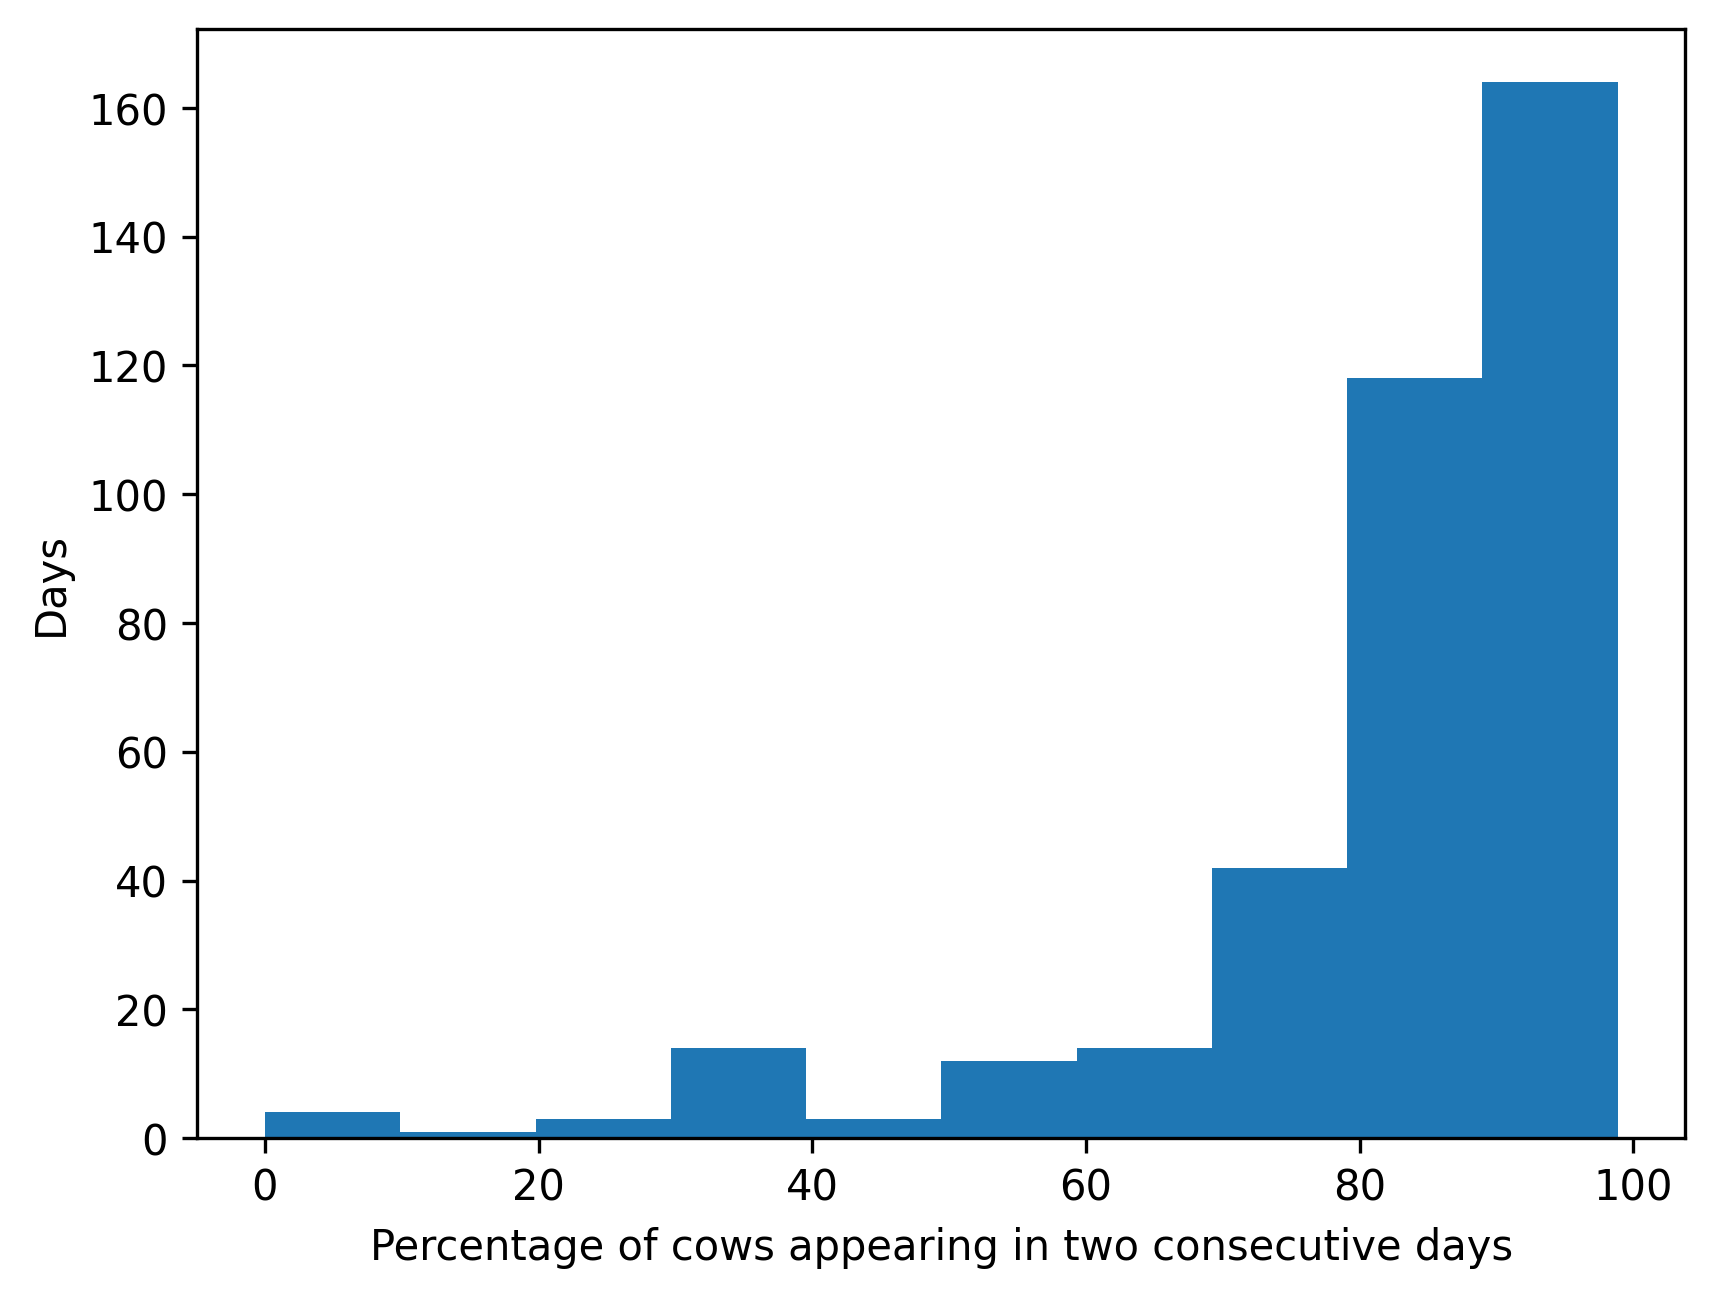

In [71]:
last_set = set ();
change_set_no = [];
for i in range (len (day_id_lists)):
    change_set_no.append (len (last_set.intersection (day_id_lists[i]))/(1+len (last_set.union (day_id_lists[i]))))
    last_set = day_id_lists[i];
    
# plt.bar (range (len (change_set_no)), np.array (change_set_no)/10)
plt.hist (np.array (change_set_no) * 100);
#plt.xlabel ("Same cows ratio in top 10% (percent) ranks from day x to day x + 1");
plt.xlabel ("Percentage of cows appearing in two consecutive days");
plt.ylabel ("Days");
#plt.title ("Ratio of same cows in day x to day x + 1")

In [77]:
#list (map (lambda x: len (x), day_id_lists))
print (np.mean (change_set_no))
print (np.median (change_set_no))
print (np.std (change_set_no))
val,count = np.unique(change_set_no,return_counts=True)
freq = {}
for v,c in zip(val,count):
  freq[v] = c
mode = sorted(freq.items(),key =lambda kv :kv[1])[-1]

print (mode)

0.8182135830437097
0.8651685393258427
0.1790478100895895
(0.8333333333333334, 34)


In [96]:
np.mean (change_set_no)

0.784729777597419

In [97]:
import kds
kds.metrics.plot_cumulative_gain(pred_info_all["0"][target_var], pred_info_all["0"]["pred_prob"])


ModuleNotFoundError: No module named 'kds'

### Predictions which were predicted to exceed threshold in 7 days, how many were above threshold at the latest milk recording

In [98]:
tmp = pd.DataFrame ();
for days in  days_list:
    pred_info = pred_info_all[days];

    pred_pos =  pred_info[pred_info["pred_thresh"]];
    print (pred_pos["sub_clin"].value_counts ());
    tmp = tmp.append (pred_pos["sub_clin"].value_counts ()/pred_pos.shape[0])
    
tmp.index = days_list_plot_text;
tmp = pd.DataFrame (tmp.iloc[:,1]).transpose ();
tmp.index = ["Fraction already high SCC"];

0    89884
1    19368
Name: sub_clin, dtype: int64
0    107220
1     22932
Name: sub_clin, dtype: int64
0    121482
1     24089
Name: sub_clin, dtype: int64
0    121518
1     26178
Name: sub_clin, dtype: int64
0    136113
1     27159
Name: sub_clin, dtype: int64


In [ ]:
tmp

In [ ]:
os.getpid ()


In [126]:
pred_info = pred_info_all["0"]
print (pred_info.shape)
pred_info = pred_info[pred_info["date"].dt.month == 8]
print (pred_info.shape)

(227398, 36)
(26309, 36)


array([[<AxesSubplot:title={'center':'1_scc'}>]], dtype=object)

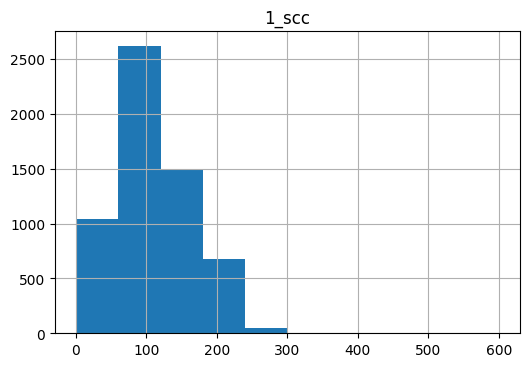

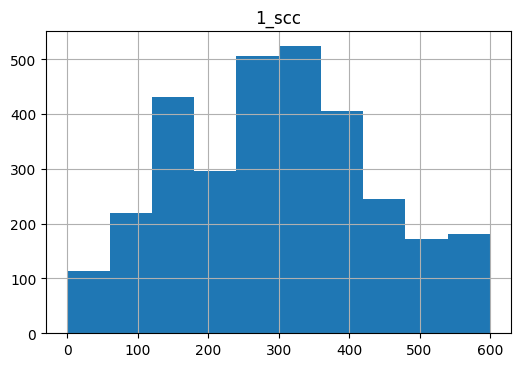

In [129]:
pred_info[(pred_info.pred_thresh == 1) & (pred_info.early_detect_sub_clinical == 0)][["1_scc"]].hist (range = (0, 600))
pred_info[(pred_info.pred_thresh == 1) & (pred_info.early_detect_sub_clinical == 1)][["1_scc"]].hist (range = (0, 600))

In [142]:
pred_info[target_var], pred+i

KeyError: 'unsure_subclin'